# Image quality analysis
This notebook will produce the figures and results for the different types of analysis considered in the paper, namely:
1. [Signal processing metrics](#signal_processing): SSIM, MS-SSIM, PSNR;
2. [SAR-quality metrics](#sar_quality): ENL and EPI;
3. [CNN-semantic metircs](#cnn_semantic): accuracies, ID, FID and KID.

## Libraries import

In [7]:
import sys
sys.path.append('../')
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dip_sar_inpainting.utils.data import Normalize
from tqdm.notebook import tqdm
from typing import Tuple, List
import rasterio
import torch
from matplotlib import rc
rc('font',**{'family':'Palatino'})  # Select font
rc('text', usetex=True)
from scipy.ndimage.filters import laplace
from dip_sar_inpainting.utils.PatchExtractor import PatchExtractor
from torchvision import transforms
from landcover_classification.classification.models.VGG import VGG16, VGG19
from landcover_classification.classification.models.ResNet import ResNet50, ResNet101, ResNet152
from landcover_classification.classification.models.DenseNet import DenseNet121, DenseNet161, DenseNet169, DenseNet201
from landcover_classification.classification.models.EfficientNet import EfficientNetGen
from landcover_classification.classification.models.InceptionNet import ISPLInceptionV3
from landcover_classification.classification.dataset import Normalize, ToTensor, load_s1
import pickle
from scipy.special import softmax
import sklearn.metrics as M
import itertools

## Helper functions

In [8]:
# --- Functions --- #

def load_SEN12MS_s1_raster_no_clip(path: str, tile_transform: bool=False) -> torch.Tensor:
    """
    Load S1 raster data from SEN12MS dataset.
    :param path: str, path to the tile to load
    :param tile_transform: bool, whether the image has to be normalized
    :return: np.array, the loaded and normalized tile
    """

    # Load raster
    with rasterio.open(path, 'r') as src:
        rdata = src.read()

    # Normalize
    rdata = rdata.astype(np.float32)
    rdata = np.nan_to_num(rdata)
    if not tile_transform:
        rdata = np.clip(rdata, -25, 0)
        rdata /= 25
        rdata += 1
    rdata = rdata.astype(np.float32)

    return torch.from_numpy(rdata)


def mz_score_norm(img: np.array, img_mad: float, img_med: float) -> np.array:
    """
    Perform the modified Z-score normalization
    suggested in “DeepInSAR—A Deep Learning Framework for SAR Interferometric Phase Restoration and Coherence Estimation”
    then reports the converted img in a 0-1 range.
    Code by Gianluca Murdaca (gianluca.murdaca@polimi.it)

    :param img: torch.Tensor, one of the S1 polarization bands used as input
    :param img_mad: float, the Mean Absolute Deviation from the median of the considered dataset
    :param img_med: float, the median computed on a significant # of samples of the considered dataset
    :return:
    """
    shape = img.shape
    img = img.flatten()
    img = 0.6745 * ((img - img_med / img_mad))  # 0.6475 is the 75th quartile of the normal distribution, removes the outlier
    img = (np.tanh(img / 7) + 1) / 2  # apply tanh to remove outliers
    img_min, img_max = img.min(), img.max()
    img = (img - img.min()) / (img.max() - img.min())  # normalize between 0 and 1
    img = img.reshape(shape)
    return img, img_min, img_max


def inv_mz_score_norm(img: np.array, img_min: float, img_max: float, img_mad: float, img_median: float) -> np.ndarray:
    """
    Inverse normalization of the m-Z score normalization
    """
#     img = img.astype(np.float32)
    img = (img+img_min)*(img_max-img_min)
    img *= 2
    img -= 1
    img = (0.5*np.log((1+img)/(1-img)))*7
    img /= 0.6475
    img = (img+img_median)*img_mad
    return img


def compute_hist(path: str, bands: Tuple[int]) -> np.array:
    # Open the image
    if path.split('/')[-1].split('.')[-1] == 'tif':
        img = Normalize()(load_SEN12MS_s1_raster_no_clip(path, True))[bands].numpy()
    else:
        img = np.load(path)[bands]
        
    feat = np.histogram(img.flatten(), bins=bins, density=True)[0]
    return feat

def compute_hist_fix_range(path: str, bands: Tuple[int], range: List[int], bins: int=50) -> np.array:
    # Open the image
    if path.split('/')[-1].split('.')[-1] == 'tif':
        img = Normalize()(load_SEN12MS_s1_raster_no_clip(path, True))[bands].numpy()
    else:
        img = np.load(path)[bands]
        
    feat = np.histogram(img.flatten(), bins=bins, range=range, density=True)[0]
    return feat

def analyze_batch(batch: torch.Tensor, model: torch.nn.Module, device: str) -> List[torch.tensor]:
    if torch.cuda.is_available():
        labels, data = labels.to(device), data.to(device)
    with torch.no_grad():
        features = model.encoder(data).detach().cpu().numpy()
        pre_logits = model.forward(data).detach().cpu().numpy()
        preds, acc = multi_acc_and_preds_1_vs_rest(pre_logits, labels)
    return [features, pre_logits, preds, acc]

def multi_acc_and_preds_1_vs_rest(y_pred, y_test):
    y_pred_sigmoid = torch.nn.functional.softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_sigmoid, dim = 1)
    correct_pred = (torch.squeeze(y_pred_tags) == y_test).float()
    acc = (correct_pred.sum() / len(correct_pred))*100
    return y_pred_tags, acc


# Functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band: np.array) -> np.array:
    """
    Convert to linear units
    
    :param band: np.array, the dB SAR tile to convert
    """
    return np.power(10, np.array(band)/10)


def linear_to_decibel(band):
    """
    Convert to dB
    
    :param band: np.array, the SAR tile to convert into dB
    """
    return 10*np.log10(band)


# --- Classes --- #

class SEN12MS_inpainting(torch.utils.data.Dataset):
    """
    PyTorch dataset class for the SEN12MS inpainted dataset
    """

    def __init__(self, ls_dir=None, imgTransform=None,
                 label_type="multi_label", threshold=0.1,
                 load_or=True, load_inp=False, load_gen=False, IGBP_s=True, data_df: pd.DataFrame=None):
        """Initialize the dataset"""

        # inizialize
        super(SEN12MS_inpainting, self).__init__()
        self.imgTransform = imgTransform
        self.threshold = threshold
        self.label_type = label_type

        # make sure input parameters are okay
        if not (load_or or load_inp or load_gen):
            raise ValueError("No input specified, set at least one of "
                             + "load_[or, gen, inp] to True!")
        self.load_or = load_or
        self.load_inp = load_inp
        self.load_gen = load_gen
        self.IGBP_s = IGBP_s
        self.data_df = data_df

        assert label_type in ["multi_label", "single_label"]  # new !!

        # provide number of input channels
        self.n_inputs = 2

        # provide number of IGBP classes
        self.n_classes = 10 if IGBP_s else 17

        # make sure parent dir exists
        assert os.path.exists(ls_dir)

        # import lables as a dictionary
        label_file = os.path.join(ls_dir, 'IGBP_probability_labels.pkl')

        a_file = open(label_file, "rb")
        self.labels = pkl.load(a_file)
        a_file.close()

        # remove broken file
        broken_file = 'ROIs1868_summer_s2_146_p202.tif'
        if broken_file in self.data_df.index.get_level_values(0).unique().tolist():
            self.data_df = self.data_df.drop(labels=broken_file)
            
    # util function for reading data from single sample passed as a Pandas Series
    def load_sample(self, sample, labels, label_type, threshold, imgTransform, load_or, load_gen, load_inp, IGBP_s):

        if load_or:
            img = load_s1(sample.loc[(sample.index.get_level_values(0)[0], 's1'), 'path_s1'], imgTransform)
        elif load_gen:
            img = np.load(sample.loc[(sample.index.get_level_values(0)[0], 's1'), 'Final_generated_sample_path'])
        elif load_inp:
            img = np.load(sample.loc[(sample.index.get_level_values(0)[0], 's1'), 'Final_inpainted_sample_path'])

        # load label
        lc = labels[sample.index.get_level_values(0)[0]]

        # covert label to IGBP simplified scheme
        if IGBP_s:
            cls1 = sum(lc[0:5]);
            cls2 = sum(lc[5:7]);
            cls3 = sum(lc[7:9]);
            cls6 = lc[11] + lc[13];
            lc = np.asarray([cls1, cls2, cls3, lc[9], lc[10], cls6, lc[12], lc[14], lc[15], lc[16]])

        if label_type == "multi_label":
            lc_hot = (lc >= threshold).astype(np.float32)
        else:
            loc = np.argmax(lc, axis=-1)
            lc_hot = np.zeros_like(lc).astype(np.float32)
            lc_hot[loc] = 1

        rt_sample = {'image': img, 'label': lc_hot, 'id': sample.index.get_level_values(0)[0]}

        if imgTransform is not None:
            rt_sample = imgTransform(rt_sample)

        return rt_sample
    

    def __getitem__(self, index):
        """Get a single example from the dataset"""

        # get and load sample from index file
        sample = self.data_df.loc[[self.data_df.index.get_level_values(0)[index]]]
        labels = self.labels
        return self.load_sample(sample, labels, self.label_type, self.threshold, self.imgTransform,
                                self.load_or, self.load_gen, self.load_inp, self.IGBP_s)

    def __len__(self):
        """Get number of samples in the dataset"""
        return len(self.data_df.index.get_level_values(0).unique())

## Execution parameters

In [9]:
# PUT HERE the folder with all the images divided in classes!
data_root = '/nas/public/exchange/sar_inpainting/experiments/quantitative_analysis/SEN12MS_inp_size_64/FINAL_SWEEP_SEARCH'

## Load data in dB scale in double polarization

In [16]:
all_inp_dfs_paths = glob.glob(os.path.join(data_root, '**', '*.pkl'), recursive=True)
# Load each DataFrame, re-arrange it as a MultiLevel DataFrame
classes = ['Urban', 'Barren', 'Croplands', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Savanna']
all_dfs = []
for path in all_inp_dfs_paths:
    # Load the DataFrame
    df = pd.read_pickle(path)
    # Prepend a level with the loss
    if 'loss_1' in path:
        loss_1 = path.split('loss_1-')[-1].split('_')[0]
        loss_2 = path.split('loss_2-')[-1].split('_')[0]
        if loss_1 != loss_2:
            df = pd.concat({'{} + {}'.format(loss_1, loss_2): df}, names=['Loss'])
        else:
            df = pd.concat({'{}'.format(loss_1): df}, names=['Loss'])
    # Prepend a level with the land-cover class
    for lc_class in classes:
        if lc_class in path.split('classes-')[1].split('_')[0]:
            df = pd.concat({lc_class: df}, names=['Classes'])
    # Add to DFs list
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs)  # create final DF
all_dfs['Final_generated_sample_path'] = all_dfs['Final_generated_sample_path'].apply(lambda x: x.replace('gen.npy', 'dip.npy'))
all_dfs['Final_generated_sample_path'] = all_dfs['Final_generated_sample_path'].apply(lambda x: x.replace('/nas/home/ecannas/sar_forensics/sar_gan_img_inpainting/', '/nas/public/exchange/sar_inpainting/'))
all_dfs['Inpainting_mask_path'] = all_dfs['Inpainting_mask_path'].apply(lambda x: x.replace('/nas/home/ecannas/sar_forensics/sar_gan_img_inpainting/', '/nas/public/exchange/sar_inpainting/'))
all_dfs['Final_inpainted_sample_path'] = all_dfs['Final_inpainted_sample_path'].apply(lambda x: x.replace('/nas/home/ecannas/sar_forensics/sar_gan_img_inpainting/', '/nas/public/exchange/sar_inpainting/'))



all_dfs

path_lc  \
Classes Loss                                                                
Barren  ssim + mse 0    /nas/public/dataset/SEN12MS/ROIs1868_summer/lc...   
                   1    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_5...   
                   2    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...   
                   3    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_6...   
                   4    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...   
...                                                                   ...   
Urban   ssim + mse 395  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...   
                   396  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...   
                   397  /nas/public/dataset/SEN12MS/ROIs1158_spring/lc...   
                   398  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...   
                   399  /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...   

                            seed  season  region      tile  Barren  \
Classes Loss                                                         
Barren  ssim + mse 0    ROIs1868  summer      68  p185.tif   100.0   
                   1    ROIs1970    fall      57  p181.tif   100.0   
                   2    ROIs2017  winter      77  p726.tif   100.0   
                   3    ROIs1970    fall      62   p64.tif   100.0   
                   4    ROIs2017  winter      77  p651.tif   100.0   
...                          ...     ...     ...       ...     ...   
Urban   ssim + mse 395  ROIs1970    fall     140  p285.tif     NaN   
                   396  ROIs1970    fall     131   p48.tif     NaN   
                   397  ROIs1158  spring     121  p716.tif     NaN   
                   398  ROIs1970    fall     120  p515.tif     NaN   
                   399  ROIs2017  winter     108  p804.tif     NaN   

                                                                  path_s1  \
Classes Loss                                                                
Barren  ssim + mse 0    /nas/public/dataset/SEN12MS/ROIs1868_summer/s1...   
                   1    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_5...   
                   2    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...   
                   3    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_6...   
                   4    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...   
...                                                                   ...   
Urban   ssim + mse 395  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...   
                   396  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...   
                   397  /nas/public/dataset/SEN12MS/ROIs1158_spring/s1...   
                   398  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...   
                   399  /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...   

                       sensor_s1  \
Classes Loss                       
Barren  ssim + mse 0          s1   
                   1          s1   
                   2          s1   
                   3          s1   
                   4          s1   
...                          ...   
Urban   ssim + mse 395        s1   
                   396        s1   
                   397        s1   
                   398        s1   
                   399        s1   

                                              Final_inpainted_sample_path  \
Classes Loss                                                                
Barren  ssim + mse 0    /nas/public/exchange/sar_inpainting/experiment...   
                   1    /nas/public/exchange/sar_inpainting/experiment...   
                   2    /nas/public/exchange/sar_inpainting/experiment...   
                   3    /nas/public/exchange/sar_inpainting/experiment...   
                   4    /nas/public/exchange/sar_inpainting/experiment...   
...                                                                   ...   
Urban   ssim + mse 395  /nas/public/exchange/sar_inpainting/experi

## Let's filter out samples that did not converge
We'll use as metric the ENL, that computes a sort of ratio on the variance. If we have infinity, this means we have a flat region (variance=0).

In [17]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['ENL_VV_orig'] = np.nan
results_df['ENL_VH_orig'] = np.nan
results_df['ENL_VV_gen'] = np.nan
results_df['ENL_VH_gen'] = np.nan


# Prepare the execution parameters
pe = PatchExtractor((25, 25))

# Computation loop
# We need to load each sample, divide it into 25x25 non-overlapping patches, and compute the ENL

for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    df = results_df.loc[(lc_class, 'ssim + mse')]
    samples = df.sample(n=400, random_state=42)
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = (mask-mask.min())/(mask.max()-mask.min())
        if pol_bands == 'VVVH':
                
            # ENL modification: ENL = [mean(patch^2)]^2/[std(patch^2)]^2  
            # Original VV
            patches = pe.extract(decibel_to_linear(orig[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, 'ssim + mse', i), 'ENL_VV_orig'] = np.mean([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # we consider the mean ENL for each image
            
            # Original VH
            patches = pe.extract(decibel_to_linear(orig[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, 'ssim + mse', i), 'ENL_VH_orig'] = np.mean([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # we consider the mean ENL for each image
            
            # Generated VV
            patches = pe.extract(decibel_to_linear(gen[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, 'ssim + mse', i), 'ENL_VV_gen'] = np.mean([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # we consider the mean ENL for each image
            
            # Generated VH
            patches = pe.extract(decibel_to_linear(gen[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, 'ssim + mse', i), 'ENL_VH_gen'] = np.mean([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # we consider the mean ENL for each image
                
    
# displaying the DataFrame
results_df[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]

/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


ENL_VV_orig  ENL_VH_orig  ENL_VV_gen  ENL_VH_gen
Classes Loss                                                            
Barren  ssim + mse 0      18.550721    15.678611   17.766694   15.098268
                   1       8.636516     8.695475    8.854898    8.812905
                   2      12.773743    12.888858   13.443714   12.850303
                   3      18.260693    15.556476   17.903925   15.006938
                   4      17.628725    13.767944   16.641457   13.041685
...                             ...          ...         ...         ...
Urban   ssim + mse 395    12.320017    11.381747   11.687544   10.599708
                   396    11.848498    11.609283   12.438464   12.268489
                   397    12.263298     9.930399   12.255979   10.628384
                   398     9.647515     6.080823    9.642895    5.990805
                   399    16.291957    12.396232   15.920431   12.156262

[2800 rows x 4 columns]

In [18]:
enl_results = []
for idx, lc_class in enumerate(results_df[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']].index.unique(level=0)):
    samples = results_df.loc[(lc_class, 'ssim + mse')]  # get class samples 
    # Compute 99th quantile
    samples_gen = samples['ENL_VV_gen'].to_numpy()
    q = np.quantile(samples_gen, 0.99)
    # append to final DataFrames list
    enl_results.append(pd.concat({lc_class: samples.loc[samples['ENL_VV_gen'] <= q]}, names=['Classes']))
    

enl_results = pd.concat(enl_results)
enl_results

/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


path_lc      seed  \
Classes                                                                    
Barren  0    /nas/public/dataset/SEN12MS/ROIs1868_summer/lc...  ROIs1868   
        1    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_5...  ROIs1970   
        2    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   
        3    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_6...  ROIs1970   
        4    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   
...                                                        ...       ...   
Urban   395  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        396  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        397  /nas/public/dataset/SEN12MS/ROIs1158_spring/lc...  ROIs1158   
        398  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        399  /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   

             season  region      tile  Barren  \
Classes                                         
Barren  0    summer      68  p185.tif   100.0   
        1      fall      57  p181.tif   100.0   
        2    winter      77  p726.tif   100.0   
        3      fall      62   p64.tif   100.0   
        4    winter      77  p651.tif   100.0   
...             ...     ...       ...     ...   
Urban   395    fall     140  p285.tif     NaN   
        396    fall     131   p48.tif     NaN   
        397  spring     121  p716.tif     NaN   
        398    fall     120  p515.tif     NaN   
        399  winter     108  p804.tif     NaN   

                                                       path_s1 sensor_s1  \
Classes                                                                    
Barren  0    /nas/public/dataset/SEN12MS/ROIs1868_summer/s1...        s1   
        1    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_5...        s1   
        2    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   
        3    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_6...        s1   
        4    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   
...                                                        ...       ...   
Urban   395  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        396  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        397  /nas/public/dataset/SEN12MS/ROIs1158_spring/s1...        s1   
        398  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        399  /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   

                                   Final_inpainted_sample_path  \
Classes                                                          
Barren  0    /nas/public/exchange/sar_inpainting/experiment...   
        1    /nas/public/exchange/sar_inpainting/experiment...   
        2    /nas/public/exchange/sar_inpainting/experiment...   
        3    /nas/public/exchange/sar_inpainting/experiment...   
        4    /nas/public/exchange/sar_inpainting/experiment...   
...                                                        ...   
Urban   395  /nas/public/exchange/sar_inpainting/experiment...   
        396  /nas/public/exchange/sar_inpainting/experiment...   
        397  /nas/public/exchange/sar_inpainting/experiment...   
        398  /nas/public/exchange/sar_inpainting/experiment...   
        399  /nas/public/exchange/sar_inpainting/experiment...   

                                   Final_generated_sample_path  ... Croplands  \
Classes                                                         ...             
Barren  0    /nas/public/exchange/sar_inpainting/experiment...  ...       NaN   
        1    /nas/public/exchange/sar_inpainting/experiment...  ...       NaN   
        2    /nas/public/exchange/sar_inpainting/experiment...  ...       NaN   
        3    /nas/public/exchange/sar_inpainting/experiment...  ...       NaN   
        4    /nas/public/exchange/sar_inpainting/experiment...  ...       NaN   
...          

In [19]:
# Let's pick only the samples we need
all_dfs = all_dfs.droplevel(1, 0).loc[enl_results.index]
all_dfs

path_lc      seed  \
Classes                                                                    
Barren  0    /nas/public/dataset/SEN12MS/ROIs1868_summer/lc...  ROIs1868   
        1    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_5...  ROIs1970   
        2    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   
        3    /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_6...  ROIs1970   
        4    /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   
...                                                        ...       ...   
Urban   395  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        396  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        397  /nas/public/dataset/SEN12MS/ROIs1158_spring/lc...  ROIs1158   
        398  /nas/public/dataset/SEN12MS/ROIs1970_fall/lc_1...  ROIs1970   
        399  /nas/public/dataset/SEN12MS/ROIs2017_winter/lc...  ROIs2017   

             season  region      tile  Barren  \
Classes                                         
Barren  0    summer      68  p185.tif   100.0   
        1      fall      57  p181.tif   100.0   
        2    winter      77  p726.tif   100.0   
        3      fall      62   p64.tif   100.0   
        4    winter      77  p651.tif   100.0   
...             ...     ...       ...     ...   
Urban   395    fall     140  p285.tif     NaN   
        396    fall     131   p48.tif     NaN   
        397  spring     121  p716.tif     NaN   
        398    fall     120  p515.tif     NaN   
        399  winter     108  p804.tif     NaN   

                                                       path_s1 sensor_s1  \
Classes                                                                    
Barren  0    /nas/public/dataset/SEN12MS/ROIs1868_summer/s1...        s1   
        1    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_5...        s1   
        2    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   
        3    /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_6...        s1   
        4    /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   
...                                                        ...       ...   
Urban   395  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        396  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        397  /nas/public/dataset/SEN12MS/ROIs1158_spring/s1...        s1   
        398  /nas/public/dataset/SEN12MS/ROIs1970_fall/s1_1...        s1   
        399  /nas/public/dataset/SEN12MS/ROIs2017_winter/s1...        s1   

                                   Final_inpainted_sample_path  \
Classes                                                          
Barren  0    /nas/public/exchange/sar_inpainting/experiment...   
        1    /nas/public/exchange/sar_inpainting/experiment...   
        2    /nas/public/exchange/sar_inpainting/experiment...   
        3    /nas/public/exchange/sar_inpainting/experiment...   
        4    /nas/public/exchange/sar_inpainting/experiment...   
...                                                        ...   
Urban   395  /nas/public/exchange/sar_inpainting/experiment...   
        396  /nas/public/exchange/sar_inpainting/experiment...   
        397  /nas/public/exchange/sar_inpainting/experiment...   
        398  /nas/public/exchange/sar_inpainting/experiment...   
        399  /nas/public/exchange/sar_inpainting/experiment...   

                                   Final_generated_sample_path  \
Classes                                                          
Barren  0    /nas/public/exchange/sar_inpainting/experiment...   
        1    /nas/public/exchange/sar_inpainting/experiment...   
        2    /nas/public/exchange/sar_inpainting/experiment...   
        3    /nas/public/exchange/sar_inpainting/experiment...   
        4    /nas/public/exchange/sar_inpainting/experiment...   
...                                                        ...   
Urban   395  /nas/public/exchange/sar_inpainting/exp

## Signal processing metrics
<a id='signal_processing'></a>

### Full reference metrics
We consider Peak-Signal-to-Noise Ratio (PSNR), Structural Self-Similarity Index (SSIM), Multi-Scale Structural Similarity (MS-SSIM), etc.

In [20]:
import piq
import time

results_df = all_dfs.copy()
results_df['PSNR'] = np.nan
results_df['PSNR_no_inp_area'] = np.nan
results_df['SSIM'] = np.nan
results_df['SSIM_no_inp_area'] = np.nan
results_df['MS-SSIM'] = np.nan
results_df['MS-SSIM_no_inp_area'] = np.nan
results_df['train_loss'] = np.nan

gpu = 0
batch_size = 32
tic = time.time()
for batch_idx0 in tqdm(np.arange(start=0, stop=len(results_df), step=batch_size), desc='Images processed'):
    
    # Load the partial DataFrame
    par_df = results_df.iloc[batch_idx0:batch_idx0+batch_size]
    
    # Load samples
    orig_batch = []
    gen_batch = []
    for idx, sample in par_df.iterrows():
        orig, gen, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True)), torch.tensor(np.load(sample['Final_generated_sample_path'])), np.load(sample['Inpainting_mask_path'])
        # Normalize between 0 and 1
        orig = (orig-orig.min())/(orig.max()-orig.min())
        gen = (gen-gen.min())/(gen.max()-gen.min())
        mask = (mask-mask.min())/(mask.max()-mask.min())
        # Append to batch tensor
        orig_batch.append(orig.unsqueeze(0))
        gen_batch.append(gen.unsqueeze(0))
        
    orig_batch = torch.concat(orig_batch)
    gen_batch = torch.concat(gen_batch)
    
    # Send to GPU
    device = f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu'
    orig_batch = orig_batch.to(device)
    gen_batch = gen_batch.to(device)
    mask = torch.Tensor(mask).to(device).unsqueeze(0)
    
    # Compute metrics
    mse = torch.nn.MSELoss()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['PSNR'] = piq.psnr(orig_batch, gen_batch, data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['PSNR_no_inp_area'] = piq.psnr((orig_batch*mask.unsqueeze(0)), (gen_batch*mask.unsqueeze(0)), data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['SSIM'] = piq.ssim(orig_batch, gen_batch, data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['SSIM_no_inp_area'] = piq.ssim(orig_batch*mask.unsqueeze(0), gen_batch*mask.unsqueeze(0), data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['MS-SSIM'] = piq.multi_scale_ssim(orig_batch, gen_batch, data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['MS-SSIM_no_inp_area'] = piq.multi_scale_ssim(orig_batch*mask.unsqueeze(0), gen_batch*mask.unsqueeze(0), data_range=1., reduction='none').tolist()
    results_df.iloc[batch_idx0:batch_idx0+batch_size]['train_loss'] = (0.5*mse(orig_batch*mask.unsqueeze(0), gen_batch*mask.unsqueeze(0)) - 0.5*piq.ssim(orig_batch*mask.unsqueeze(0), gen_batch*mask.unsqueeze(0), data_range=1., reduction='none')).tolist()
    
toc = time.time() - tic
print('Computation done in {:.4f} seconds'.format(toc))
torch.cuda.empty_cache()

Images processed:   0%|          | 0/87 [00:00<?, ?it/s]

/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Computation done in 26.4041 seconds


In [21]:
mean_df = results_df.groupby(by='Classes').mean()
mean_df[['PSNR', 'PSNR_no_inp_area', 'SSIM', 'SSIM_no_inp_area', 'MS-SSIM', 'MS-SSIM_no_inp_area', 'train_loss']]

PSNR  PSNR_no_inp_area      SSIM  SSIM_no_inp_area   MS-SSIM  \
Classes                                                                        
Barren     21.277612         23.076977  0.833694          0.893704  0.908084   
Croplands  24.451568         26.791831  0.876830          0.934575  0.930339   
Forest     22.727208         25.011082  0.869237          0.928899  0.921221   
Grassland  22.610220         24.750413  0.855927          0.915475  0.917618   
Shrubland  22.376875         24.526832  0.854135          0.914186  0.915326   
Urban      21.221309         22.638344  0.874448          0.932819  0.926529   
Water      19.418186         20.544899  0.782049          0.842935  0.878663   

           MS-SSIM_no_inp_area  train_loss  
Classes                                     
Barren                0.963982   -0.441049  
Croplands             0.983894   -0.464875  
Forest                0.977238   -0.460962  
Grassland             0.973204   -0.454236  
Shrubland             0.972261   -0.452723  
Urban                 0.981540   -0.462189  
Water                 0.936419   -0.412171

### Let's plot them more nicely

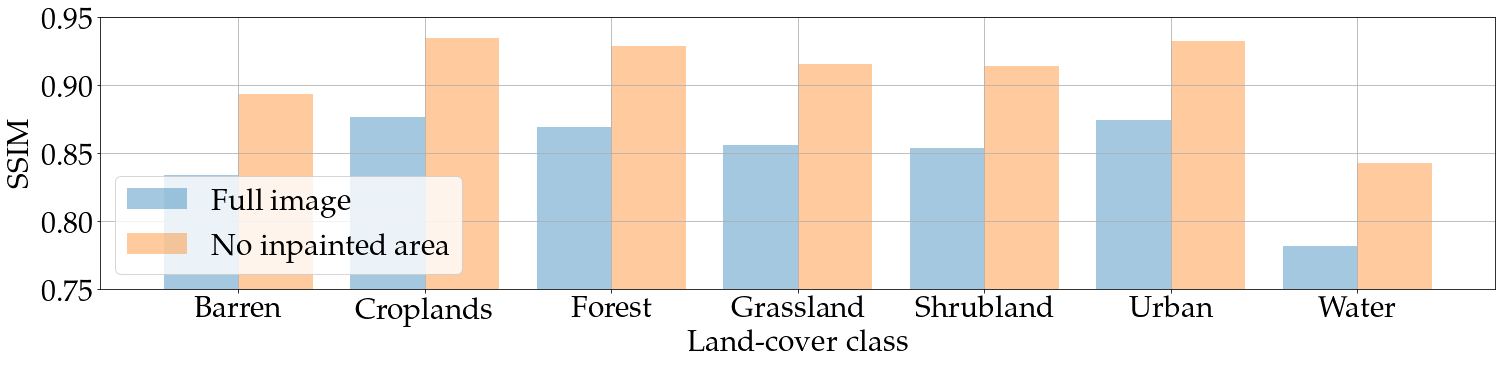

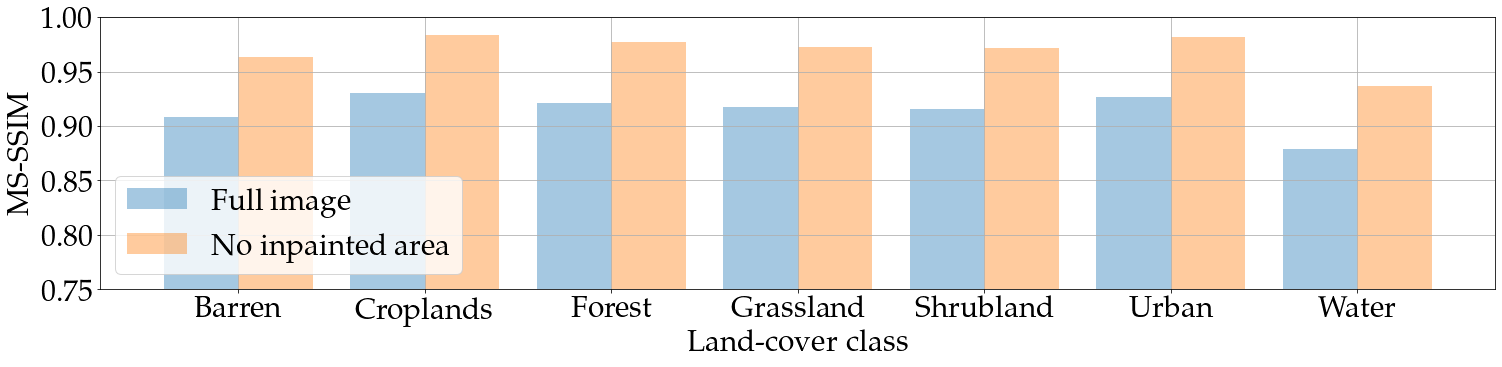

In [23]:
labels = ['PSNR', 'SSIM', 'MS-SSIM', 'MSE + SSIM']
fsize = 30
# for idx, metric in enumerate(['PSNR', 'SSIM', 'MS-SSIM', 'train_loss']):
for idx, metric in enumerate(['SSIM', 'MS-SSIM']):
    # Plot metrics for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(25, 5))
    X_axis = np.arange(len(mean_df.index))
    if metric == 'PSNR':
        # Plot metrics for each class as a bar plot
        X_axis = np.arange(len(mean_df.index))
        orig_recs = axs.bar(X_axis - 0.2, mean_df[metric], 0.4, label = 'Full image', alpha=0.4)
        gen_recs = axs.bar(X_axis + 0.2, mean_df[f'{metric}_no_inp_area'], 0.4, label = 'No inpainted area', alpha=0.4)
        axs.set_ylabel("dB value", fontsize=fsize)
    elif metric == 'train_loss':
        # Plot metrics for each class as a bar plot
        X_axis = np.arange(len(mean_df.index))
        gen_recs = axs.bar(X_axis, -1*mean_df[metric], 0.4, label = 'No inpainted area', alpha=0.4)
        axs.set_ylabel("Loss value", fontsize=fsize)
    else:
        orig_recs = axs.bar(X_axis - 0.2, mean_df[metric], 0.4, label = 'Full image', alpha=0.4)
        gen_recs = axs.bar(X_axis + 0.2, mean_df[f'{metric}_no_inp_area'], 0.4, alpha=0.4, label='No inpainted area')
        axs.set_ylabel("{}".format(metric), fontsize=fsize)
        if metric == 'SSIM':
            axs.set_ylim([0.75, 0.95])
            axs.set_yticks(np.arange(0.75, 1, .05))
        else:
            axs.set_ylim([0.75, 1])
            axs.set_yticks(np.arange(0.75, 1.01, .05))

    axs.set_xticks(X_axis)
    axs.set_xticklabels(mean_df.index)
    axs.tick_params('y', labelsize=fsize)
    axs.tick_params('x', labelsize=fsize)
    axs.set_xlabel("Land-cover class", fontsize=fsize)        
    axs.legend(fontsize=fsize, loc='lower left')
    axs.grid()
    plt.show()

## Let's look at more SAR oriented metrics
<a id='sar_quality'></a>

### Equivalent Number of Looks (ENL)
From the paper [Enhanced Directional Smoothing Algorithm for Edge-Preserving Smoothing of Synthetic-Aperture Radar Images](https://arxiv.org/pdf/1608.01993.pdf).  

#### Full Image (FI) scenario
We have already computed the metrics for all samples at the beginning.

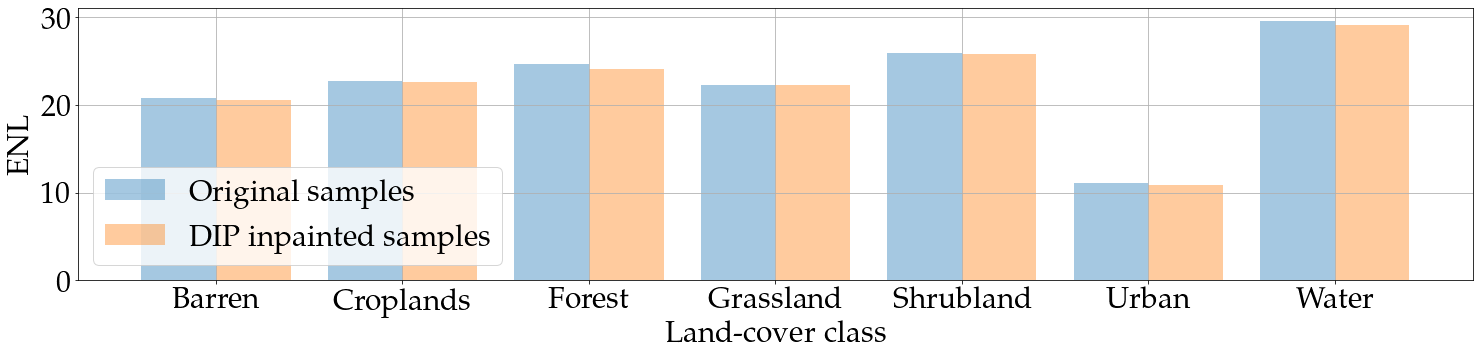

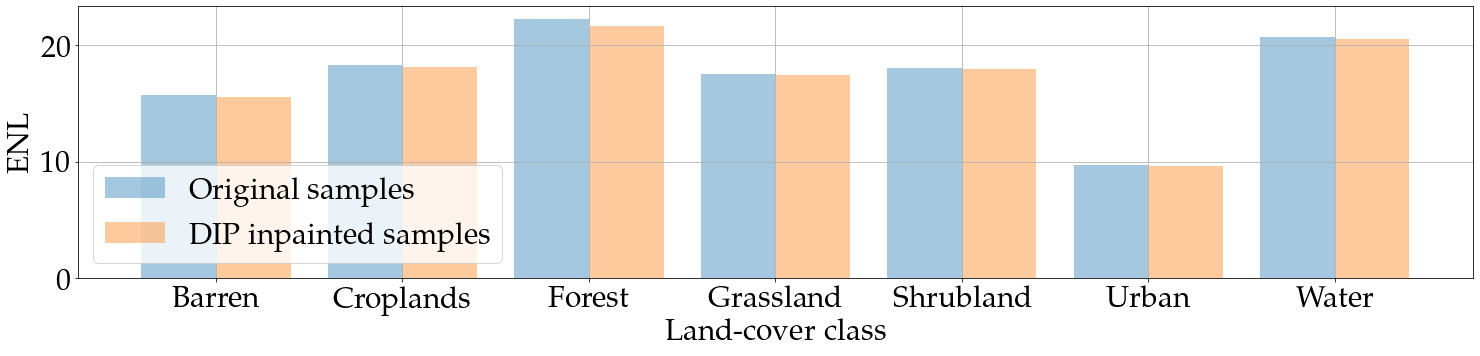

In [24]:
mean_df = enl_results.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30

for pol in ['VV', 'VH']:
    # Plot ENL for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(25, 5))
    X_axis = np.arange(len(mean_df.index))
    orig_recs = axs.bar(X_axis - 0.2, mean_df[f'ENL_{pol}_orig'], 0.4, label = 'Original samples', alpha=0.4)
    gen_recs = axs.bar(X_axis + 0.2, mean_df[f'ENL_{pol}_gen'], 0.4, label = 'DIP inpainted samples', alpha=0.4)

    axs.set_xticks(X_axis)
    axs.set_xticklabels(mean_df.index)
    axs.tick_params('both', labelsize=fsize)
    axs.set_xlabel("Land-cover class", fontsize=fsize)        
    axs.set_ylabel("ENL", fontsize=fsize)
    axs.legend(fontsize=fsize, loc='lower left')
    axs.grid()

#### Plot the relative difference between ENL of Original and Generated images

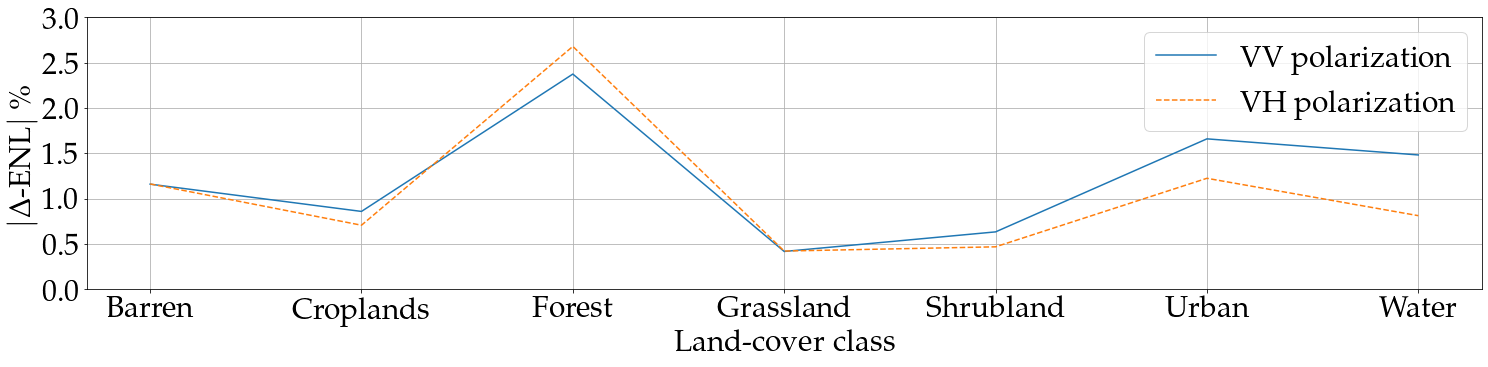

In [26]:
mean_df = enl_results.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30
plt.figure(figsize=(25, 5))
axs = plt.gca()
linestyles = ['-', '--']
for pol_idx, pol in enumerate(['VV', 'VH']):    
    axs.plot(np.arange(len(mean_df.index)), ((mean_df[f'ENL_{pol}_orig'] - mean_df[f'ENL_{pol}_gen'])/mean_df[f'ENL_{pol}_orig'])*100 , linestyles[pol_idx], label='{} polarization'.format(pol))

axs.set_xticks(X_axis)
axs.set_xticklabels(mean_df.index)
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)        
axs.legend(fontsize=fsize)
axs.set_ylim([0, 3])
axs.set_yticks(np.arange(0, 3.1, .5))
axs.set_ylabel("$|{\Delta}$-ENL$|$ \%", fontsize=fsize)
plt.grid()
plt.show()

#### Let's try it as a Bar plot

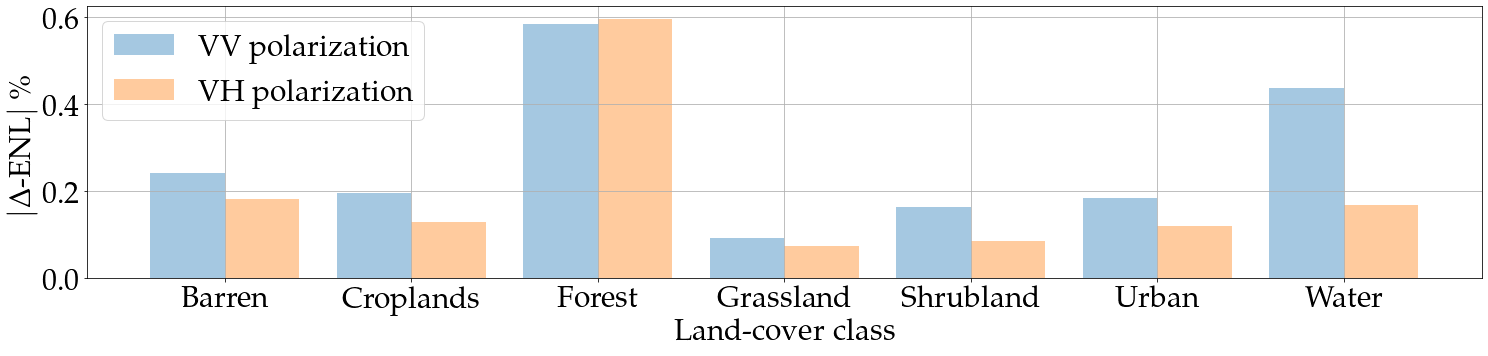

In [28]:
mean_df = enl_results.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30

fig, axs = plt.subplots(1, 1, figsize=(25, 5))
X_axis = np.arange(len(mean_df.index))
orig_recs = axs.bar(X_axis - 0.2, (mean_df[f'ENL_VV_orig'] - mean_df[f'ENL_VV_gen']), 0.4, label = 'VV polarization', alpha=0.4)
gen_recs = axs.bar(X_axis + 0.2, (mean_df[f'ENL_VH_orig'] - mean_df[f'ENL_VH_gen']), 0.4, label = 'VH polarization', alpha=0.4)

axs.set_xticks(X_axis)
axs.set_xticklabels(mean_df.index)
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)          
axs.set_ylabel("$|{\Delta}$-ENL$|$ \%", fontsize=fsize)
axs.legend(fontsize=fsize, loc='upper left')
axs.grid()

### Only Inpainted Area (OIA) scenario
To focus only on the target area, we can follow different ways. In the end the conclusions are similar, but you can refer directly to Method 3 for the solution we adopted in the paper.

#### Method 1
We consider in the computation of mean and STD only the pixels inside the target area.

In [72]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['ENL_VV_orig'] = np.nan
results_df['ENL_VH_orig'] = np.nan
results_df['ENL_VV_gen'] = np.nan
results_df['ENL_VH_gen'] = np.nan


# Prepare the execution parameters
pe = PatchExtractor((25, 25))

# Computation loop
# We need to load each sample, divide it into 25x25 non-overlapping patches, and compute the ENL

for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    samples = results_df.loc[lc_class]
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = mask!=255
        mask_patches = pe.extract(mask).reshape((-1, 25, 25))
        if pol_bands == 'VVVH':
                
            # ENL modification: ENL = [mean(patch^2)]^2/[std(patch^2)]^2  
            # Original VV
            patches = pe.extract(decibel_to_linear(orig[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, i), 'ENL_VV_orig'] = np.nanmean([np.mean(patch[mask_patches[idx]])**2/(np.nanstd(patch[mask_patches[idx]])**2+1e-10) for idx, patch in enumerate(patches)])  # we consider the mean ENL for each image
            
            # Original VH
            patches = pe.extract(decibel_to_linear(orig[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, i), 'ENL_VH_orig'] = np.nanmean([np.nanmean(patch[mask_patches[idx]])**2/(np.nanstd(patch[mask_patches[idx]])**2+1e-10) for idx, patch in enumerate(patches)])  # we consider the mean ENL for each image
            
            # Generated VV
            patches = pe.extract(decibel_to_linear(gen[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, i), 'ENL_VV_gen'] = np.nanmean([np.nanmean(patch[mask_patches[idx]])**2/(np.nanstd(patch[mask_patches[idx]])**2+1e-10) for idx, patch in enumerate(patches)])  # we consider the mean ENL for each image
            
            # Generated VH
            patches = pe.extract(decibel_to_linear(gen[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            results_df.loc[(lc_class, i), 'ENL_VH_gen'] = np.nanmean([np.nanmean(patch[mask_patches[idx]])**2/(np.nanstd(patch[mask_patches[idx]])**2+1e-10) for idx, patch in enumerate(patches)])  # we consider the mean ENL for each image    
    
# displaying the DataFrame
results_df[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]

/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/nas/home/ecannas/miniconda3/envs/sar-dip-inpainting/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


ENL_VV_orig  ENL_VH_orig  ENL_VV_gen  ENL_VH_gen
Classes                                                      
Barren  0      23.466720    19.895914    8.865896    6.247213
        1       9.542303     9.881499   10.309756   11.617042
        2      15.726719    15.793459   20.912136   13.384404
        3      16.760861    14.308356    9.861045    8.304918
        4      25.840767    20.084433   13.211057    9.623970
...                  ...          ...         ...         ...
Urban   395    21.835382    21.122113    9.703788    7.779581
        396     9.004311     7.115832   11.722455   12.716526
        397    14.400572    15.631882   12.714990    9.579847
        398     7.279513     5.518868    6.263952    3.301465
        399    12.470007    11.236906    8.625109    7.116346

[2772 rows x 4 columns]

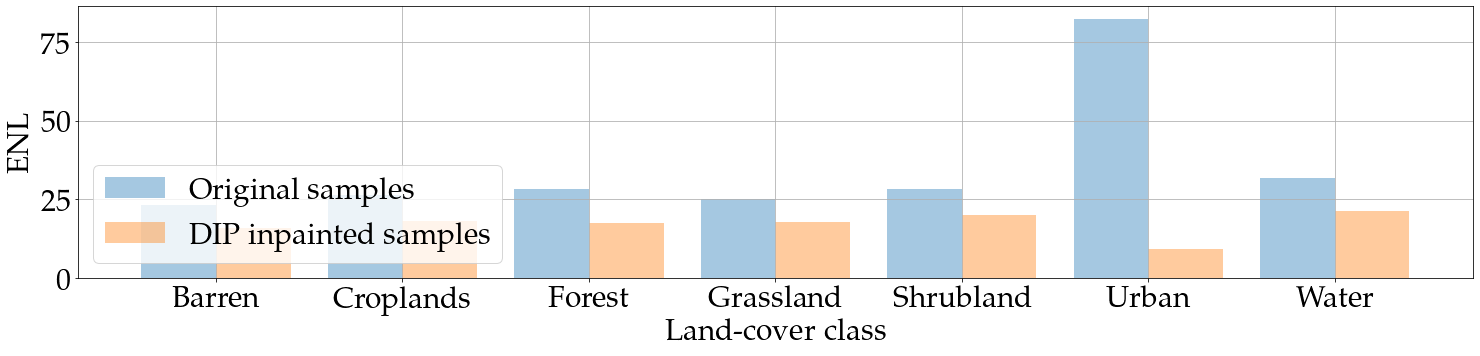

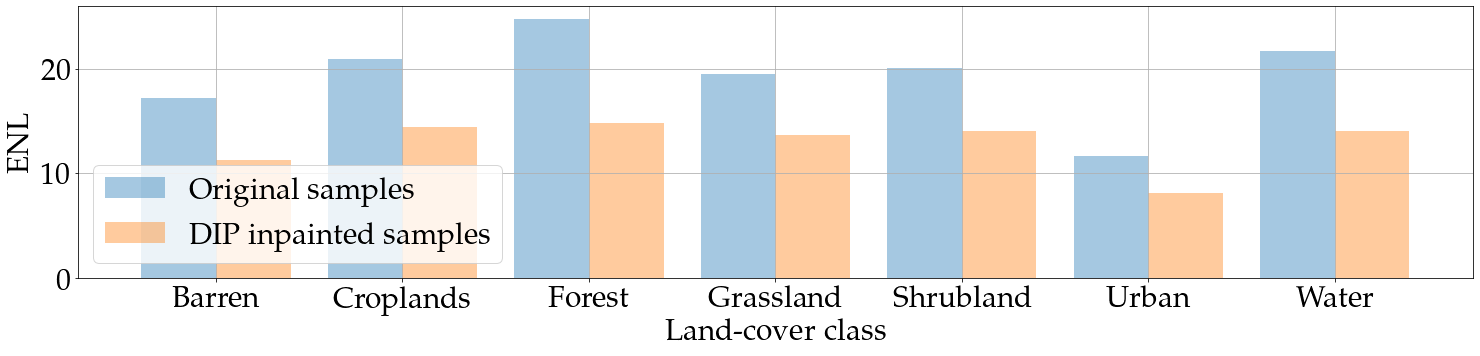

In [73]:
mean_df = results_df.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30

for pol in ['VV', 'VH']:
    # Plot ENL for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(25, 5))
    X_axis = np.arange(len(mean_df.index))
    orig_recs = axs.bar(X_axis - 0.2, mean_df[f'ENL_{pol}_orig'], 0.4, label = 'Original samples', alpha=0.4)
    gen_recs = axs.bar(X_axis + 0.2, mean_df[f'ENL_{pol}_gen'], 0.4, label = 'DIP inpainted samples', alpha=0.4)

    axs.set_xticks(X_axis)
    axs.set_xticklabels(mean_df.index)
    axs.tick_params('both', labelsize=fsize)
    axs.set_xlabel("Land-cover class", fontsize=fsize)        
    axs.set_ylabel("ENL", fontsize=fsize)
    axs.legend(fontsize=fsize, loc='lower left')
    axs.grid()

#### Method 2
We put the pixels of the images outside the target region equal to 0.

In [74]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['ENL_VV_orig'] = np.nan
results_df['ENL_VH_orig'] = np.nan
results_df['ENL_VV_gen'] = np.nan
results_df['ENL_VH_gen'] = np.nan


# Prepare the execution parameters
pe = PatchExtractor((25, 25))

# Computation loop
# We need to load each sample, divide it into 25x25 non-overlapping patches, and compute the ENL

for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    samples = results_df.loc[lc_class]
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = mask!=255
        mask_patches = pe.extract(mask).reshape((-1, 25, 25))
        if pol_bands == 'VVVH':
                
            # ENL modification: ENL = [mean(patch^2)]^2/[std(patch^2)]^2  
            # Original VV
            patches = pe.extract(decibel_to_linear(orig[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            patches[~mask_patches] = 0
            results_df.loc[(lc_class, i), 'ENL_VV_orig'] = np.nanmean([np.nanmean(patch)**2/(np.nanstd(patch)**2+1e-10) for patch in patches])  # we consider the mean ENL for each image
            
            # Original VH
            patches = pe.extract(decibel_to_linear(orig[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            patches[~mask_patches] = 0
            results_df.loc[(lc_class, i), 'ENL_VH_orig'] = np.nanmean([(np.nanmean(patch)/(np.nanstd(patch)+1e-10))**2 for patch in patches])  # we consider the mean ENL for each image
            
            # Generated VV
            patches = pe.extract(decibel_to_linear(gen[0])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            patches[~mask_patches] = 0
            results_df.loc[(lc_class, i), 'ENL_VV_gen'] = np.nanmean([(np.nanmean(patch)/(np.nanstd(patch)+1e-10))**2 for patch in patches])  # we consider the mean ENL for each image
            
            # Generated VH
            patches = pe.extract(decibel_to_linear(gen[1])).reshape((-1, 25, 25))**2 # need to compute the intensity from the GRD samples
            patches[~mask_patches] = 0
            results_df.loc[(lc_class, i), 'ENL_VH_gen'] = np.nanmean([(np.nanmean(patch)/(np.nanstd(patch)+1e-10))**2 for patch in patches])  # we consider the mean ENL for each image
                
    
# displaying the DataFrame
results_df[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]

ENL_VV_orig  ENL_VH_orig  ENL_VV_gen  ENL_VH_gen
Classes                                                      
Barren  0       0.552614     0.525337    0.255162    0.221515
        1       0.297834     0.319226    0.330310    0.255049
        2       0.408300     0.332715    0.640682    0.405332
        3       0.404654     0.416704    0.298248    0.272586
        4       0.663776     0.569020    0.344159    0.296963
...                  ...          ...         ...         ...
Urban   395     0.725810     0.667613    0.301184    0.259935
        396     0.240514     0.203631    0.465584    0.422450
        397     0.365349     0.283480    0.322606    0.280312
        398     0.265913     0.222977    0.246627    0.149226
        399     0.321654     0.249236    0.346813    0.219284

[2772 rows x 4 columns]

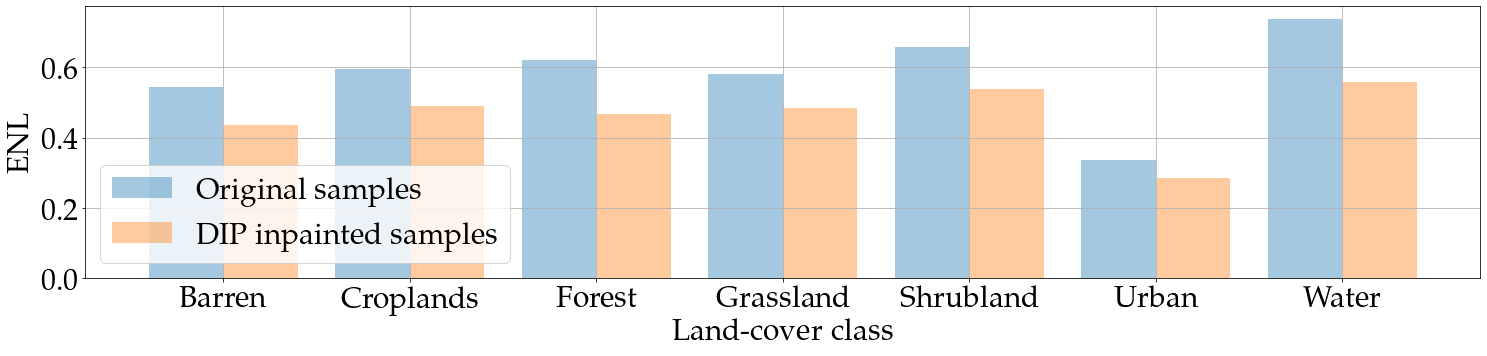

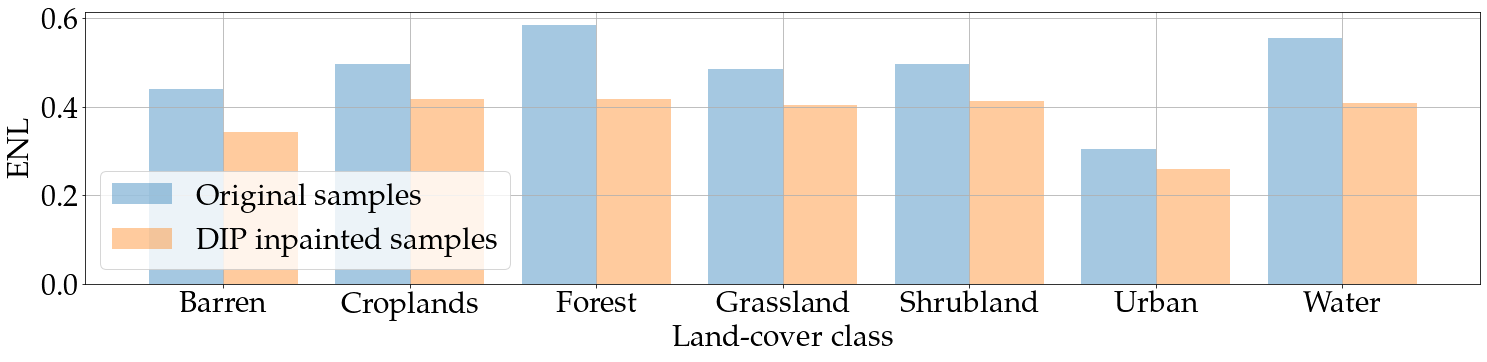

In [75]:
mean_df = results_df.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30

for pol in ['VV', 'VH']:
    # Plot ENL for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(25, 5))
    X_axis = np.arange(len(mean_df.index))
    orig_recs = axs.bar(X_axis - 0.2, mean_df[f'ENL_{pol}_orig'], 0.4, label = 'Original samples', alpha=0.4)
    gen_recs = axs.bar(X_axis + 0.2, mean_df[f'ENL_{pol}_gen'], 0.4, label = 'DIP inpainted samples', alpha=0.4)

    axs.set_xticks(X_axis)
    axs.set_xticklabels(mean_df.index)
    axs.tick_params('both', labelsize=fsize)
    axs.set_xlabel("Land-cover class", fontsize=fsize)        
    axs.set_ylabel("ENL", fontsize=fsize)
    axs.legend(fontsize=fsize, loc='lower left')
    axs.grid()

#### Method 3
Compute the ENL for all the patches, build an "ENL image" by assign the ENL patches' values to all the pixels belonging to the patches respectively, and then compute the mean for the image ignoring the pixels outside the target region.  
**This is the method considered in the paper.**

In [78]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['ENL_VV_orig'] = np.nan
results_df['ENL_VH_orig'] = np.nan
results_df['ENL_VV_gen'] = np.nan
results_df['ENL_VH_gen'] = np.nan


# Prepare the execution parameters
pe = PatchExtractor((25, 25), padding='symmetric')

# Computation loop
# We need to load each sample, divide it into 25x25 non-overlapping patches, and compute the ENL

for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    samples = enl_results.loc[lc_class]
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = (mask-mask.min())/(mask.max()-mask.min())
        mask -= 1
        mask *= -1
        if pol_bands == 'VVVH':
            
            # Original VV
            patches = pe.extract(decibel_to_linear(orig[0]))
            orig_shape = patches.shape
            patches = patches.reshape((-1, 25, 25))**2# need to compute the intensity from the GRD samples
            ENL_list = np.array([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # compute ENL
            ENL_img = pe.reconstruct((np.ones_like(patches)*ENL_list[:, np.newaxis, np.newaxis]).reshape(orig_shape))  # re-assemble the patches to obtain an "ENL image"
            ENL_img *= mask  # discard the pixels not in the inpainted area
            results_df.loc[(lc_class, i), 'ENL_VV_orig'] = np.mean(ENL_img.flatten())  # we consider the mean ENL for each image
            
            # Original VH
            patches = pe.extract(decibel_to_linear(orig[1]))
            orig_shape = patches.shape
            patches = patches.reshape((-1, 25, 25))**2# need to compute the intensity from the GRD samples
            ENL_list = np.array([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # compute ENL
            ENL_img = pe.reconstruct((np.ones_like(patches)*ENL_list[:, np.newaxis, np.newaxis]).reshape(orig_shape))  # re-assemble the patches to obtain an "ENL image"
            ENL_img *= mask  # discard the pixels not in the inpainted area
            results_df.loc[(lc_class, i), 'ENL_VH_orig'] = np.mean(ENL_img.flatten())  # we consider the mean ENL for each image
            
            # Generated VV
            patches = pe.extract(decibel_to_linear(gen[0]))
            orig_shape = patches.shape
            patches = patches.reshape((-1, 25, 25))**2# need to compute the intensity from the GRD samples
            ENL_list = np.array([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # compute ENL
            ENL_img = pe.reconstruct((np.ones_like(patches)*ENL_list[:, np.newaxis, np.newaxis]).reshape(orig_shape))  # re-assemble the patches to obtain an "ENL image"
            ENL_img *= mask  # discard the pixels not in the inpainted area
            results_df.loc[(lc_class, i), 'ENL_VV_gen'] = np.mean(ENL_img.flatten())  # we consider the mean ENL for each image
            
            # Generated VH
            patches = pe.extract(decibel_to_linear(gen[1]))
            orig_shape = patches.shape
            patches = patches.reshape((-1, 25, 25))**2# need to compute the intensity from the GRD samples
            ENL_list = np.array([np.mean(patch)**2/(np.std(patch)**2+1e-10) for patch in patches])  # compute ENL
            ENL_img = pe.reconstruct((np.ones_like(patches)*ENL_list[:, np.newaxis, np.newaxis]).reshape(orig_shape))  # re-assemble the patches to obtain an "ENL image"
            ENL_img *= mask  # discard the pixels not in the inpainted area
            results_df.loc[(lc_class, i), 'ENL_VH_gen'] = np.mean(ENL_img.flatten())  # we consider the mean ENL for each image
                
    
# displaying the DataFrame
results_df[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]

ENL_VV_orig  ENL_VH_orig  ENL_VV_gen  ENL_VH_gen
Classes                                                      
Barren  0       1.131447     1.053397    0.532121    0.459865
        1       0.490596     0.524729    0.558143    0.500627
        2       0.793400     0.797391    1.107876    0.822880
        3       0.905780     0.857560    0.554344    0.558599
        4       1.375762     1.122167    0.799400    0.595716
...                  ...          ...         ...         ...
Urban   395     1.136948     1.216868    0.598145    0.522582
        396     0.465142     0.393615    0.749928    0.730626
        397     0.799089     0.640785    0.670334    0.544638
        398     0.416830     0.304311    0.412026    0.212096
        399     0.642792     0.451020    0.626848    0.396487

[2772 rows x 4 columns]

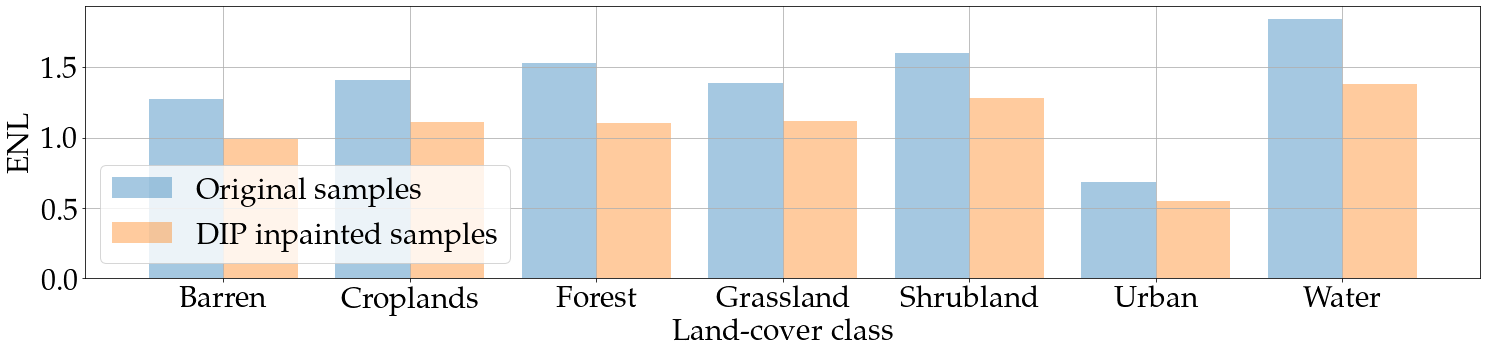

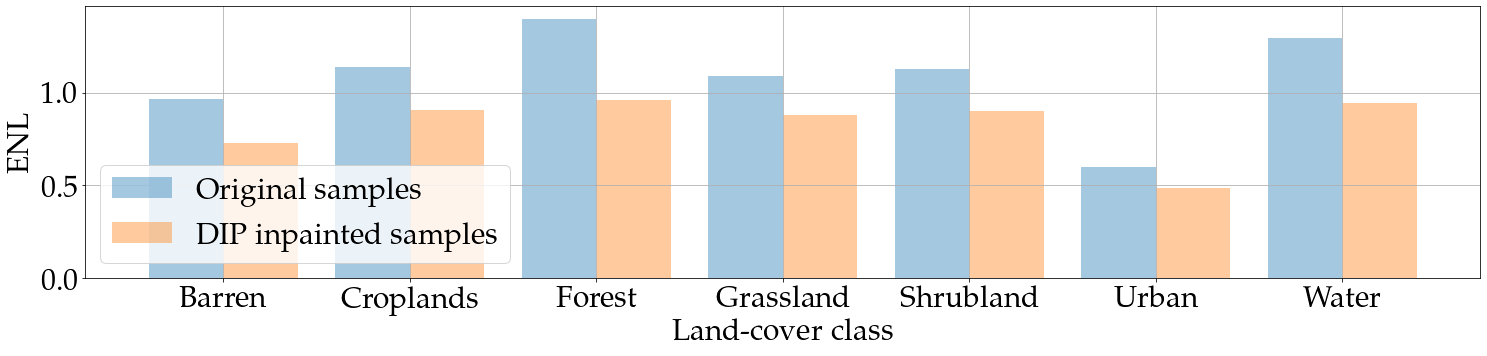

In [79]:
mean_df = results_df.groupby('Classes').mean()[['ENL_VV_orig', 'ENL_VH_orig', 'ENL_VV_gen', 'ENL_VH_gen']]
fsize = 30

for pol in ['VV', 'VH']:
    # Plot ENL for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(25, 5))
    X_axis = np.arange(len(mean_df.index))
    orig_recs = axs.bar(X_axis - 0.2, mean_df[f'ENL_{pol}_orig'], 0.4, label = 'Original samples', alpha=0.4)
    gen_recs = axs.bar(X_axis + 0.2, mean_df[f'ENL_{pol}_gen'], 0.4, label = 'DIP inpainted samples', alpha=0.4)

    axs.set_xticks(X_axis)
    axs.set_xticklabels(mean_df.index)
    axs.tick_params('both', labelsize=fsize)
    axs.set_xlabel("Land-cover class", fontsize=fsize)        
    axs.set_ylabel("ENL", fontsize=fsize)
    axs.legend(fontsize=fsize, loc='lower left')
    axs.grid()

### Edge Preservation Index (EPI)
[Reference](https://ieeexplore.ieee.org/abstract/document/1026581?casa_token=sWhprwlIpcUAAAAA:IzsshzgJUc4HmdIQphav6w735wJzREz9idv-dQ-8Fyh6do0UBcMkLb1Io8GpXxvMAf_37GnK)

#### Full Image scenario (FI)

In [91]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['EPI_VV'] = np.nan
results_df['EPI_VH'] = np.nan


# Computation loop
for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    samples = results_df.loc[(lc_class)]
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = (mask-mask.min())/(mask.max()-mask.min())
        mask -= 1
        mask *= -1
        if pol_bands == 'VVVH':
            
            # VV polarization
            deltas = laplace(orig[0])
            meandeltas = np.mean(deltas)
            deltascap = laplace(gen[0])
            meandeltascap = np.mean(deltascap)
            p1=deltas-meandeltas
            p2=deltascap-meandeltascap
            num=(np.sum(p1*p2))
            den=((np.sum(p1**2)))*((np.sum(p2**2)))
            epi=num/np.sqrt(den)
            results_df.loc[(lc_class, i), 'EPI_VV'] = epi
            
            # VH polarization
            deltas = laplace(orig[1])
            meandeltas = np.mean(deltas)
            deltascap = laplace(gen[1])
            meandeltascap = np.mean(deltascap)
            p1=deltas-meandeltas
            p2=deltascap-meandeltascap
            num=(np.sum(p1*p2))
            den=((np.sum(p1**2)))*((np.sum(p2**2)))
            epi=num/np.sqrt(den)
            results_df.loc[(lc_class, i), 'EPI_VH'] = epi
                
    
# displaying the DataFrame
results_df[['EPI_VV', 'EPI_VH']]

EPI_VV    EPI_VH
Classes                        
Barren  0    0.631201  0.614536
        1    0.567880  0.586025
        2    0.616263  0.642018
        3    0.693958  0.703524
        4    0.621726  0.580707
...               ...       ...
Urban   395  0.677502  0.704847
        396  0.657919  0.642667
        397  0.612062  0.649755
        398  0.721223  0.723197
        399  0.648736  0.675618

[2772 rows x 2 columns]

In [92]:
mean_df_fi = results_df.groupby('Classes').mean()[['EPI_VV', 'EPI_VH']]
mean_df_fi

EPI_VV    EPI_VH
Classes                      
Barren     0.640106  0.628021
Croplands  0.659389  0.663254
Forest     0.677654  0.677580
Grassland  0.653921  0.659862
Shrubland  0.659845  0.660840
Urban      0.676603  0.686100
Water      0.623670  0.605302

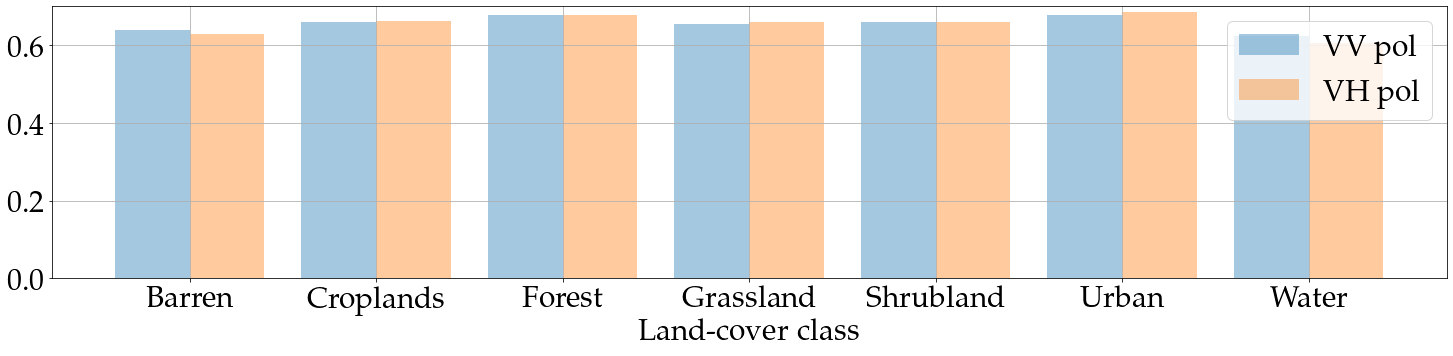

In [93]:
fsize = 30
# Plot EPI for each class as a bar plot
fig, axs = plt.subplots(1, 1, figsize=(25, 5))
X_axis = np.arange(len(mean_df_fi.index))
orig_recs = axs.bar(X_axis - 0.2, mean_df_fi[f'EPI_VV'], 0.4, label = 'VV pol', alpha=0.4)
gen_recs = axs.bar(X_axis + 0.2, mean_df_fi[f'EPI_VH'], 0.4, label = 'VH pol', alpha=0.4)

# Customize the plot
axs.set_xticks(X_axis)
axs.set_xticklabels(mean_df.index)
axs.set_ylim([0, 0.7])
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)        
axs.legend(fontsize=fsize)
axs.grid()
plt.show()

### Only Inpainted Area (OIA) scenario

In [94]:
# Prepare the results DataFrame
results_df = all_dfs.copy()
results_df['EPI_VV_target'] = np.nan
results_df['EPI_VH_target'] = np.nan


# Computation loop
for lc_class in all_dfs.index.unique(level=0):
    
    # Take the samples for the single class we are considering
    samples = results_df.loc[(lc_class)]
    
    # Cycle over the samples
    for idx, (i, sample) in enumerate(samples.iterrows()):
        pol_bands = sample['Polarization_bands']
        
        bands = [0, 1]
        orig, gen, inp, mask = Normalize()(load_SEN12MS_s1_raster_no_clip(sample['path_s1'], True))[bands].numpy(), np.load(sample['Final_generated_sample_path']), np.load(sample['Final_inpainted_sample_path']), np.load(sample['Inpainting_mask_path'])
        mask = (mask-mask.min())/(mask.max()-mask.min())
        mask = mask.astype(np.bool)
        
        if pol_bands == 'VVVH':
            
            # VV polarization
            deltas = laplace(orig[0][mask])  # we'll consider only pixels inside the target region
            meandeltas = np.mean(deltas)
            deltascap = laplace(gen[0][mask])
            meandeltascap = np.mean(deltascap)
            p1=deltas-meandeltas
            p2=deltascap-meandeltascap
            num=(np.sum(p1*p2))
            den=((np.sum(p1**2)))*((np.sum(p2**2)))
            epi=num/np.sqrt(den)
            results_df.loc[(lc_class, i), 'EPI_VV_target'] = epi
            
            # VH polarization
            deltas = laplace(orig[1][mask])
            meandeltas = np.mean(deltas)
            deltascap = laplace(gen[1][mask])
            meandeltascap = np.mean(deltascap)
            p1=deltas-meandeltas
            p2=deltascap-meandeltascap
            num=(np.sum(p1*p2))
            den=((np.sum(p1**2)))*((np.sum(p2**2)))
            epi=num/np.sqrt(den)
            results_df.loc[(lc_class, i), 'EPI_VH_target'] = epi
                
    
# displaying the DataFrame
results_df[['EPI_VV_target', 'EPI_VH_target']]

EPI_VV_target  EPI_VH_target
Classes                                  
Barren  0         0.678425       0.653718
        1         0.660833       0.665542
        2         0.677429       0.677353
        3         0.776319       0.778055
        4         0.668204       0.617277
...                    ...            ...
Urban   395       0.723689       0.730828
        396       0.715871       0.690934
        397       0.689899       0.699348
        398       0.769868       0.767640
        399       0.738218       0.761922

[2772 rows x 2 columns]

In [95]:
mean_df_oia = results_df.groupby('Classes').mean()[['EPI_VV_target', 'EPI_VH_target']]
mean_df_oia

EPI_VV_target  EPI_VH_target
Classes                                
Barren          0.711534       0.690589
Croplands       0.729369       0.730866
Forest          0.761035       0.756314
Grassland       0.730110       0.725510
Shrubland       0.728625       0.725713
Urban           0.751124       0.754783
Water           0.690414       0.661086

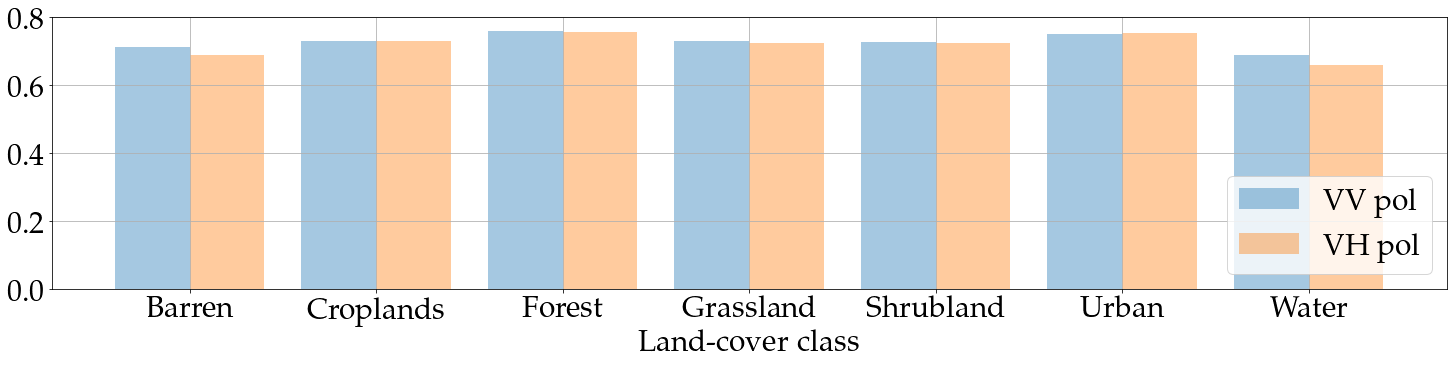

In [96]:
fsize = 30
# Plot EPI for each class as a bar plot
fig, axs = plt.subplots(1, 1, figsize=(25, 5))
X_axis = np.arange(len(mean_df.index))
orig_recs = axs.bar(X_axis - 0.2, mean_df_oia[f'EPI_VV_target'], 0.4, label = 'VV pol', alpha=0.4)
gen_recs = axs.bar(X_axis + 0.2, mean_df_oia[f'EPI_VH_target'], 0.4, label = 'VH pol', alpha=0.4)

axs.set_xticks(X_axis)
axs.set_xticklabels(mean_df.index)
axs.set_ylim([0, 0.8])
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)        
#plt.title(f"EPI comparison, original VS DIP generated", fontsize=fsize+5)
axs.legend(fontsize=fsize, loc='lower right')
axs.grid()
#plt.show()
plt.savefig("sar_quality_epi_metric_oia_bar.pdf", dpi=300, bbox_inches = 'tight')  

### EPI comparison among different polarizations and OIA and FI scenarios

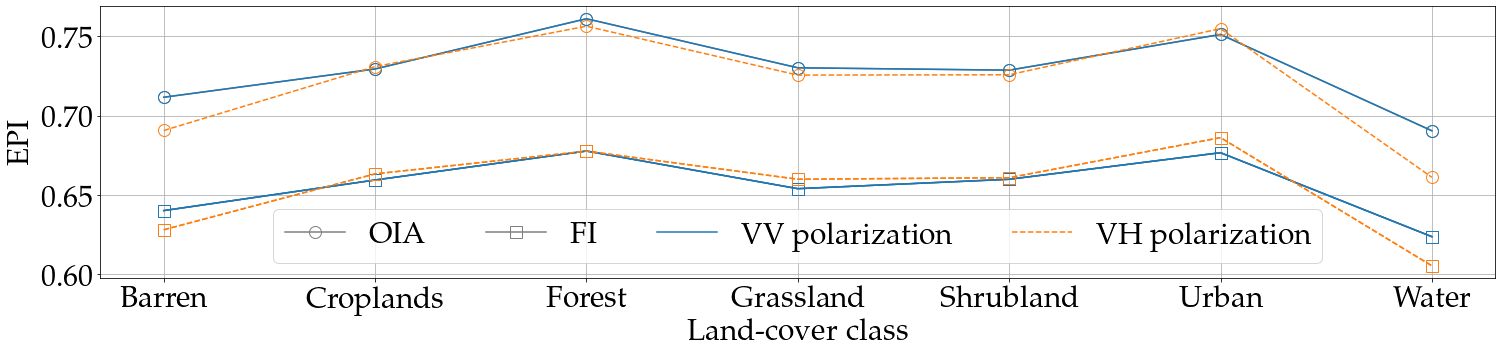

In [97]:
fsize = 30
plt.figure(figsize=(25, 5))
axs = plt.gca()
linestyles = ['s-', 'o-']
markersize = 12
axs.plot(np.arange(len(mean_df_oia.index)), mean_df_oia[f'EPI_VV_target'], linestyles[1], label='OIA', color='tab:gray', markersize=markersize, fillstyle='none')
axs.plot(np.arange(len(mean_df_fi.index)), mean_df[f'EPI_VV'], linestyles[0], label='FI', color='tab:gray', markersize=markersize, fillstyle='none')
axs.plot(np.arange(len(mean_df_fi.index)), mean_df[f'EPI_VV'], '-', label='VV polarization', color='tab:blue', )
axs.plot(np.arange(len(mean_df_oia.index)), mean_df[f'EPI_VH'], '--', label='VH polarization', color='tab:orange')
axs.plot(np.arange(len(mean_df_fi.index)), mean_df[f'EPI_VV'], 's-', color='tab:blue', markersize=markersize, fillstyle='none')
axs.plot(np.arange(len(mean_df_fi.index)), mean_df_oia[f'EPI_VV_target'], 'o-', color='tab:blue', markersize=markersize, fillstyle='none')
axs.plot(np.arange(len(mean_df_oia.index)), mean_df[f'EPI_VH'], 's--', color='tab:orange', markersize=markersize, fillstyle='none')
axs.plot(np.arange(len(mean_df_oia.index)), mean_df_oia[f'EPI_VH_target'], 'o--', color='tab:orange', markersize=markersize, fillstyle='none')
axs.set_xticks(X_axis)
axs.set_xticklabels(mean_df.index)
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)        
axs.legend(fontsize=fsize, ncol=len(df.columns))
axs.set_ylabel("EPI", fontsize=fsize)
plt.grid()
plt.show()

## CNN-semantic metrics
<a id='cnn_semantic'></a>

### Execution parameters

In [59]:
lc_class_model_paths = ['landcover_classification_models/InceptionV3_best_weights.pth',
                        'landcover_classification_models/ResNet50_best_weights.pth',
                        'landcover_classification_models/EfficientNetB0_best_weights.pth',]
n_inputs = 2
numCls = 10
gpu = 5
device = f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu'
features_or = {model_path.split('/')[-1].split('_')[0]: dict() for model_path in lc_class_model_paths}
features_gen = {model_path.split('/')[-1].split('_')[0]: dict() for model_path in lc_class_model_paths}

### Let's first process all the images with a network trained for a land-cover classification task

#### InceptionV3

##### Model loading

In [60]:
model_path = lc_class_model_paths[0]
model_name = model_path.split('/')[-1].split('_')[0]

# Avoid loading the model if the features are already computed
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')) and os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    print('Features are already computed! Not loading the model.')
else:
    # define model
    
    # --- VGGs --- #
    if model_name == 'VGG16':
        model = VGG16(n_inputs, numCls)
    elif model_name == 'VGG19':
        model = VGG19(n_inputs, numCls)
    elif model_name == 'ResNet50':
        model = ResNet50(n_inputs, numCls)
    elif model_name == 'ResNet101':
        model = ResNet101(n_inputs, numCls)
    elif model_name == 'ResNet152':
        model = ResNet152(n_inputs, numCls)
    # --- DenseNets --- #
    elif model_name == 'DenseNet121':
        model = DenseNet121(n_inputs, numCls)
    elif model_name == 'DenseNet161':
        model = DenseNet161(n_inputs, numCls)
    elif model_name == 'DenseNet169':
        model = DenseNet169(n_inputs, numCls)
    elif model_name == 'DenseNet201':
        model = DenseNet201(n_inputs, numCls)
    # --- EfficietNets --- #
    elif model_name == 'EfficientNetB0':
        model = EfficientNetGen(model='efficientnet-b0', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    elif model_name == 'EfficientNetB4':
        model = EfficientNetGen(model='efficientnet-b4', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    # --- InceptionV3 --- #
    elif model_name == 'InceptionV3':
        model = ISPLInceptionV3(num_classes=numCls, in_channels=n_inputs, pretrained=False)
    else:
        raise NameError("no model")

    print("=> loading checkpoint '{}'".format(model_path))
    checkpoint = torch.load(model_path, map_location='cpu')
    checkpoint_nm = os.path.basename(model_path)
    sv_name = checkpoint_nm.split('_')[0] + '_' + checkpoint_nm.split('_')[1]
    print('saving file name is ', sv_name)

    best_acc = checkpoint['best_prec']
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}), best acc {:.4f}".format(checkpoint_nm, checkpoint['epoch'], checkpoint['best_prec']))

    # Set to evaluation
    model.eval()
    model.to(device)

Features are already computed! Not loading the model.


##### Let's compute the features

In [61]:
# --- ORIGINAL SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'rb') as src:
        features_or[model_name] = pickle.load(src)
    print('Features loaded!')
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_or = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=transforms.Compose([ToTensor(), Normalize(bands_mean, bands_std)]),
                                     label_type="single_label", threshold=0.1,
                                     load_or=True, load_gen=False, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_or[lc_class] = dict()
        features_dict_or[lc_class]['feats'] = np.concatenate(features)
        features_dict_or[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_or[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_or[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_or[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_or[lc_class]['labels'])/features_dict_or[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_or[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_or, dst)
    print('Features saved!')
    
    features_or[model_name] = features_dict_or.copy()


# --- DIP INPAINTED SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'rb') as src:
        features_gen[model_name] = pickle.load(src)
    print('Features loaded!')        
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_gen = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=ToTensor(),
                                     label_type="single_label", threshold=0.1,
                                     load_or=False, load_gen=True, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_gen[lc_class] = dict()
        features_dict_gen[lc_class]['feats'] = np.concatenate(features)
        features_dict_gen[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_gen[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_gen[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_gen[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_gen[lc_class]['labels'])/features_dict_gen[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_gen[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save extracted features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_gen, dst)
        print('Features saved!')
    # Put in bigger dictionary
    features_gen[model_name] = features_dict_gen.copy()

Features loaded!
Features loaded!


#### ResNet50

In [62]:
model_path = lc_class_model_paths[1]
model_name = model_path.split('/')[-1].split('_')[0]

# Avoid loading the model if the features are already computed
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')) and os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    print('Features are already computed! Not loading the model.')
else:
    # define model
    
    # --- VGGs --- #
    if model_name == 'VGG16':
        model = VGG16(n_inputs, numCls)
    elif model_name == 'VGG19':
        model = VGG19(n_inputs, numCls)
    elif model_name == 'ResNet50':
        model = ResNet50(n_inputs, numCls)
    elif model_name == 'ResNet101':
        model = ResNet101(n_inputs, numCls)
    elif model_name == 'ResNet152':
        model = ResNet152(n_inputs, numCls)
    # --- DenseNets --- #
    elif model_name == 'DenseNet121':
        model = DenseNet121(n_inputs, numCls)
    elif model_name == 'DenseNet161':
        model = DenseNet161(n_inputs, numCls)
    elif model_name == 'DenseNet169':
        model = DenseNet169(n_inputs, numCls)
    elif model_name == 'DenseNet201':
        model = DenseNet201(n_inputs, numCls)
    # --- EfficietNets --- #
    elif model_name == 'EfficientNetB0':
        model = EfficientNetGen(model='efficientnet-b0', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    elif model_name == 'EfficientNetB4':
        model = EfficientNetGen(model='efficientnet-b4', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    # --- InceptionV3 --- #
    elif model_name == 'InceptionV3':
        model = ISPLInceptionV3(num_classes=numCls, in_channels=n_inputs, pretrained=False)
    else:
        raise NameError("no model")

    print("=> loading checkpoint '{}'".format(model_path))
    checkpoint = torch.load(model_path, map_location='cpu')
    checkpoint_nm = os.path.basename(model_path)
    sv_name = checkpoint_nm.split('_')[0] + '_' + checkpoint_nm.split('_')[1]
    print('saving file name is ', sv_name)

    best_acc = checkpoint['best_prec']
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}), best acc {:.4f}".format(checkpoint_nm, checkpoint['epoch'], checkpoint['best_prec']))

    # Set to evaluation
    model.eval()
    model.to(device)

Features are already computed! Not loading the model.


##### Compute features

In [63]:
# --- ORIGINAL SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'rb') as src:
        features_or[model_name] = pickle.load(src)
    print('Features loaded!')
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_or = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=transforms.Compose([ToTensor(), Normalize(bands_mean, bands_std)]),
                                     label_type="single_label", threshold=0.1,
                                     load_or=True, load_gen=False, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_or[lc_class] = dict()
        features_dict_or[lc_class]['feats'] = np.concatenate(features)
        features_dict_or[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_or[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_or[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_or[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_or[lc_class]['labels'])/features_dict_or[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_or[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_or, dst)
    print('Features saved!')
    
    features_or[model_name] = features_dict_or.copy()


# --- DIP INPAINTED SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'rb') as src:
        features_gen[model_name] = pickle.load(src)
    print('Features loaded!')        
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_gen = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=ToTensor(),
                                     label_type="single_label", threshold=0.1,
                                     load_or=False, load_gen=True, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_gen[lc_class] = dict()
        features_dict_gen[lc_class]['feats'] = np.concatenate(features)
        features_dict_gen[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_gen[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_gen[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_gen[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_gen[lc_class]['labels'])/features_dict_gen[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_gen[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save extracted features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_gen, dst)
        print('Features saved!')
    # Put in bigger dictionary
    features_gen[model_name] = features_dict_gen.copy()

Features loaded!
Features loaded!


#### EfficientNetB0

In [64]:
model_path = lc_class_model_paths[2]
model_name = model_path.split('/')[-1].split('_')[0]

# Avoid loading the model if the features are already computed
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')) and os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    print('Features are already computed! Not loading the model.')
else:
    # define model
    
    # --- VGGs --- #
    if model_name == 'VGG16':
        model = VGG16(n_inputs, numCls)
    elif model_name == 'VGG19':
        model = VGG19(n_inputs, numCls)
    elif model_name == 'ResNet50':
        model = ResNet50(n_inputs, numCls)
    elif model_name == 'ResNet101':
        model = ResNet101(n_inputs, numCls)
    elif model_name == 'ResNet152':
        model = ResNet152(n_inputs, numCls)
    # --- DenseNets --- #
    elif model_name == 'DenseNet121':
        model = DenseNet121(n_inputs, numCls)
    elif model_name == 'DenseNet161':
        model = DenseNet161(n_inputs, numCls)
    elif model_name == 'DenseNet169':
        model = DenseNet169(n_inputs, numCls)
    elif model_name == 'DenseNet201':
        model = DenseNet201(n_inputs, numCls)
    # --- EfficietNets --- #
    elif model_name == 'EfficientNetB0':
        model = EfficientNetGen(model='efficientnet-b0', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    elif model_name == 'EfficientNetB4':
        model = EfficientNetGen(model='efficientnet-b4', n_classes=numCls,
                                in_channels=n_inputs, pretrained=False)
    # --- InceptionV3 --- #
    elif model_name == 'InceptionV3':
        model = ISPLInceptionV3(num_classes=numCls, in_channels=n_inputs, pretrained=False)
    else:
        raise NameError("no model")

    print("=> loading checkpoint '{}'".format(model_path))
    checkpoint = torch.load(model_path, map_location='cpu')
    checkpoint_nm = os.path.basename(model_path)
    sv_name = checkpoint_nm.split('_')[0] + '_' + checkpoint_nm.split('_')[1]
    print('saving file name is ', sv_name)

    best_acc = checkpoint['best_prec']
    model.load_state_dict(checkpoint['model_state_dict'])
    print("=> loaded checkpoint '{}' (epoch {}), best acc {:.4f}".format(checkpoint_nm, checkpoint['epoch'], checkpoint['best_prec']))

    # Set to evaluation
    model.eval()
    model.to(device)

Features are already computed! Not loading the model.


##### Let's compute the features

In [65]:
# --- ORIGINAL SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'rb') as src:
        features_or[model_name] = pickle.load(src)
    print('Features loaded!')
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_or = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=transforms.Compose([ToTensor(), Normalize(bands_mean, bands_std)]),
                                     label_type="single_label", threshold=0.1,
                                     load_or=True, load_gen=False, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_or[lc_class] = dict()
        features_dict_or[lc_class]['feats'] = np.concatenate(features)
        features_dict_or[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_or[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_or[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_or[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_or[lc_class]['labels'])/features_dict_or[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_or[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_original_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_or, dst)
    print('Features saved!')
    
    features_or[model_name] = features_dict_or.copy()


# --- DIP INPAINTED SAMPLES ---#

# Check if features have already been computed, otherwise process them #
if os.path.exists(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl')):
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'rb') as src:
        features_gen[model_name] = pickle.load(src)
    print('Features loaded!')        
else:
    batch_size = 64

    ## Features extraction

    # Parameters needed
    bands_mean = {'s1_mean': [-11.76858, -18.294598],
                  's2_mean': [1226.4215, 1137.3799, 1139.6792, 1350.9973, 1932.9058,
                              2211.1584, 2154.9846, 2409.1128, 2001.8622, 1356.0801]}

    bands_std = {'s1_std': [4.525339, 4.3586307],
                 's2_std': [741.6254, 740.883, 960.1045, 946.76056, 985.52747,
                            1082.4341, 1057.7628, 1136.1942, 1132.7898, 991.48016]}
    ls_dir = '../landcover_classification/labels'

    # Pre-allocate dictionary for results
    features_dict_gen = dict()

    # Cycle over all classes
    for lc_class in all_dfs.index.get_level_values(0).unique():
        print(f'Doing samples of class {lc_class}...')

        # Prepare DataFrame and Dataloader
        df = all_dfs.loc[lc_class, 'ssim + mse'].drop_duplicates() 
        df = df.loc[df.index.get_level_values(0).unique()]
        df['id'] = df['path_s1'].apply(lambda x: x.split('/')[-1].replace('_s1_', '_s2_').replace('_lc_', '_s2_'))  # add ID to all tiles
        df = df.set_index(['id', 'sensor_s1'], drop=True).drop_duplicates() # set new index
        dataset = SEN12MS_inpainting(ls_dir=ls_dir, imgTransform=ToTensor(),
                                     label_type="single_label", threshold=0.1,
                                     load_or=False, load_gen=True, load_inp=False, IGBP_s=True, data_df=df)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8,
                                                 pin_memory=True)

        # Cycle over all samples
        features, pre_logits, labels_arr = [], [], []
        for data in tqdm(dataloader, desc='Testing'):
            labels = (torch.max(data["label"], 1)[1]).type(torch.long)
            bands = data['image']
            if torch.cuda.is_available():
                labels, bands = labels.to(device), bands.to(device)
            with torch.no_grad():
                feats = model.features(bands)
                pre_logit = model.inception.fc(feats)
    #             pred, acc = multi_acc_and_preds_1_vs_rest(pre_logit, labels)
            features.append(feats.detach().cpu().numpy())
            pre_logits.append(pre_logit.detach().cpu().numpy())
            labels_arr.append(labels.detach().cpu().numpy())

        # Save the results
        features_dict_gen[lc_class] = dict()
        features_dict_gen[lc_class]['feats'] = np.concatenate(features)
        features_dict_gen[lc_class]['pre_logits'] = np.concatenate(pre_logits)
        features_dict_gen[lc_class]['labels'] = np.concatenate(labels_arr)
        features_dict_gen[lc_class]['acc'] = np.sum(np.argmax(softmax(features_dict_gen[lc_class]['pre_logits'], axis=1), axis=1)==features_dict_gen[lc_class]['labels'])/features_dict_gen[lc_class]['pre_logits'].shape[0]

        print('Computation done! Mean accuracy is {:.4f}'.format(features_dict_gen[lc_class]['acc']))

    # Clear GPU memory
    torch.cuda.empty_cache()
    
    # Save extracted features
    with open(os.path.join('landcover_classification_models', 'extracted_features', f'{model_name}_DIP_generated_features.pkl'), 'wb') as dst:
        pickle.dump(features_dict_gen, dst)
        print('Features saved!')
    # Put in bigger dictionary
    features_gen[model_name] = features_dict_gen.copy()

Features loaded!
Features loaded!


### Confusion matrices

#### InceptionV3

###### Original samples

(6.5, -0.5) (-0.5, 7.5)


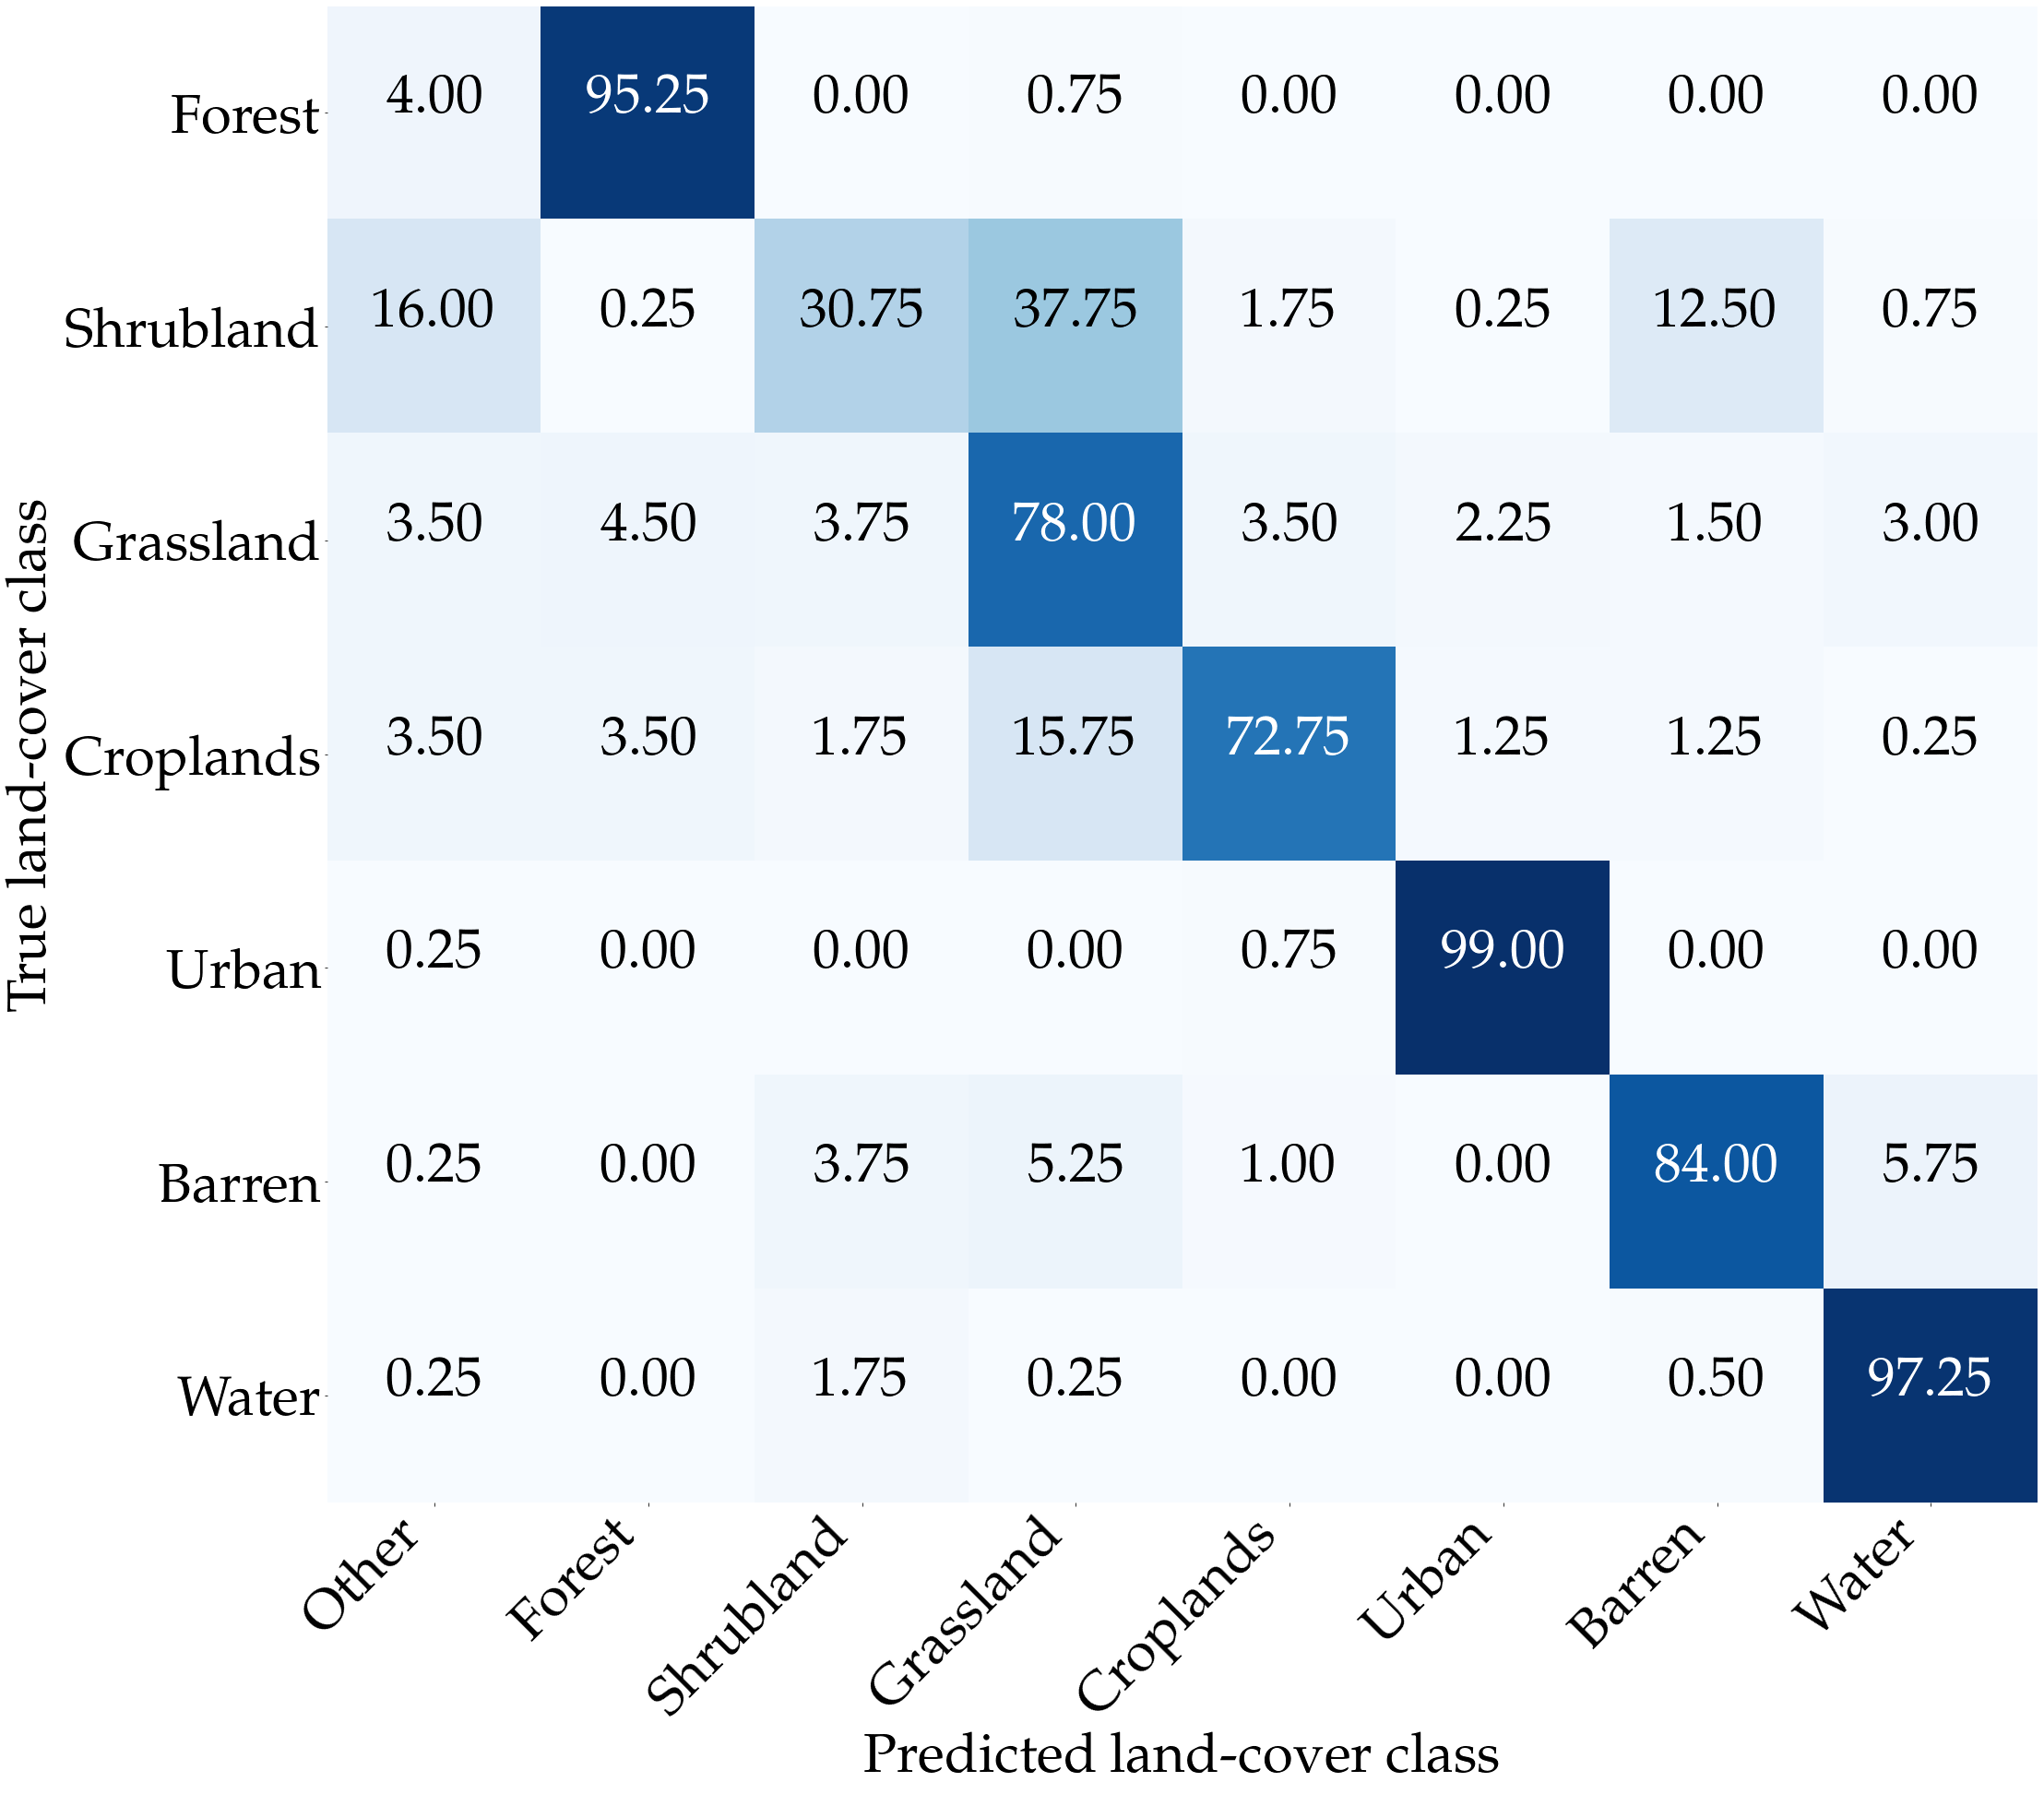

In [50]:
# Compute results
model_name = 'InceptionV3'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_or[model_name][lc_class]['labels'] for lc_class in features_or[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_or[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_orig_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

##### DIP samples

(6.5, -0.5) (-0.5, 7.5)


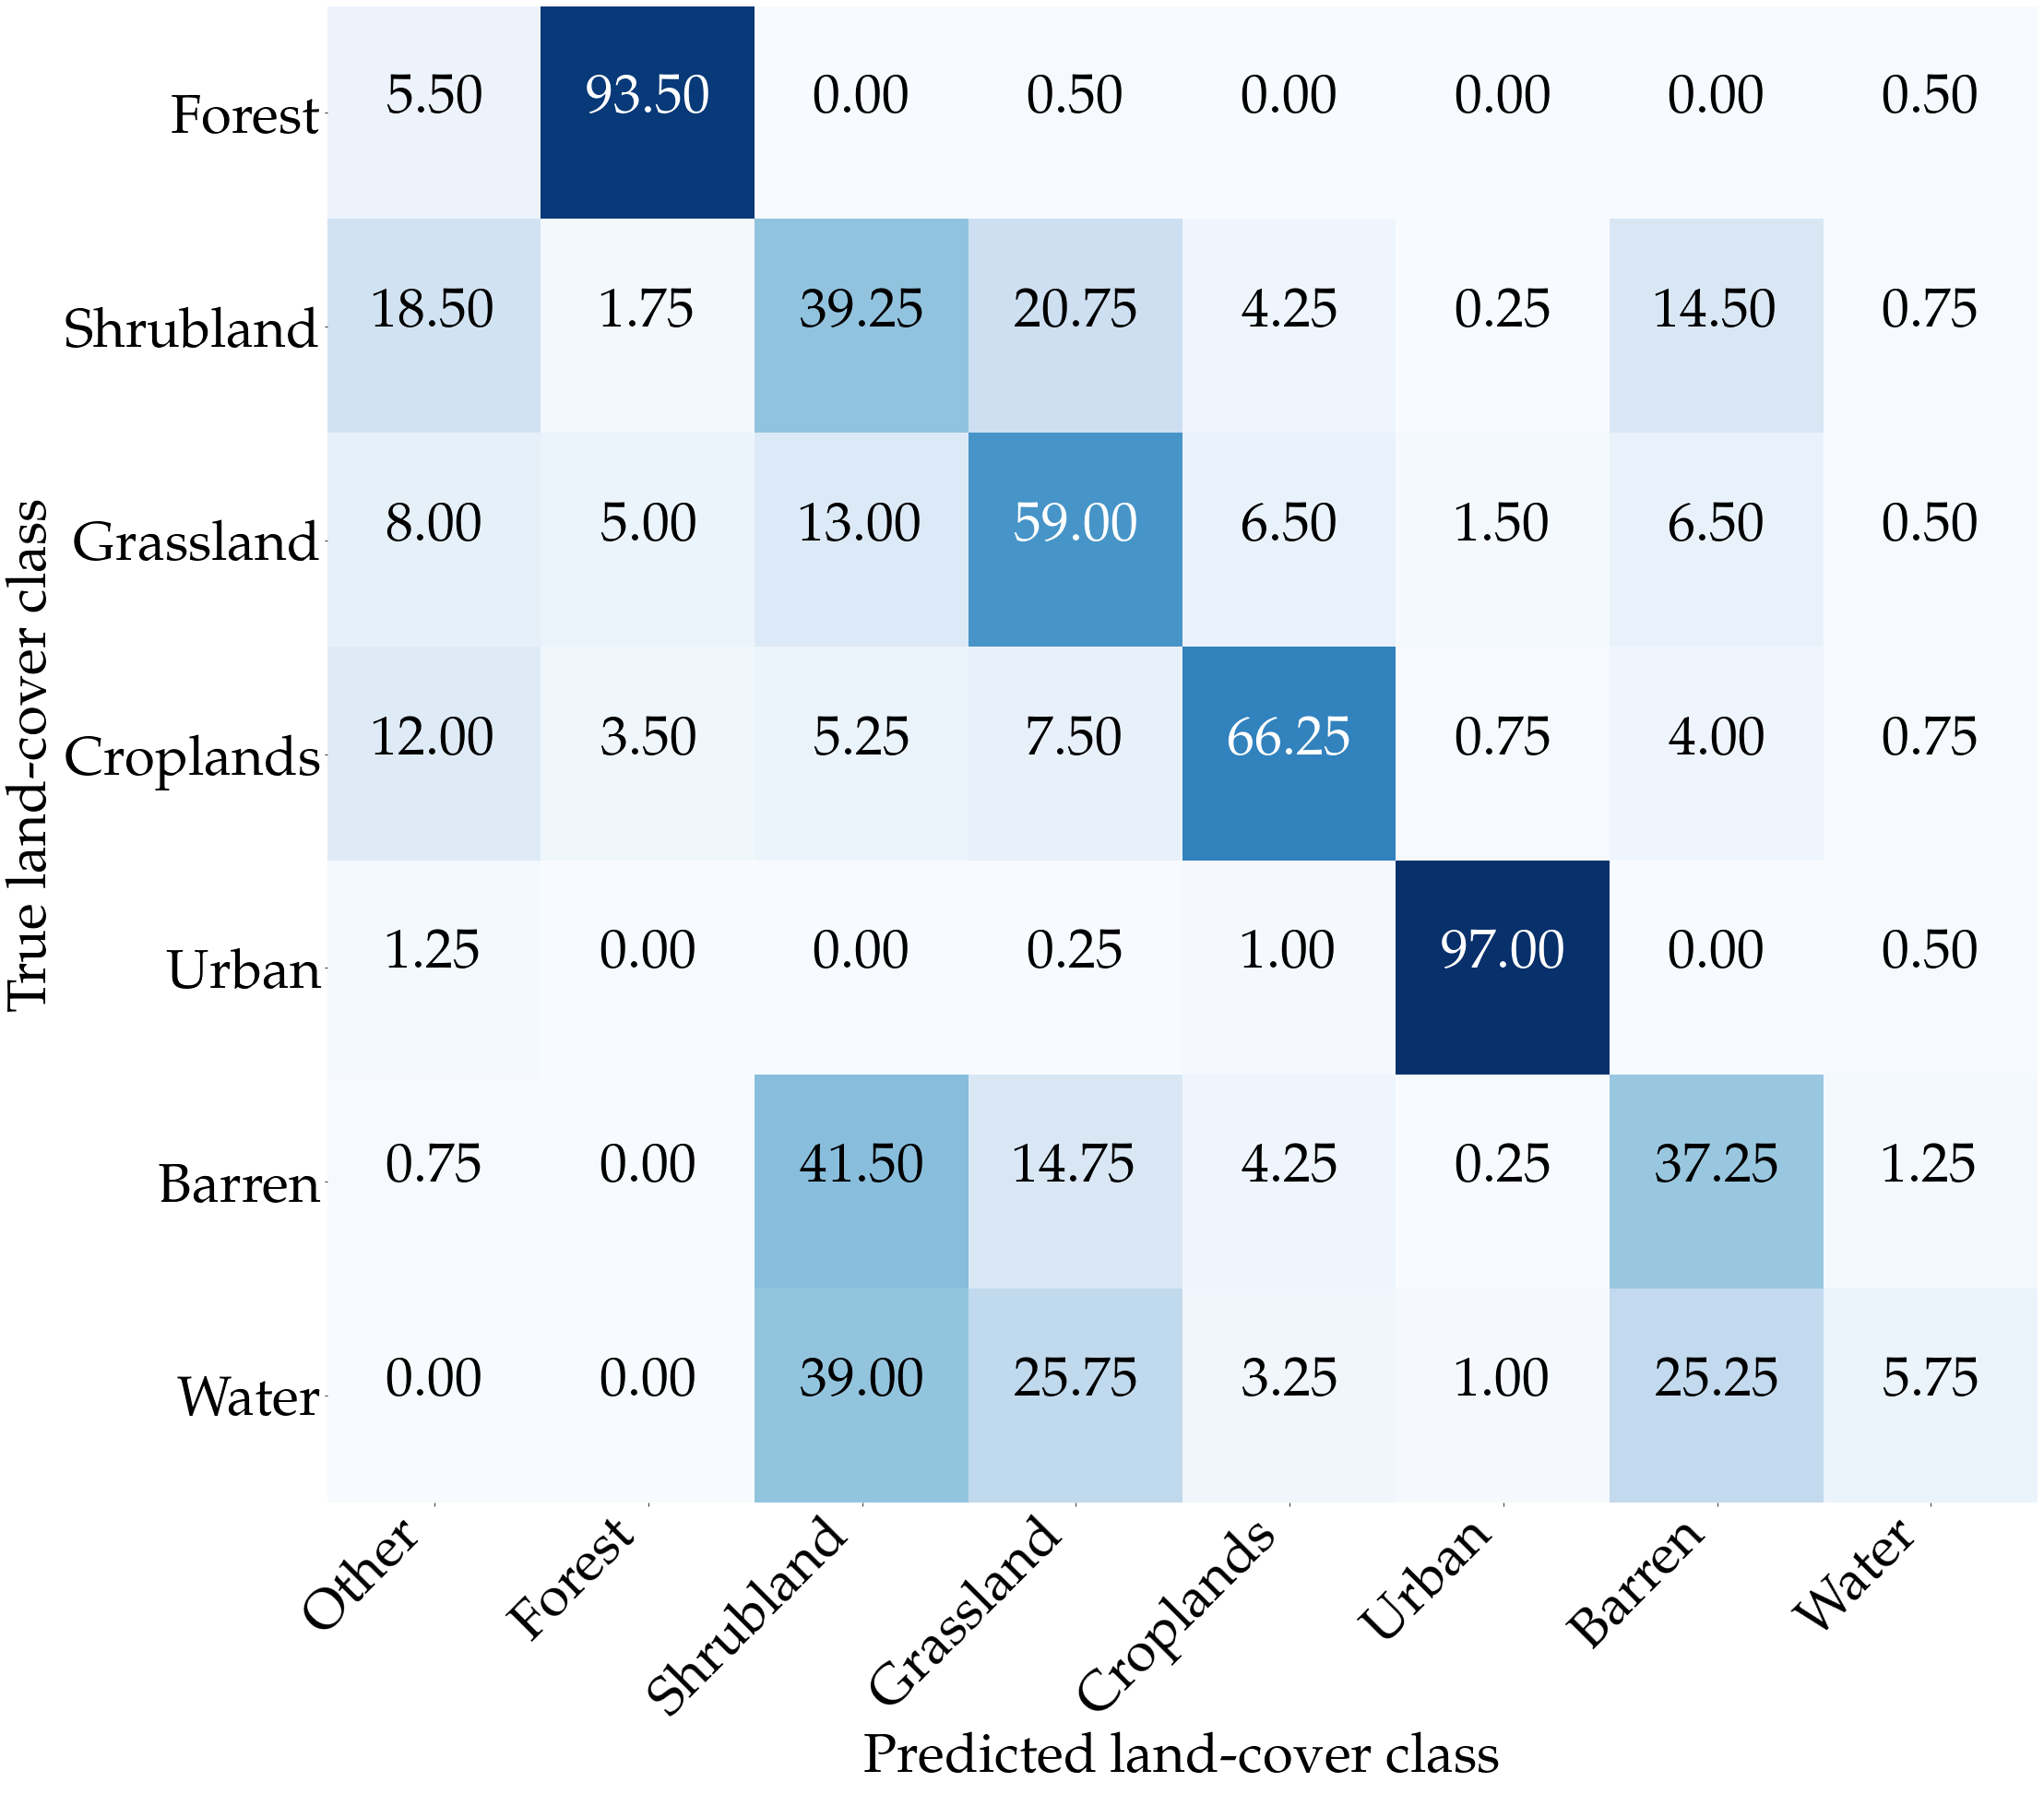

In [51]:
# Compute results
model_name = 'InceptionV3'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_gen[model_name][lc_class]['labels'] for lc_class in features_gen[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_gen[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_gen[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_generated_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

#### ResNet50

##### Original samples

(6.5, -0.5) (-0.5, 7.5)


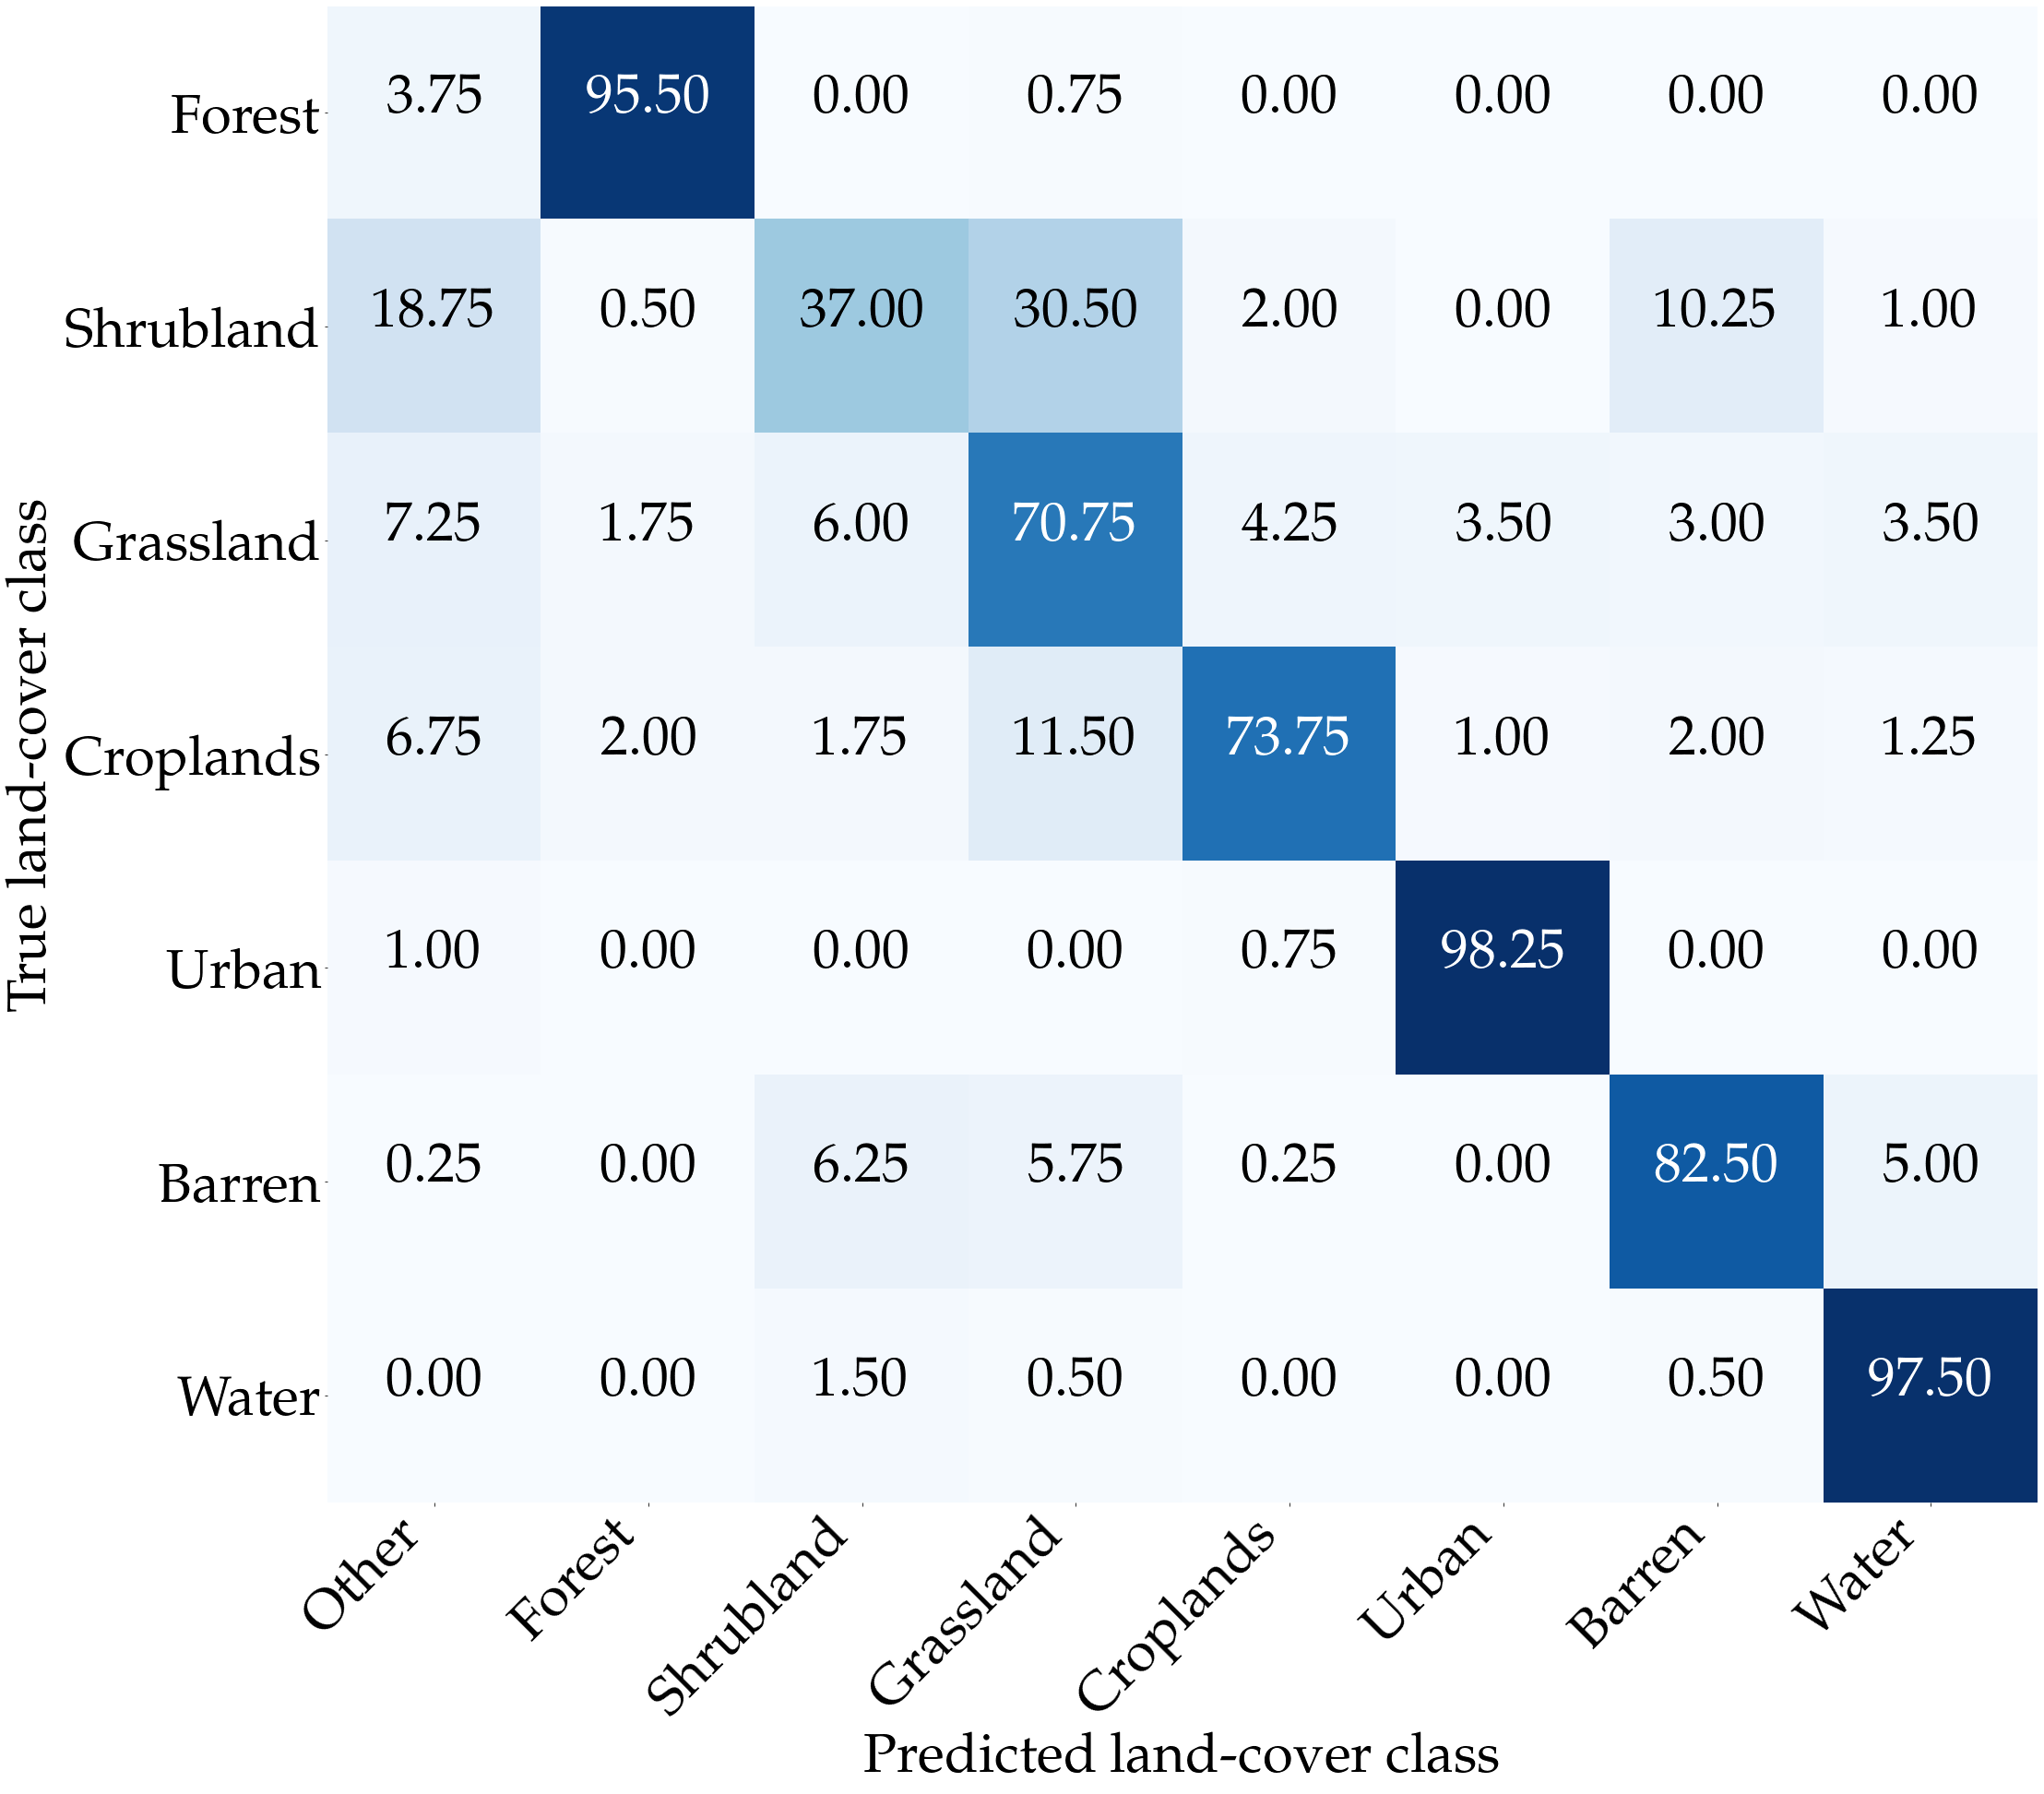

In [52]:
# Compute results
model_name = 'ResNet50'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_or[model_name][lc_class]['labels'] for lc_class in features_or[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_or[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_orig_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

##### DIP generated samples

(6.5, -0.5) (-0.5, 7.5)


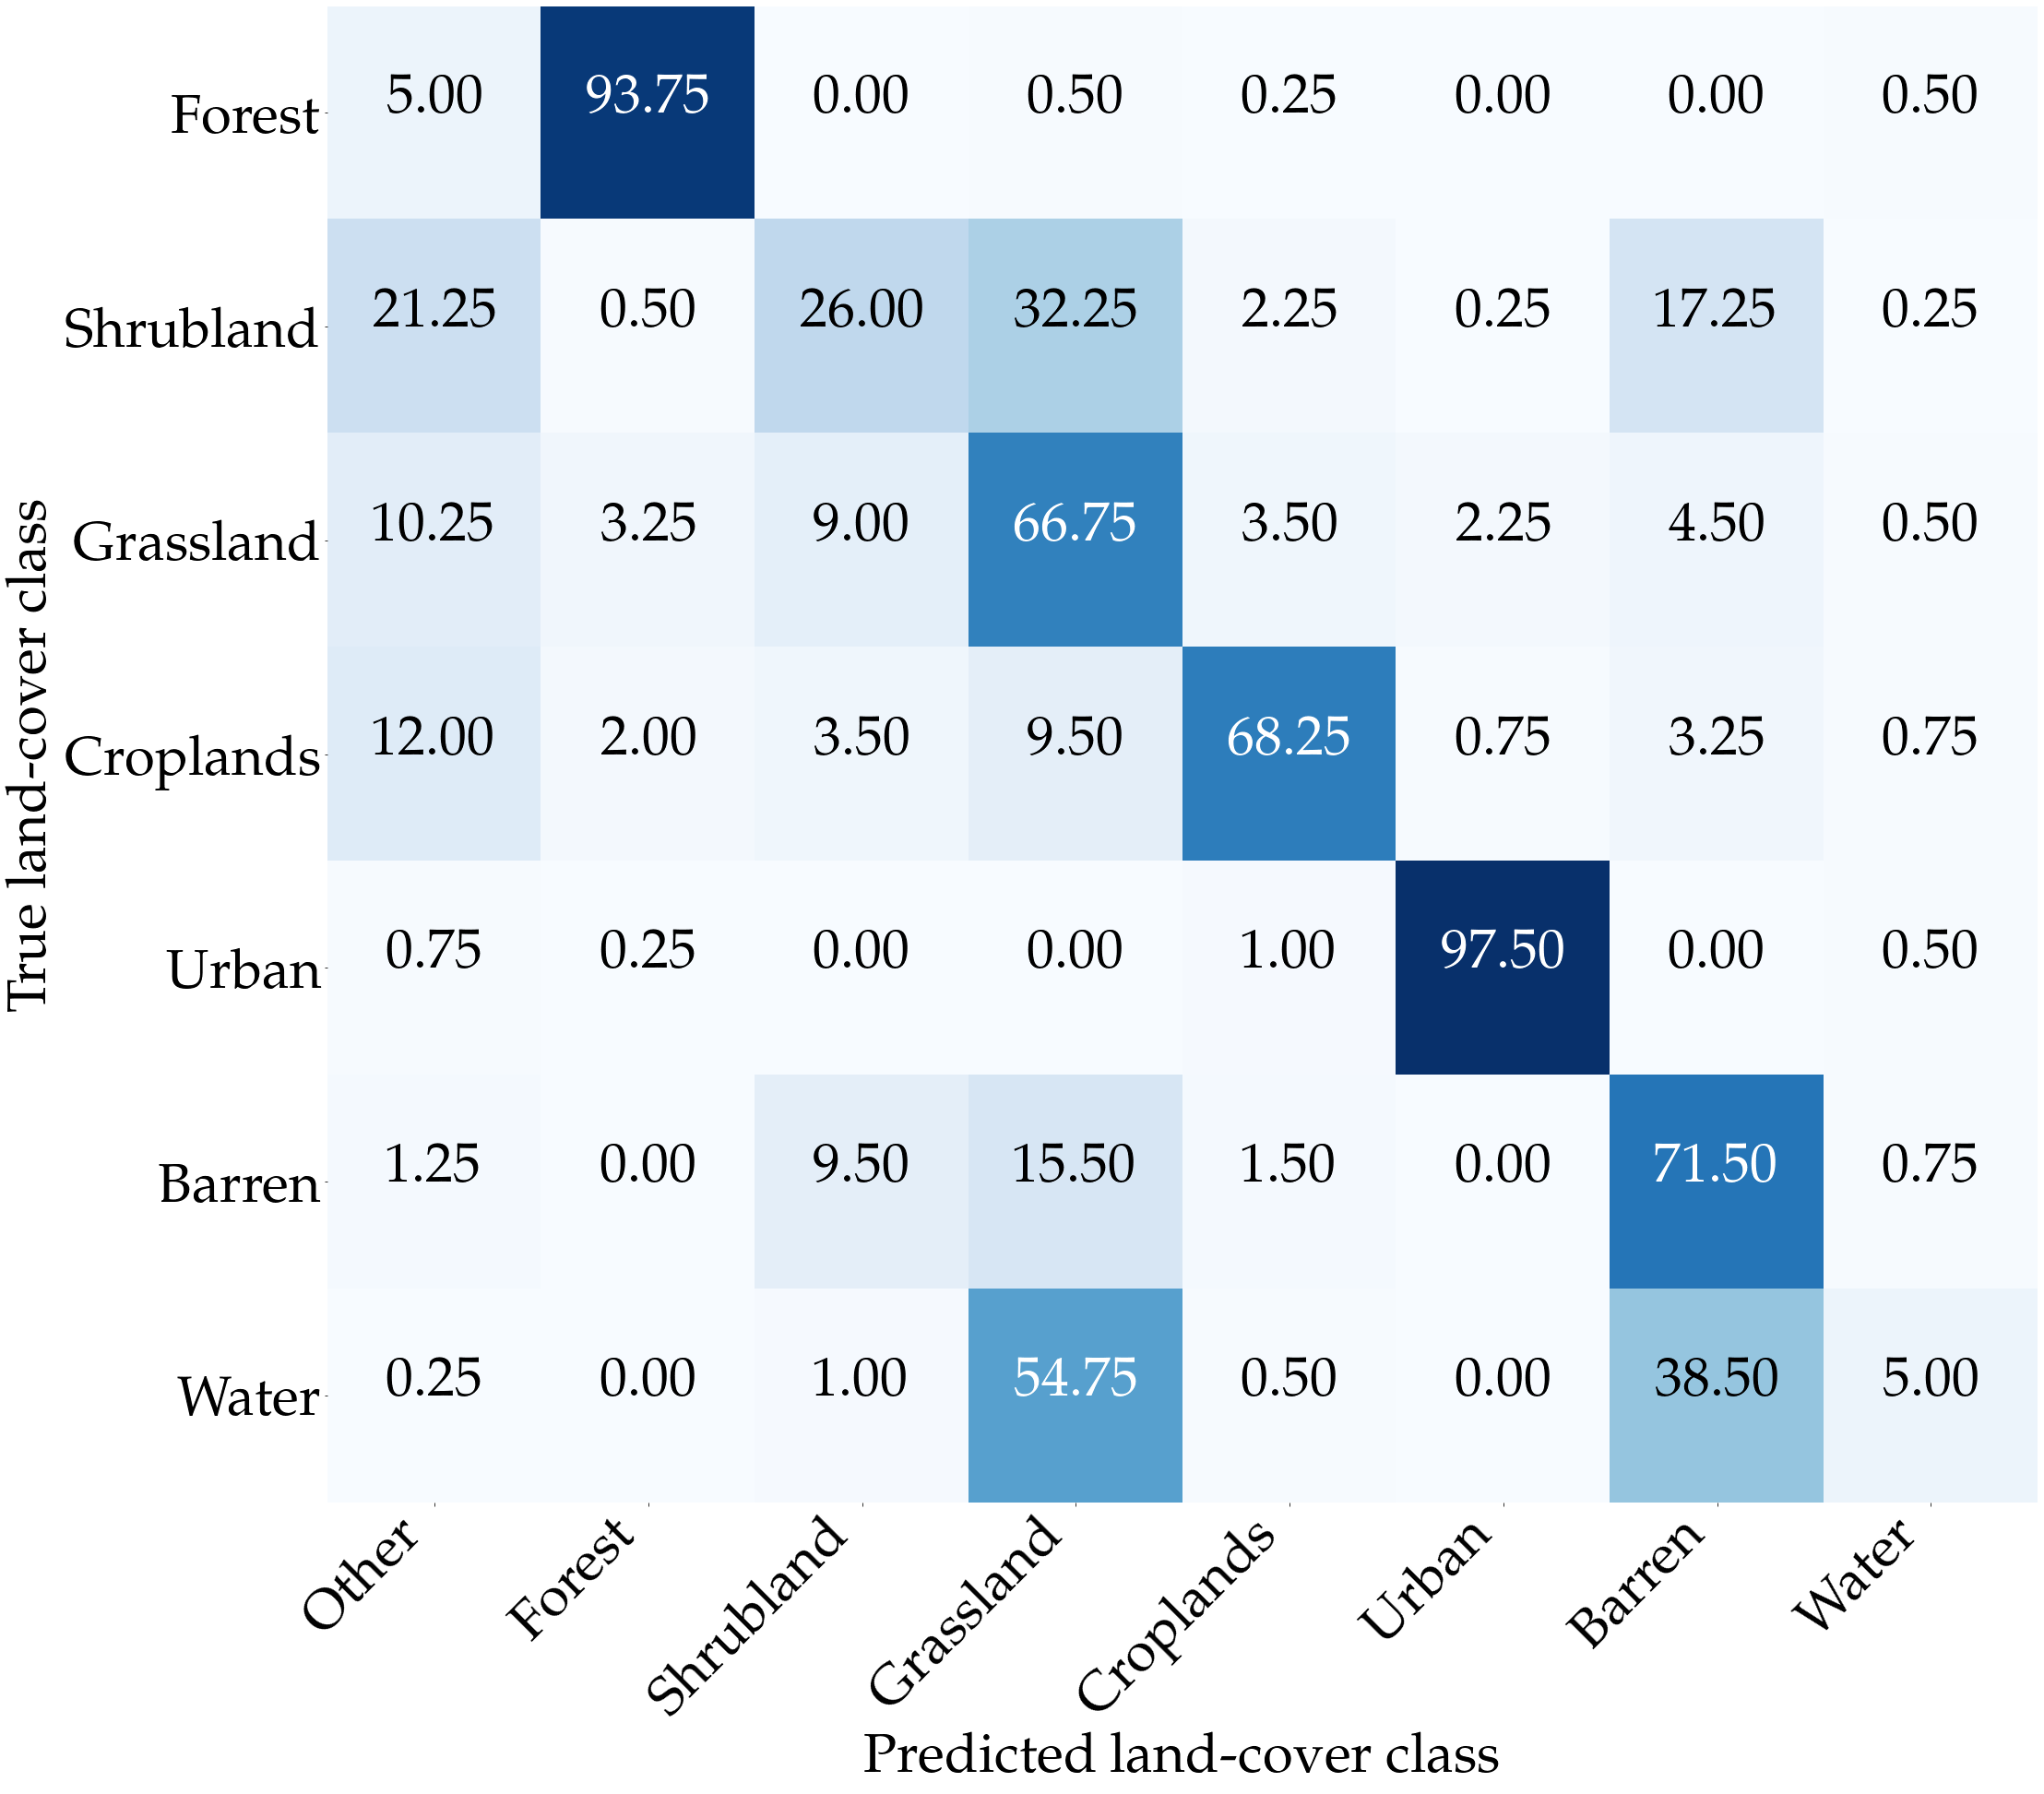

In [53]:
# Compute results
model_name = 'ResNet50'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_gen[model_name][lc_class]['labels'] for lc_class in features_gen[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_gen[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_gen[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_generated_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

#### EfficientNetB0

##### Original samples

(6.5, -0.5) (-0.5, 7.5)


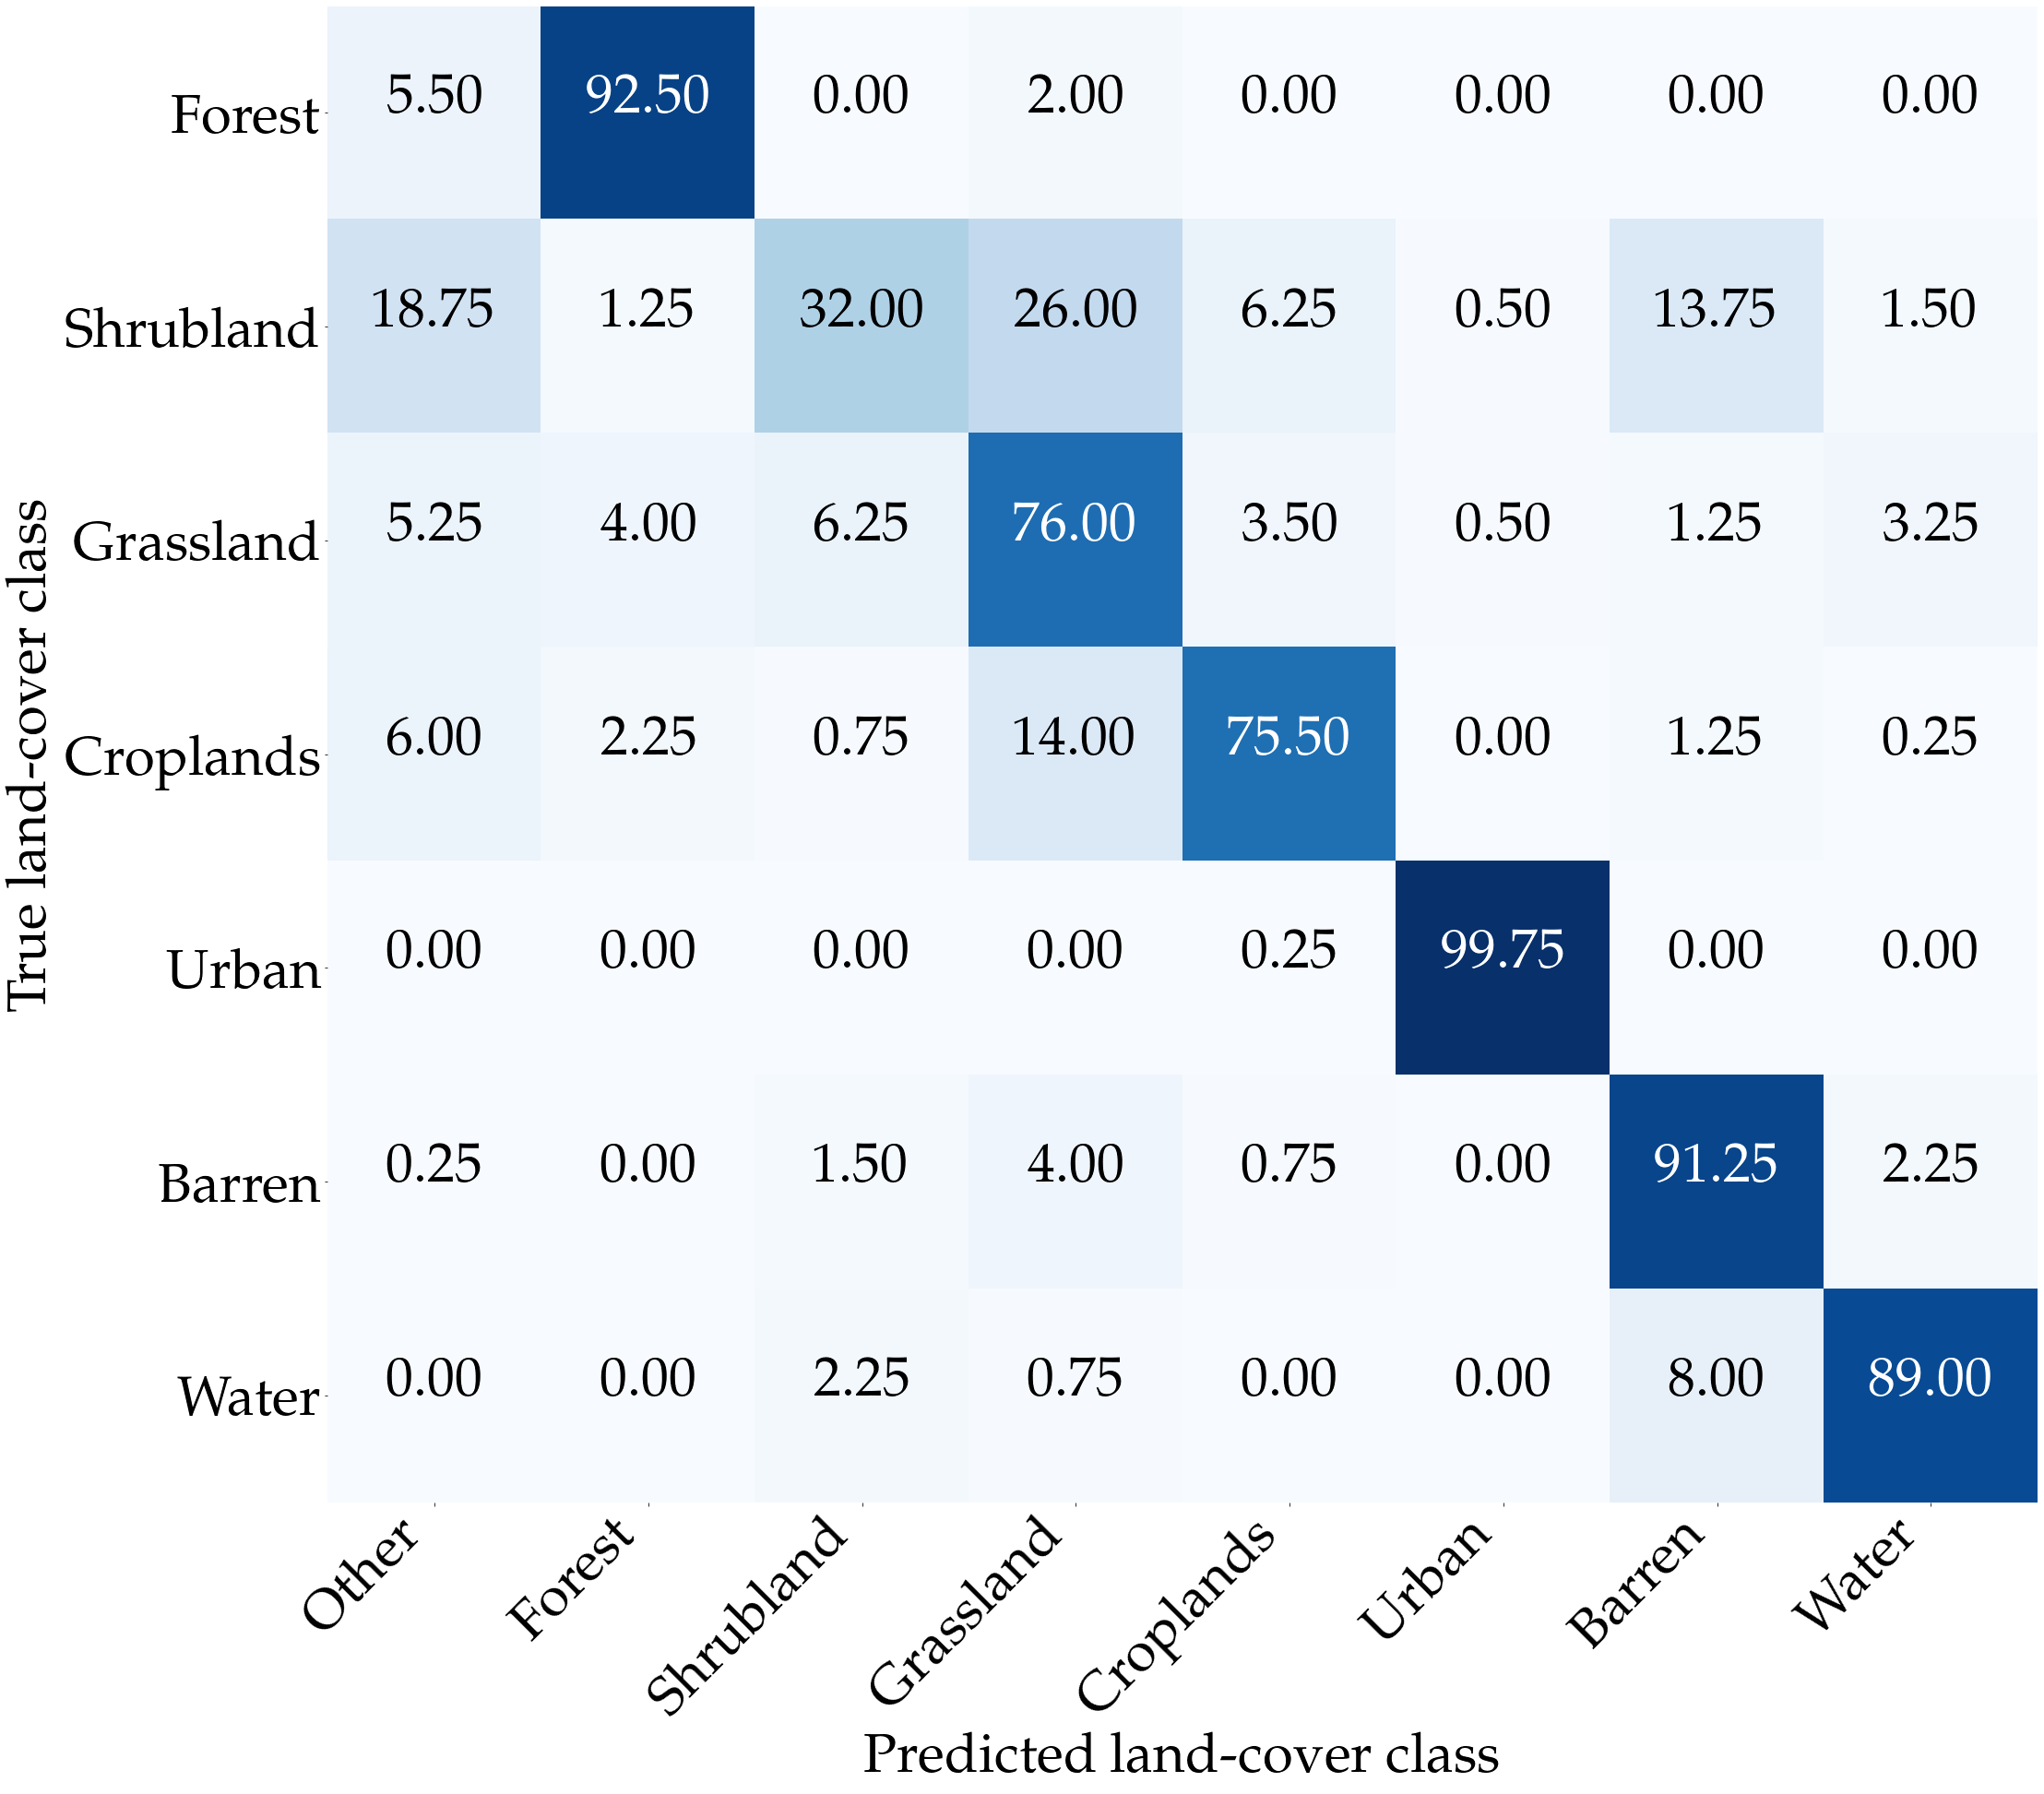

In [54]:
# Compute results
model_name = 'EfficientNetB0'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_or[model_name][lc_class]['labels'] for lc_class in features_or[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_or[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_orig_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

#### DIP generated samples

##### Confusion matrix

(6.5, -0.5) (-0.5, 7.5)


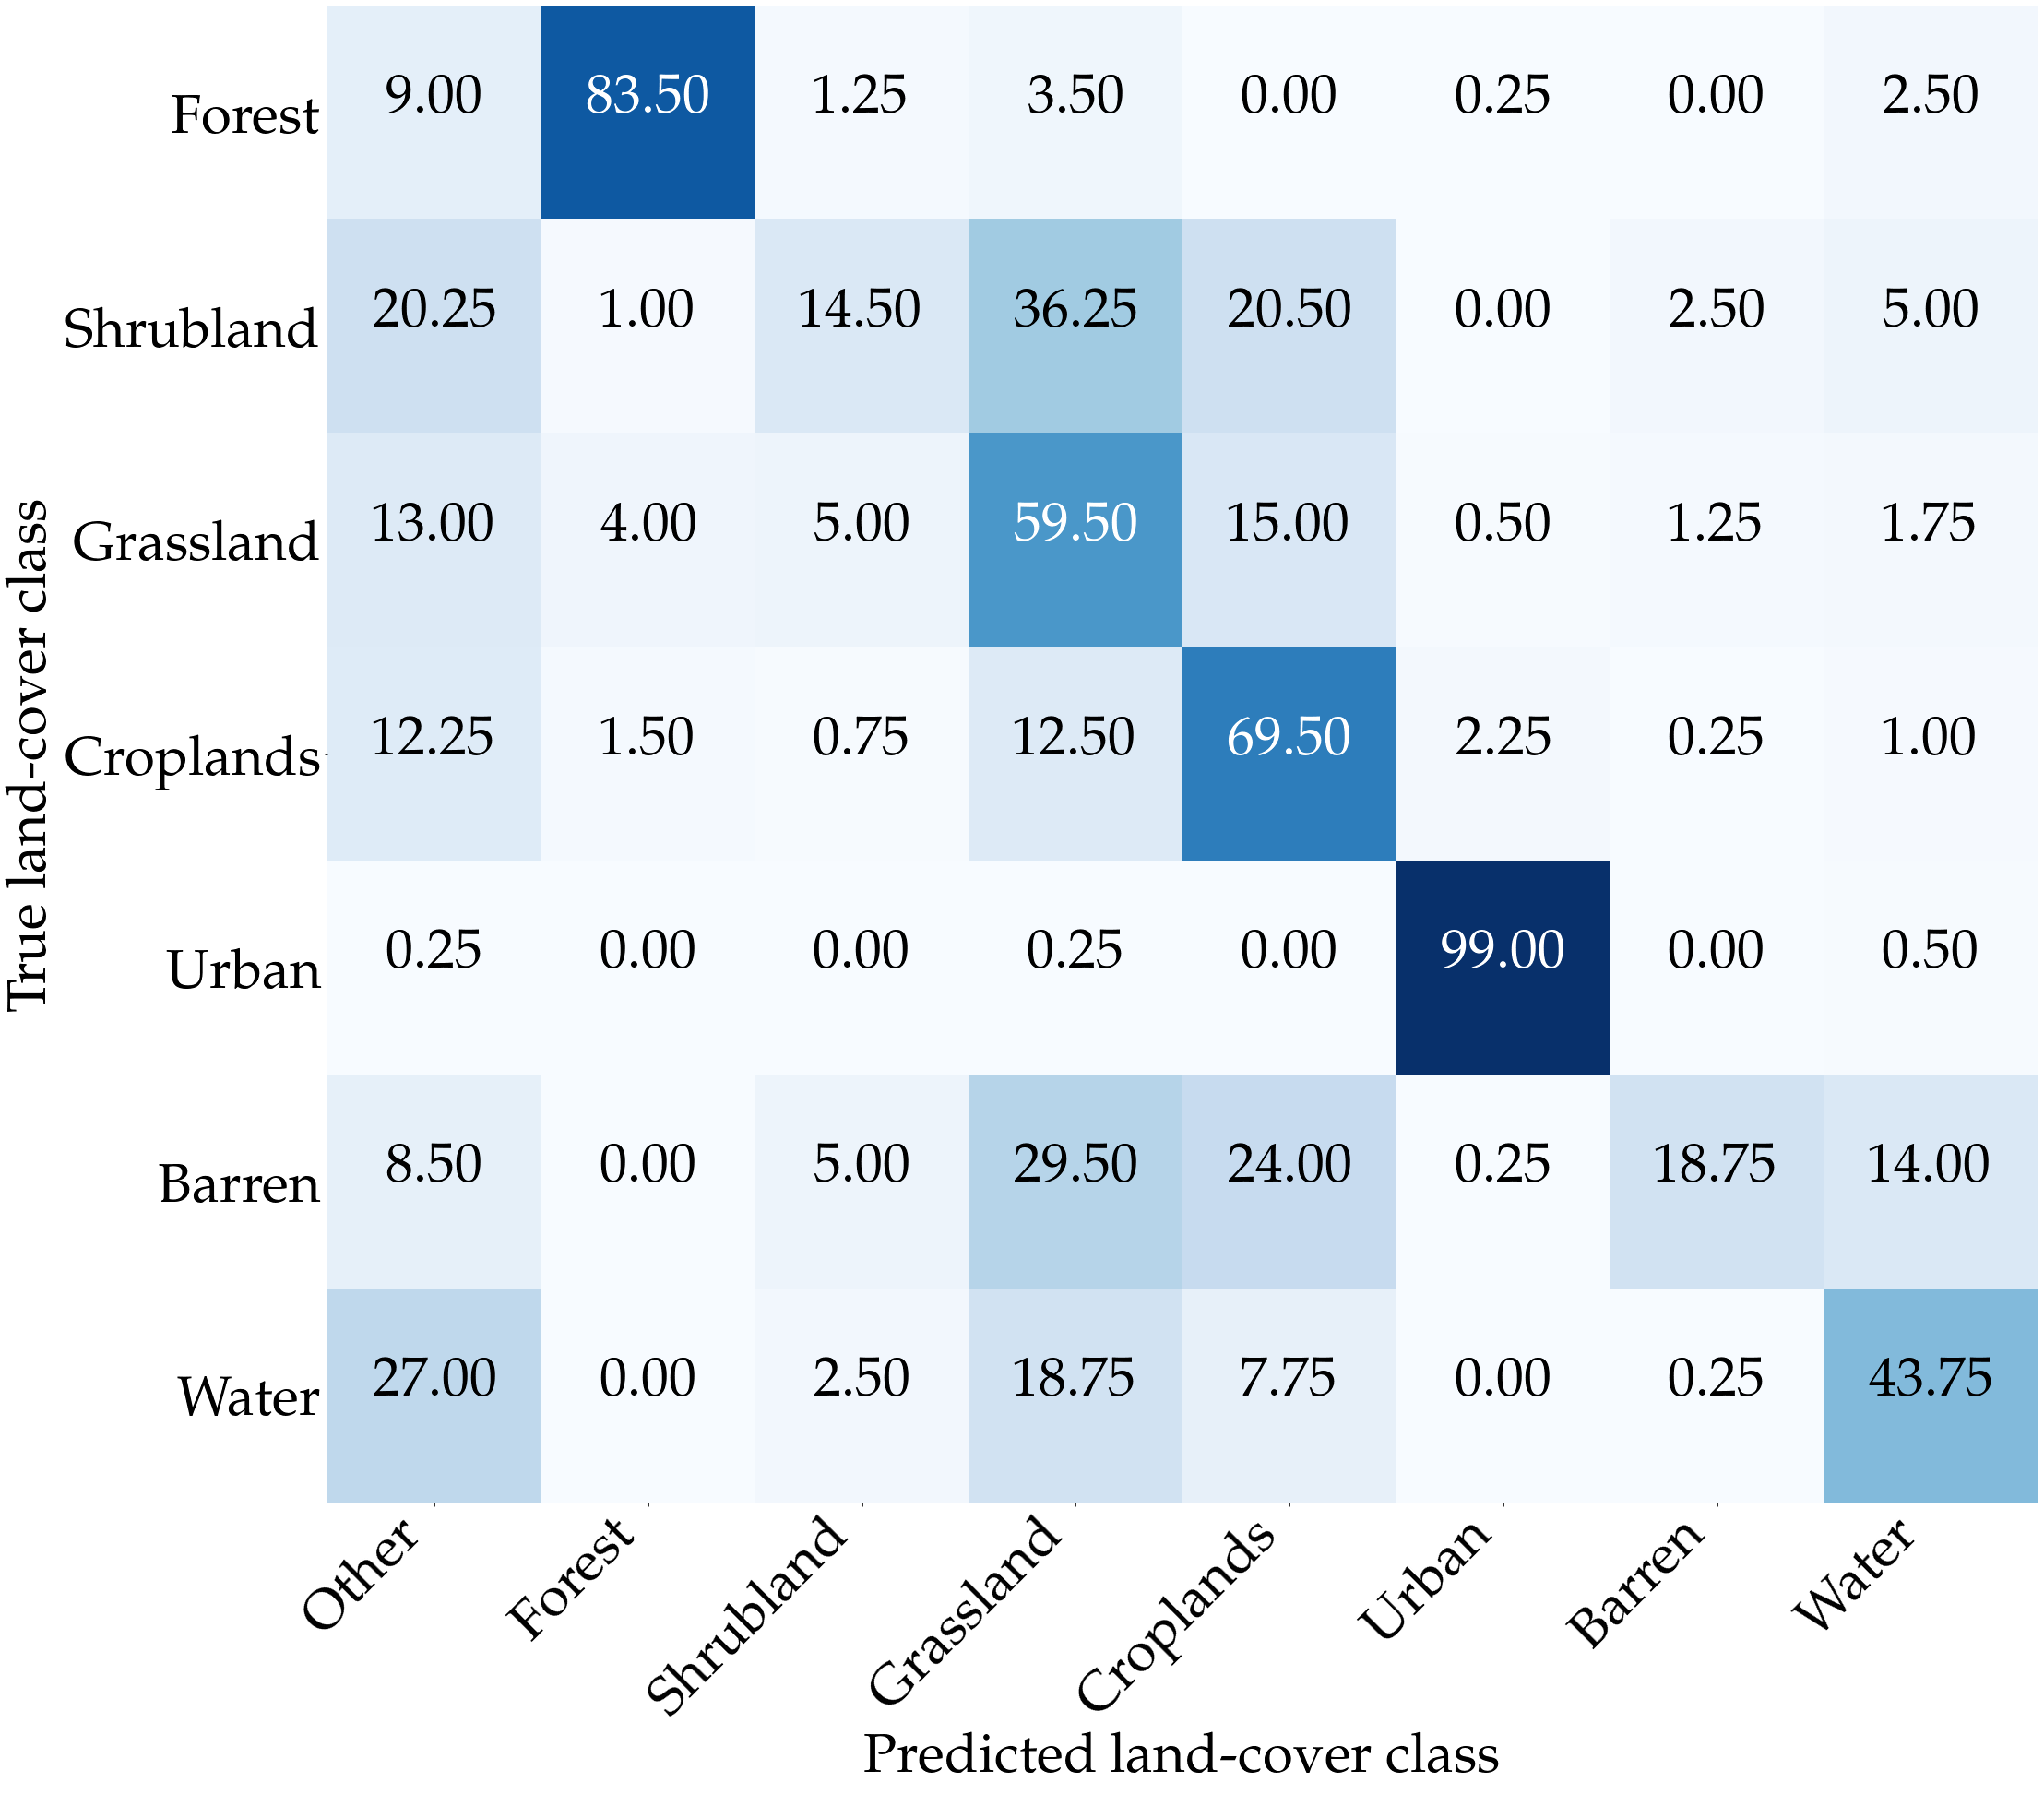

In [55]:
# Compute results
model_name = 'EfficientNetB0'
labels = ['Other', 'Forest', 'Shrubland', 'Grassland', 'Croplands', 'Urban', 'Barren', 'Water']
y_true = np.concatenate([features_gen[model_name][lc_class]['labels'] for lc_class in features_gen[model_name].keys()])
preds = np.concatenate([np.argmax(softmax(features_gen[model_name][lc_class]['pre_logits'], axis=1), axis=1) for lc_class in features_gen[model_name].keys()])
preds[~np.isin(preds, np.unique(y_true))] = -1  # adjust all the prediction for other classes in a "Other" label

cm = M.confusion_matrix(y_true, preds, normalize='true')

# Plotting
fsize = 60
plt.figure(figsize=(30, 30),frameon=False)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
cmap = plt.get_cmap('Blues')
plt.imshow(cm[1:, :], interpolation='nearest', cmap=cmap)
# plt.title(f'Confusion matrix for original samples classified by {model_name}', fontsize=30)
# plt.axis('off')
# Add labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=fsize) # plot tick labels, layout gets schifiu
plt.yticks(tick_marks[:-1], labels[1:], ha='right', fontsize=fsize)
print(plt.ylim(), plt.xlim())

# Add values
thresh = .5
for i, j in itertools.product(range(cm[1:, :].shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:.2f}%".format(cm[i+1, j]*100),
             horizontalalignment="center",
             color="white" if cm[i+1, j] > thresh else "black", fontsize=fsize)

# Show image
plt.tight_layout()
plt.ylabel('True land-cover class', fontsize=fsize)
plt.xlabel('Predicted land-cover class', fontsize=fsize)
plt.box(False)
#plt.savefig("semantic_metric_cm_generated_resnet.pdf", dpi=300, bbox_inches = 'tight')  
plt.show()

### Comparison of performances

#### First just accuracies on the original samples

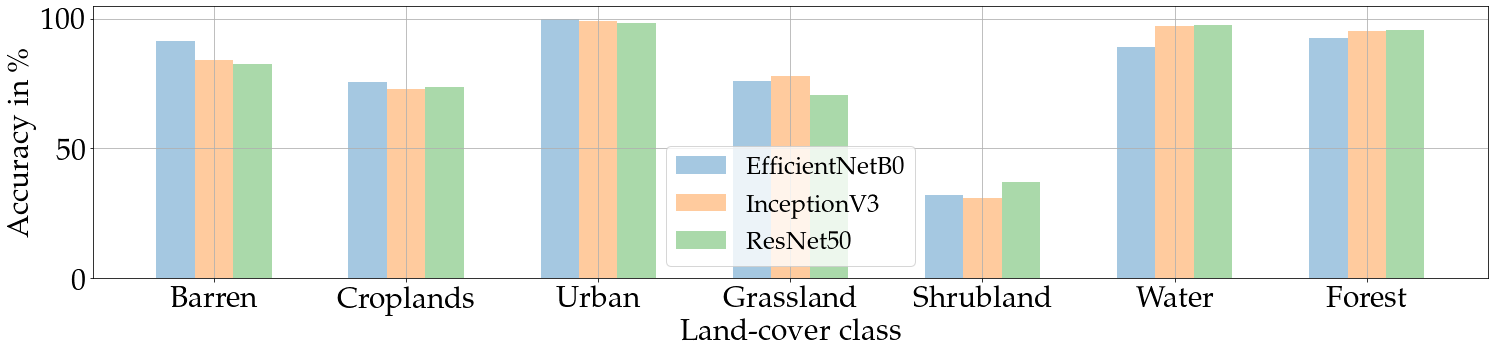

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(25, 5), sharex=True)
fsize = 30

# Compute accuracies for each class
accs_df = {model_name: pd.DataFrame.from_dict({lc_class: np.sum(np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1)==features_or[model_name][lc_class]['labels'])/400 for lc_class in features_or[model_name].keys()}, orient='index', columns=['Original samples accuracy']) for model_name in sorted(features_or.keys())}

# Plot them as a bar plot
X_axis = np.arange(len(accs_df['EfficientNetB0'].index))
eff_recs = axs.bar(X_axis - 0.2, accs_df['EfficientNetB0']['Original samples accuracy']*100, 0.2, label = 'EfficientNetB0', alpha=0.4)
inc_recs = axs.bar(X_axis, accs_df['InceptionV3']['Original samples accuracy']*100, 0.2, label = 'InceptionV3', alpha=0.4)
res_recs = axs.bar(X_axis + 0.2, accs_df['ResNet50']['Original samples accuracy']*100, 0.2, label = 'ResNet50', alpha=0.4)

axs.set_xticks(X_axis)
axs.set_xticklabels(accs_df['EfficientNetB0'].index)
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)
axs.set_ylabel("Accuracy in \%", fontsize=fsize)
axs.grid()
axs.legend(fontsize=fsize-5)
plt.show()

#### Plot delta-Accuracy between original and generated

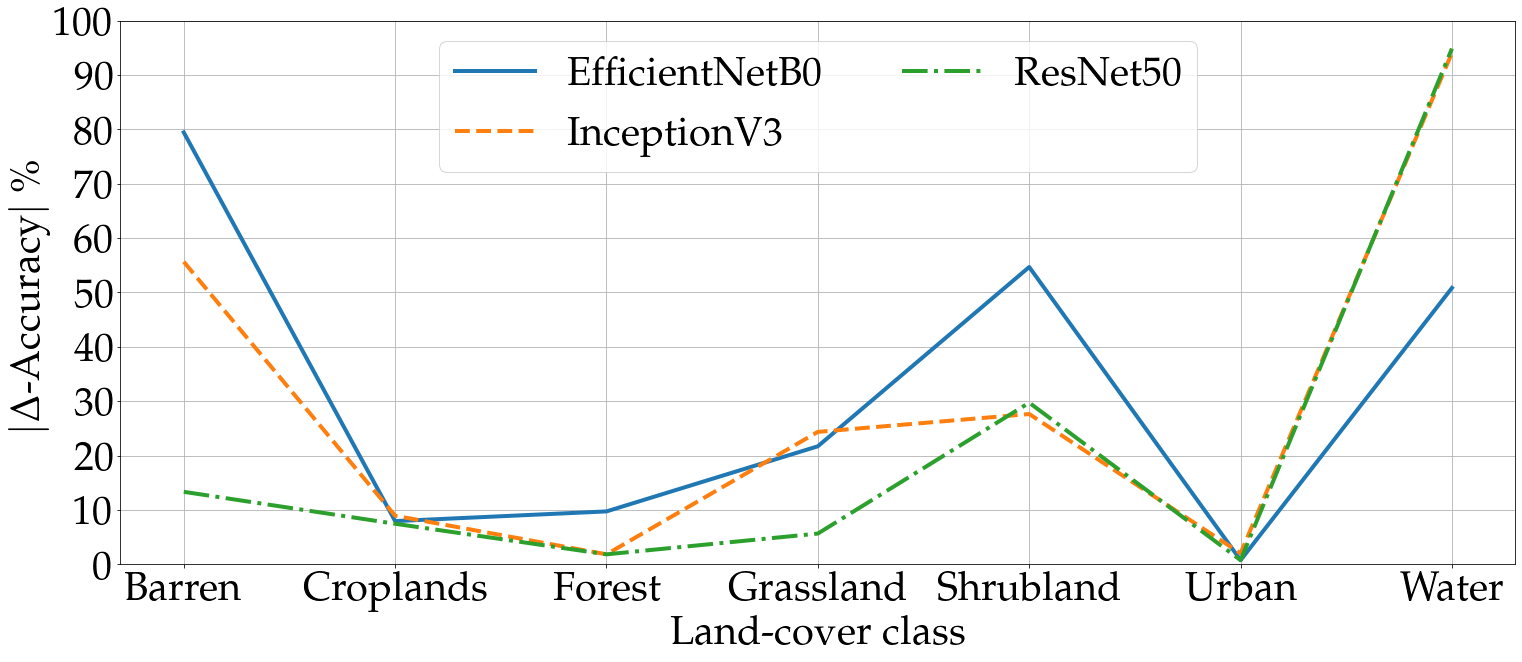

In [57]:
fsize = 40
fig, axs = plt.subplots(1, 1, figsize=(25, 10))
linestyles = ['-', '--', 'dashdot']
lw = 4
for i, model_name in enumerate(sorted(features_or.keys())):
    # Compute accuracies for each class
    df = pd.DataFrame.from_dict({lc_class: np.sum(np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1)==features_or[model_name][lc_class]['labels'])/len(features_or[model_name][lc_class]) for lc_class in features_or[model_name].keys()}, orient='index', columns=['Original samples accuracy'])
    df['DIP generated samples accuracy'] = [np.sum(np.argmax(softmax(features_gen[model_name][lc_class]['pre_logits'], axis=1), axis=1)==features_gen[model_name][lc_class]['labels'])/len(features_or[model_name][lc_class]) for lc_class in features_gen[model_name].keys()]

    # Plot them as a bar plot
    X_axis = np.arange(len(features_or[model_name].keys()))
    axs.plot(X_axis, abs(df['Original samples accuracy'].sort_index(axis=0) - df['DIP generated samples accuracy'].sort_index(axis=0))/(df['Original samples accuracy'].sort_index(axis=0))*100, label = '{}'.format(model_name), linestyle=linestyles[i], linewidth=lw)
axs.set_xticks(X_axis)
axs.set_xticklabels(sorted(df.index))
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)
axs.set_ylabel("$|\Delta$-Accuracy$|$ \%", fontsize=fsize)
axs.legend(fontsize=fsize, ncol=len(df.columns))
plt.grid()
axs.set_ylim([0, 100])
axs.set_yticks(np.arange(0, 110, 10))  
plt.show()

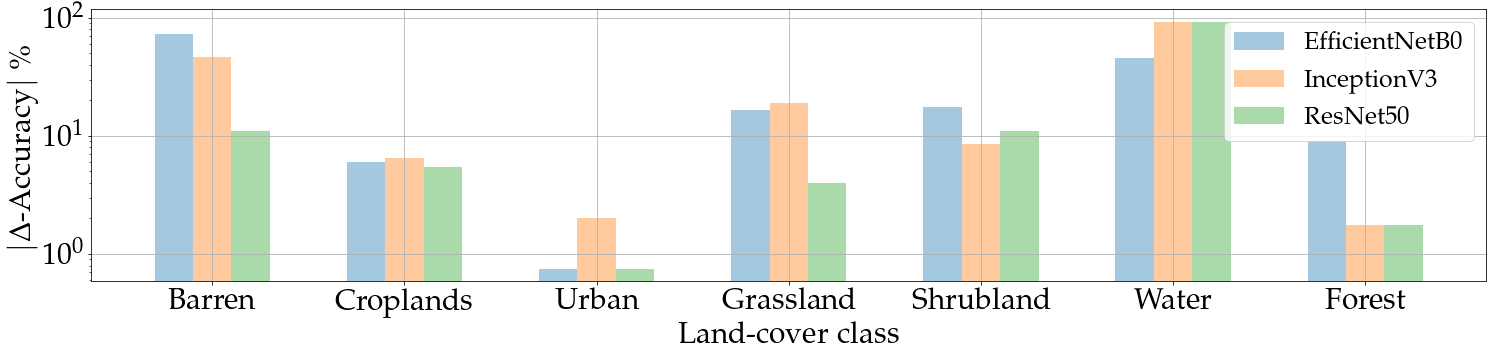

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(25, 5), sharex=True)
fsize = 30

disp = {'EfficientNetB0': -0.2, 'InceptionV3': 0, 'ResNet50': 0.2}

for i, model_name in enumerate(sorted(features_or.keys())):
    # Compute accuracies for each class
    accs_df = pd.DataFrame.from_dict({lc_class: np.sum(np.argmax(softmax(features_or[model_name][lc_class]['pre_logits'], axis=1), axis=1)==features_or[model_name][lc_class]['labels'])/400 for lc_class in features_or[model_name].keys()}, orient='index', columns=['Original samples accuracy'])
    accs_df['DIP generated samples accuracy'] = [np.sum(np.argmax(softmax(features_gen[model_name][lc_class]['pre_logits'], axis=1), axis=1)==features_gen[model_name][lc_class]['labels'])/400 for lc_class in features_gen[model_name].keys()]

    # Plot them as a bar plot
    X_axis = np.arange(len(accs_df.index))
    recs = axs.bar(X_axis + disp[model_name], np.abs((accs_df['Original samples accuracy']-accs_df['DIP generated samples accuracy']))*100, 0.2, label = model_name, alpha=0.4)
    

axs.set_xticks(X_axis)
axs.set_xticklabels(accs_df.index)
axs.tick_params('both', labelsize=fsize)
axs.set_xlabel("Land-cover class", fontsize=fsize)
axs.set_ylabel("$|\Delta$-Accuracy$|$ \%", fontsize=fsize)
axs.set_yscale('log')
#axs[i].set_title(f"Original VS DIP generated samples accuracy for {model_name}", fontsize=30)
axs.grid()
axs.legend(fontsize=fsize-5, loc='best')
plt.show()

## Bonus: "Deep" or "distribution" metrics
We consider Inception score (IS), Frechet Inception Distance (FID), and Kernel Inception Distance (KID)

### In batches

In [ ]:
deep_metrics_batches = pd.read_pickle('deep_metrics_batches_all_models.pkl')
deep_metrics_batches

### All samples

In [44]:
deep_metrics_all = pd.read_pickle('deep_metrics_all_samples_all_models.pkl')
deep_metrics_all.sort_index(level=1, inplace=True)

In [45]:
deep_metrics_all

IS        FID       KID
EfficientNetB0 Barren     2.013933  19.258565  0.039895
InceptionV3    Barren     0.324176  10.599844  0.011031
ResNet50       Barren     0.079711  28.994257  0.035014
EfficientNetB0 Croplands  0.244711   1.323451   0.00171
InceptionV3    Croplands  0.367489   1.969336  0.001061
ResNet50       Croplands  0.117247   3.876391  0.002195
EfficientNetB0 Forest     0.331766   1.621611  0.002718
InceptionV3    Forest     0.050041   1.678325  0.001291
ResNet50       Forest      0.04241   1.037556  0.000441
EfficientNetB0 Grassland  0.542581   1.984187  0.001924
InceptionV3    Grassland  0.695564   3.354955  0.002664
ResNet50       Grassland  0.050058   6.447624  0.004111
EfficientNetB0 Shrubland  0.189662   3.490866  0.004295
InceptionV3    Shrubland  0.113402   4.310429  0.002377
ResNet50       Shrubland  0.351212  10.400477  0.008523
EfficientNetB0 Urban      0.051147    0.55486  0.000731
InceptionV3    Urban      0.093194   1.765476   0.00106
ResNet50       Urban      0.037793   3.140057  0.001399
EfficientNetB0 Water      1.482437  49.108799  0.043624
InceptionV3    Water      0.962745  33.100039  0.033728
ResNet50       Water      0.314439  57.623849  0.075776

### Let's plot them more nicely

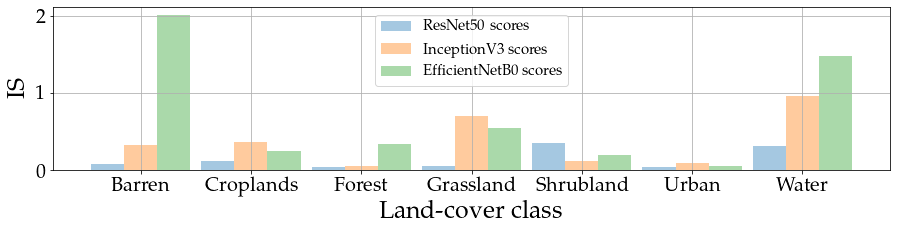

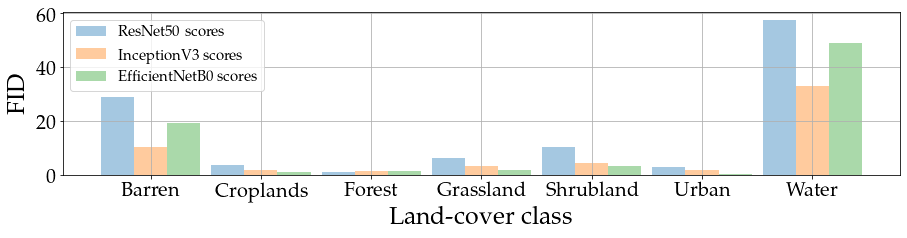

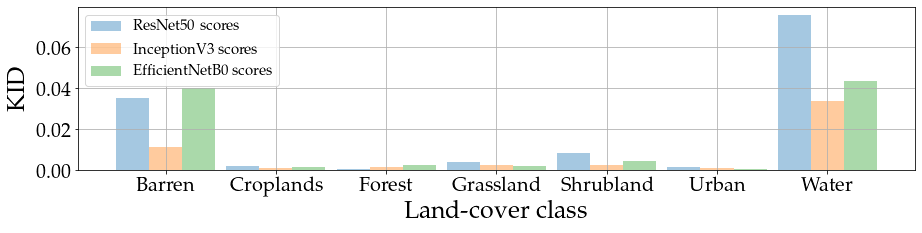

In [46]:
for idx, metric in enumerate(deep_metrics_all.columns):

    # Plot metrics for each class as a bar plot
    fig, axs = plt.subplots(1, 1, figsize=(15, 3))
    X_axis = np.arange(len(deep_metrics_all.index.get_level_values(1).unique()))
    axs.bar(X_axis - 0.3, deep_metrics_all.loc['ResNet50'][metric], 0.3, label = f'ResNet50 scores', alpha=0.4)
    axs.bar(X_axis, deep_metrics_all.loc['InceptionV3'][metric], 0.3, label = f'InceptionV3 scores', alpha=0.4)
    axs.bar(X_axis + 0.3, deep_metrics_all.loc['EfficientNetB0'][metric], 0.3, label = f'EfficientNetB0 scores', alpha=0.4)

    axs.set_xticks(X_axis)
    axs.set_xticklabels(deep_metrics_all.index.get_level_values(1).unique())
    axs.tick_params('both', labelsize=20)
    axs.set_xlabel("Land-cover class", fontsize=25)
    axs.set_ylabel(f"{metric}", fontsize=25)
    axs.
    #plt.title(f"{metric} for all samples", fontsize=30)
    plt.grid()
    axs.legend(fontsize=15)
    plt.show()

### Let's see the distribution of the metric values

In [ ]:
for idx, metric in enumerate(deep_metrics_batches.columns):
    

    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{metric} values distributions', fontsize=35)
    
    results_df = deep_metrics_batches.swaplevel(0, 1)
    for idx, lc_class in enumerate(deep_metrics_batches.index.unique(level=1)):
        samples = results_df.loc[lc_class]
        if idx < 4:
            axs[0][idx].hist(samples.loc['ResNet50'][metric], bins=250, alpha=0.4, density = True, label='ResNet50 scores')
            axs[0][idx].hist(samples.loc['InceptionV3'][metric], bins=250, alpha=0.4, density = True, label='InceptionV3 scores')
            axs[0][idx].hist(samples.loc['EfficientNetB0'][metric], bins=250, alpha=0.4, density = True, label='EfficientNetB0 scores')
            axs[0][idx].set_title(f'{lc_class}', fontsize=20)
            axs[0][idx].legend(fontsize='x-large')
        else:
            axs[1][idx-4].hist(samples.loc['ResNet50'][metric], bins=250, alpha=0.4, density = True, label='ResNet50 scores')
            axs[1][idx-4].hist(samples.loc['InceptionV3'][metric], bins=250, alpha=0.4, density = True, label='InceptionV3 scores')
            axs[1][idx-4].hist(samples.loc['EfficientNetB0'][metric], bins=250, alpha=0.4, density = True, label='EfficientNetB0 scores')
            axs[1][idx-4].set_title(f'{lc_class}', fontsize=20)
            axs[1][idx-4].legend(fontsize='x-large')

    axs[1][3].hist(deep_metrics_batches.loc['ResNet50'][metric], bins=250, alpha=0.4, density = True, label='ResNet50 scores')
    axs[1][3].hist(deep_metrics_batches.loc['InceptionV3'][metric], bins=250, alpha=0.4, density = True, label='InceptionV3 scores')
    axs[1][3].hist(deep_metrics_batches.loc['EfficientNetB0'][metric], bins=250, alpha=0.4, density = True, label='EfficientNetB0 scores')
    axs[1][3].set_title(f'All classes together', fontsize=20)
    axs[1][3].legend(fontsize='x-large')
    plt.show()

## Can we see the distribution of these features in a MDS plot?

In [16]:
import sklearn.manifold as manifold

def min_max_scaling(array: np.array) -> np.array:
    return (array-array.min())/(array.max()-array.min())

### EfficientNetB0

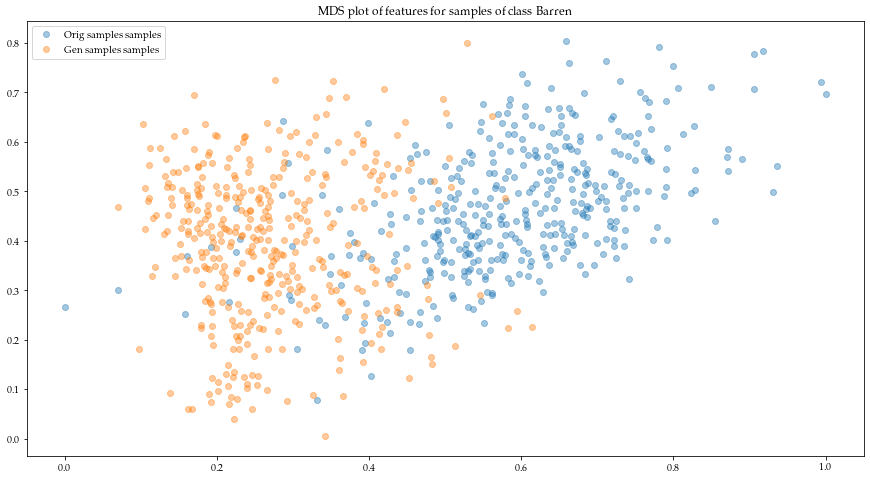

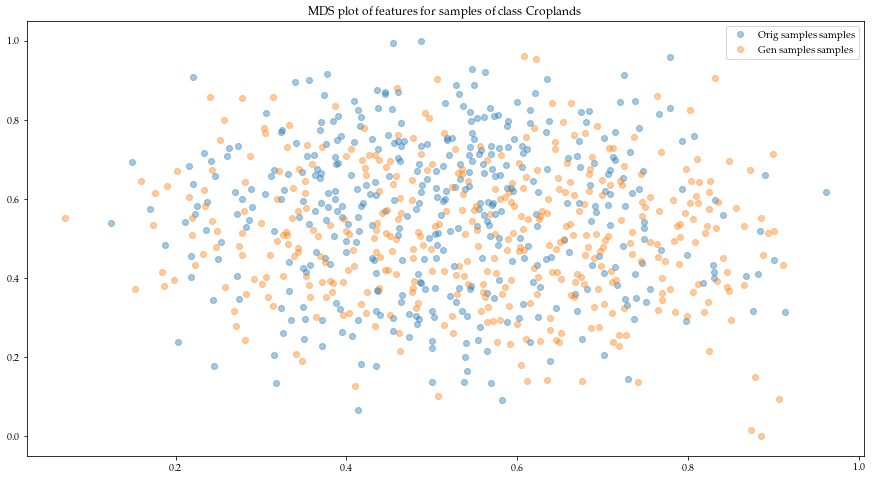

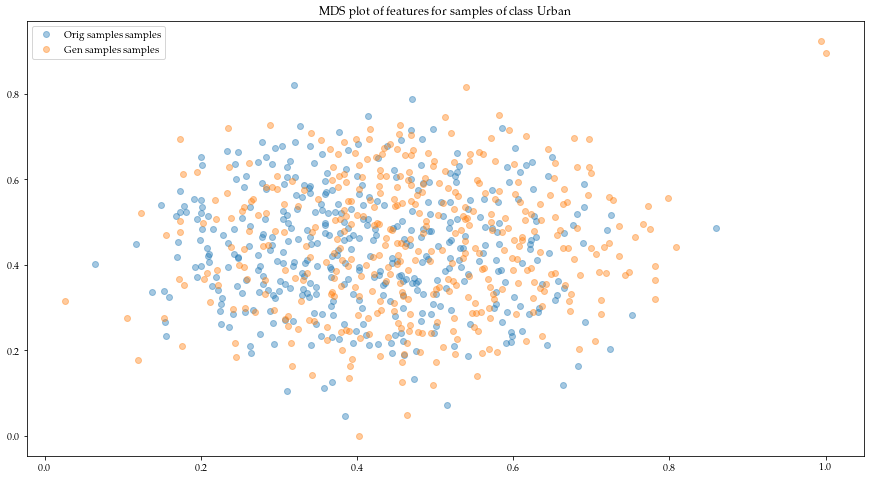

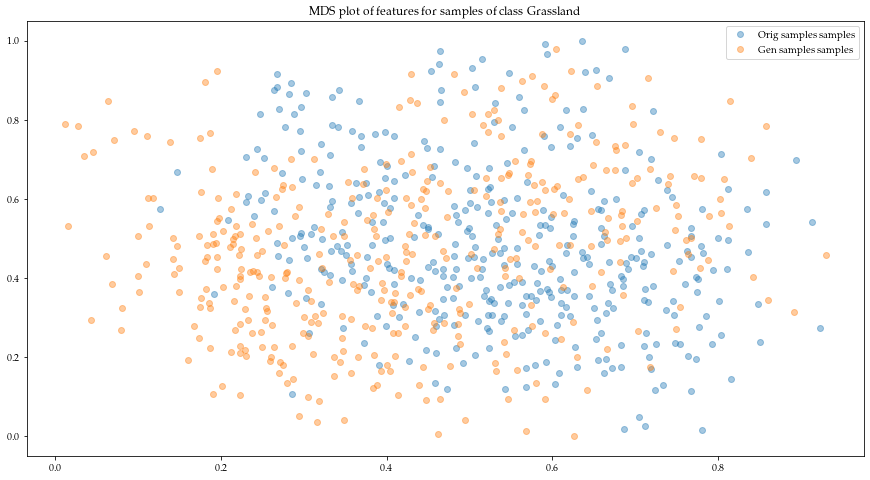

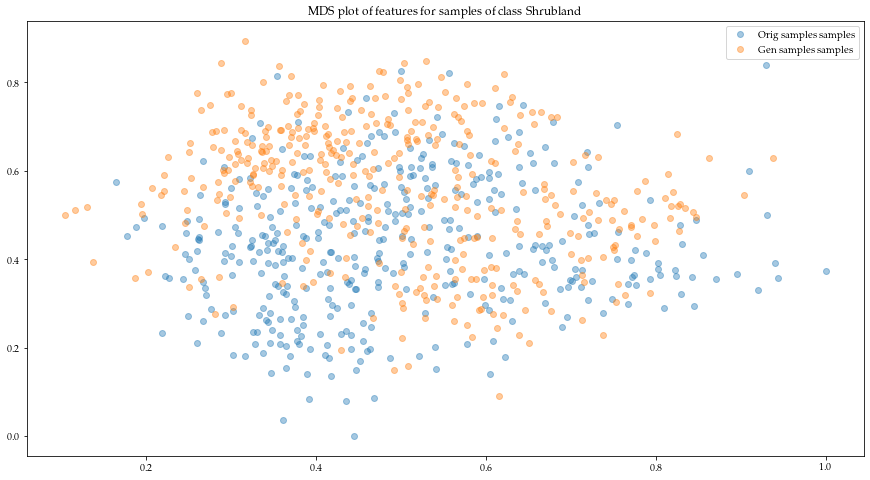

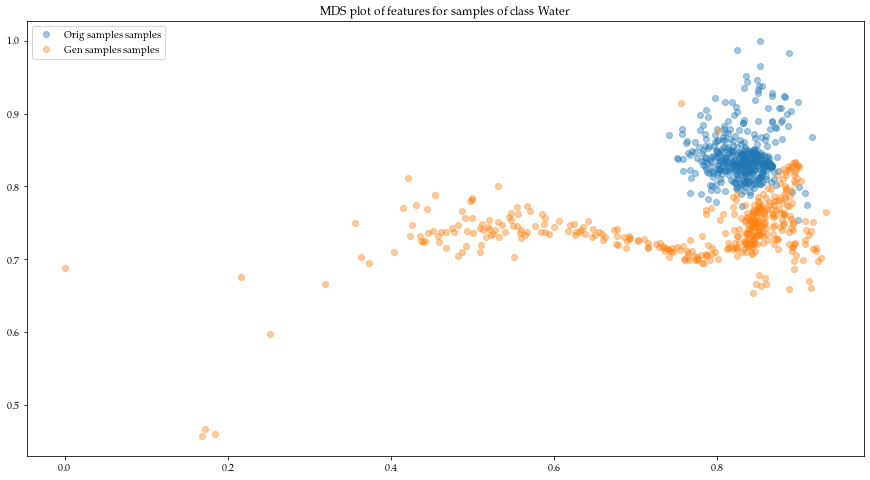

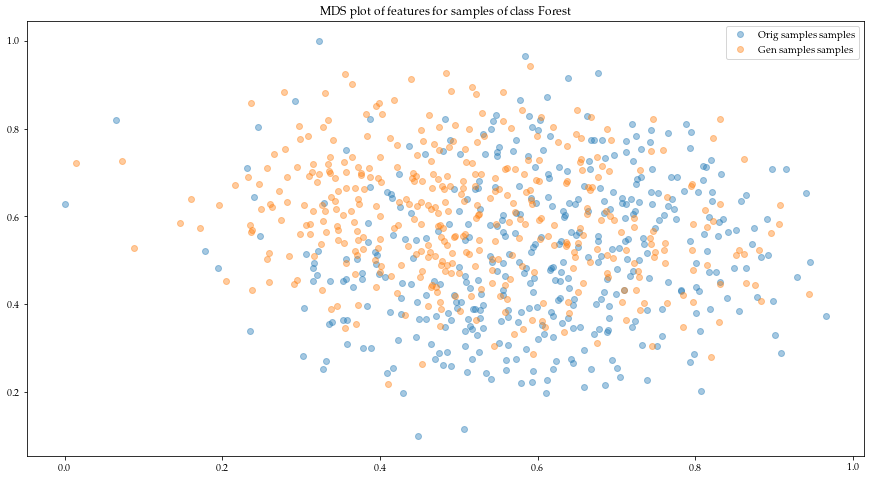

In [18]:
features_dict_or = features_or['EfficientNetB0']
features_dict_gen = features_gen['EfficientNetB0']
n_components = 2
for i, lc_class in enumerate(features_dict_or.keys()):
    # Concatenate all the features together for each class
    feats_or = features_dict_or[lc_class]['feats'].reshape((features_dict_or[lc_class]['feats'].shape[0], -1))
    feats_gen = features_dict_gen[lc_class]['feats'].reshape((features_dict_gen[lc_class]['feats'].shape[0], -1))
    X = min_max_scaling(np.concatenate([feats_or, feats_gen]))  # normalize the data
    embeds = manifold.MDS(n_components, max_iter=300, n_init=4, n_jobs=1).fit_transform(X)  # fit the manifold learner
    embeds = min_max_scaling(embeds)  # normalize the embeddings

    # Create the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    num_samples = features_dict_or[lc_class]['feats'].shape[0]
    label_or_gen = ['Orig samples', 'Gen samples']
    for j in range(2):
        ax.scatter(embeds[num_samples*j:(j+1)*num_samples-1, 0], embeds[num_samples*j:(j+1)*num_samples-1, 1], alpha=0.4, label=f'{label_or_gen[j]} samples')

    ax.legend()
    ax.set_title(f'MDS plot of features for samples of class {lc_class}')

### InceptionV3

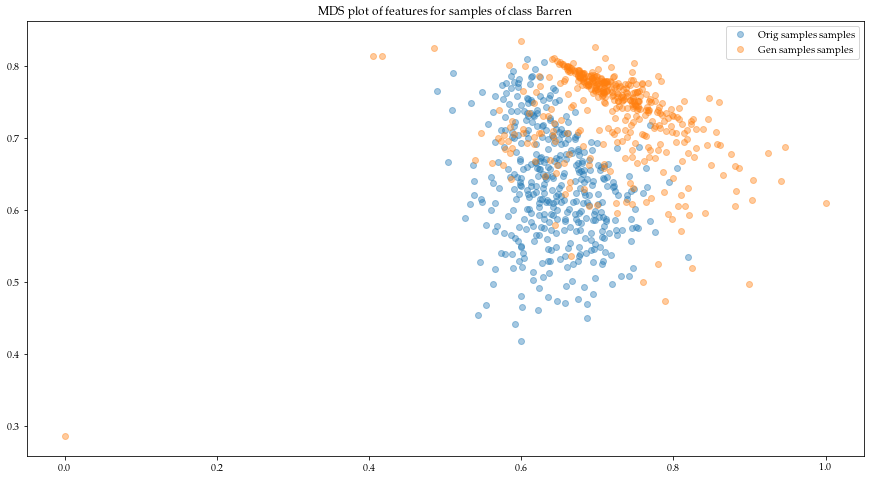

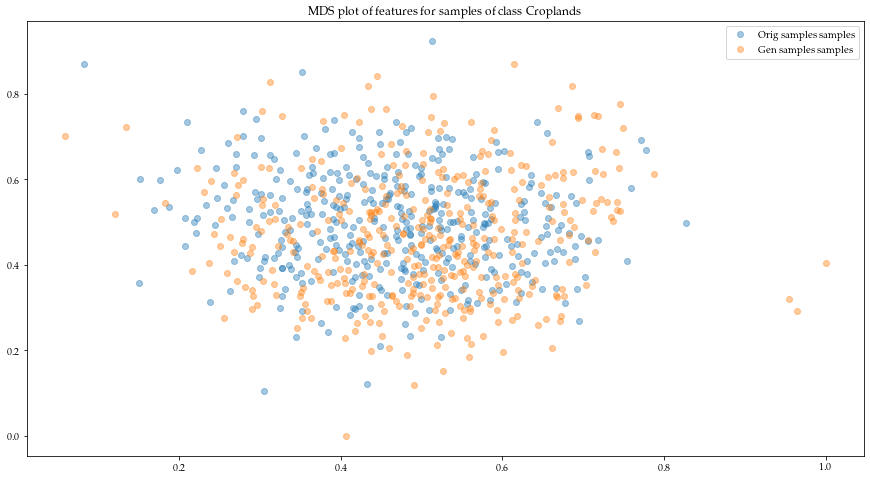

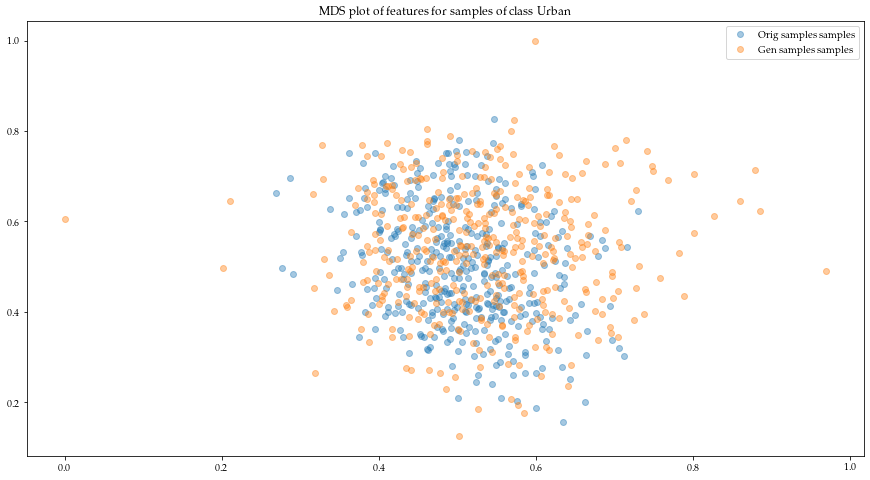

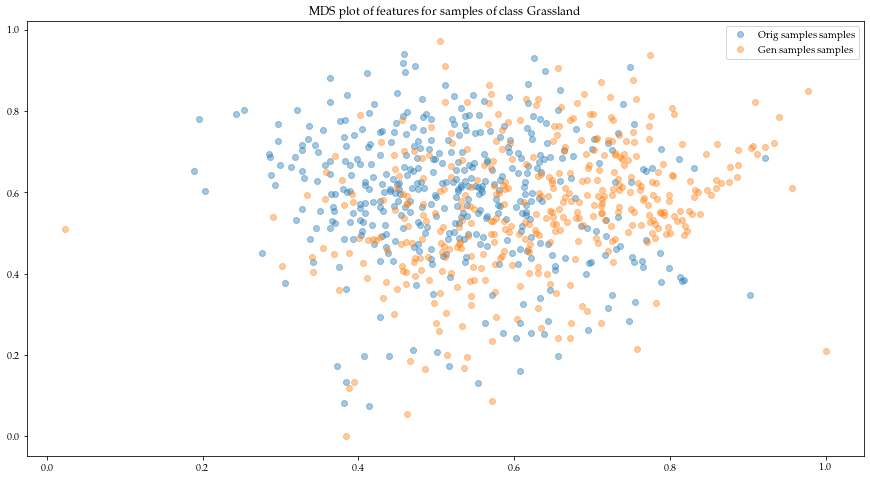

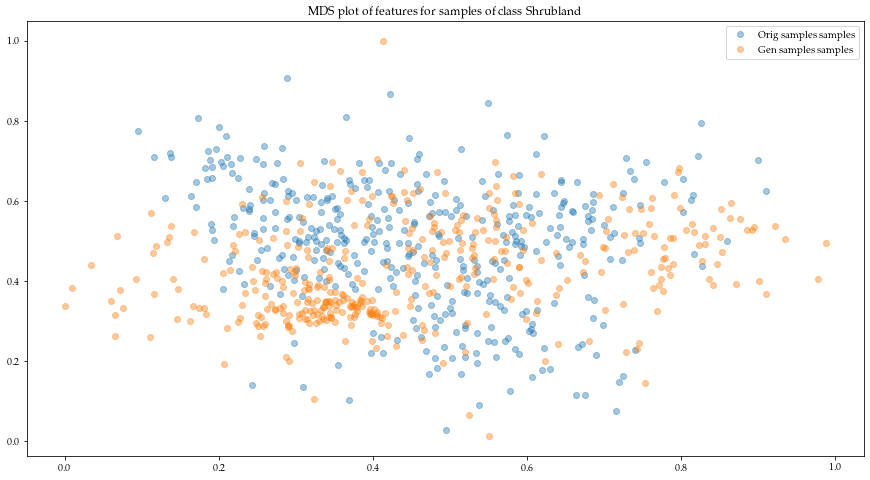

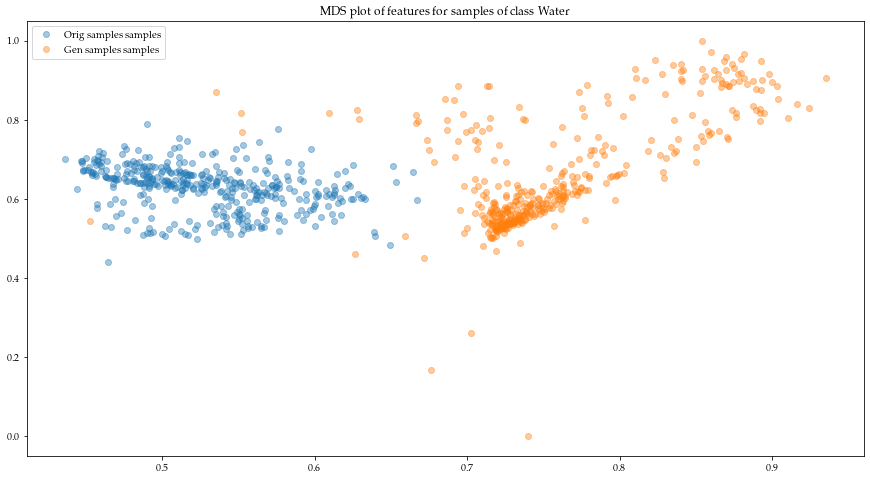

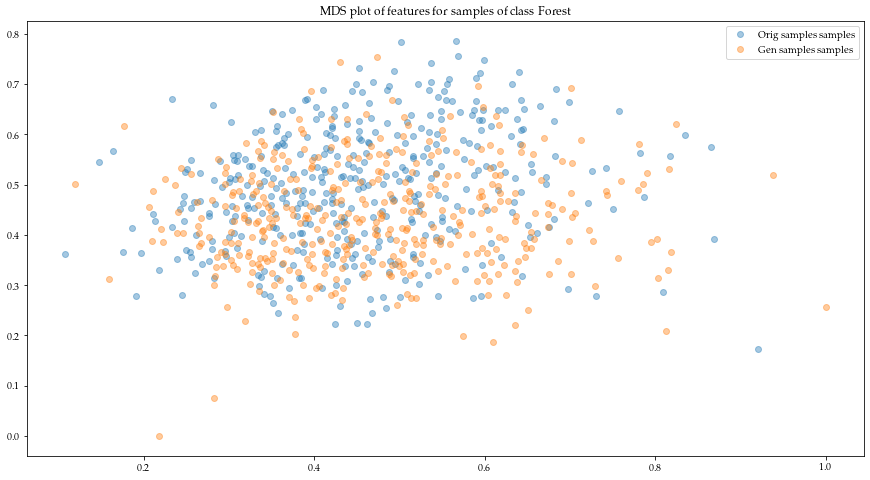

In [24]:
model = 'InceptionV3'
features_dict_or = features_or[model]
features_dict_gen = features_gen[model]
n_components = 2
for i, lc_class in enumerate(features_dict_or.keys()):
    # Concatenate all the features together for each class
    feats_or = features_dict_or[lc_class]['feats'].reshape((features_dict_or[lc_class]['feats'].shape[0], -1))
    feats_gen = features_dict_gen[lc_class]['feats'].reshape((features_dict_gen[lc_class]['feats'].shape[0], -1))
    X = min_max_scaling(np.concatenate([feats_or, feats_gen]))  # normalize the data
    embeds = manifold.MDS(n_components, max_iter=300, n_init=4, n_jobs=1).fit_transform(X)  # fit the manifold learner
    embeds = min_max_scaling(embeds)  # normalize the embeddings

    # Create the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    num_samples = features_dict_or[lc_class]['feats'].shape[0]
    label_or_gen = ['Orig samples', 'Gen samples']
    for j in range(2):
        ax.scatter(embeds[num_samples*j:(j+1)*num_samples-1, 0], embeds[num_samples*j:(j+1)*num_samples-1, 1], alpha=0.4, label=f'{label_or_gen[j]} samples')

    ax.legend()
    ax.set_title(f'MDS plot of features for samples of class {lc_class}')

### ResNet50

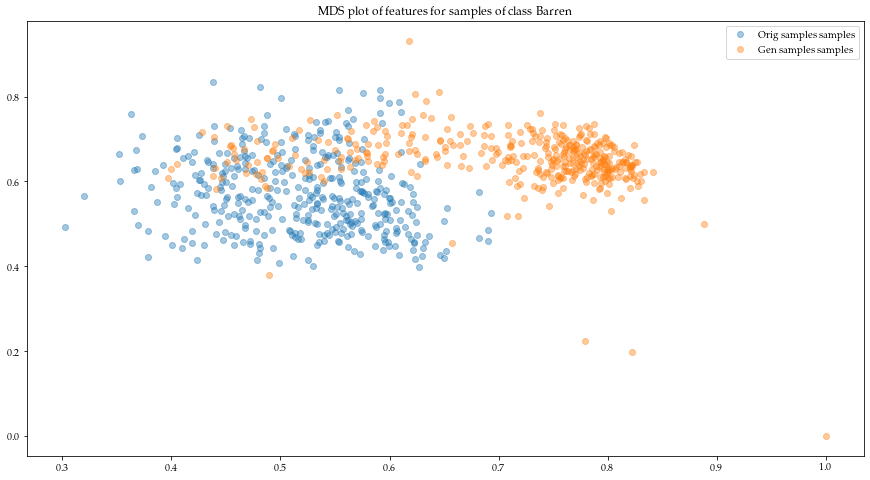

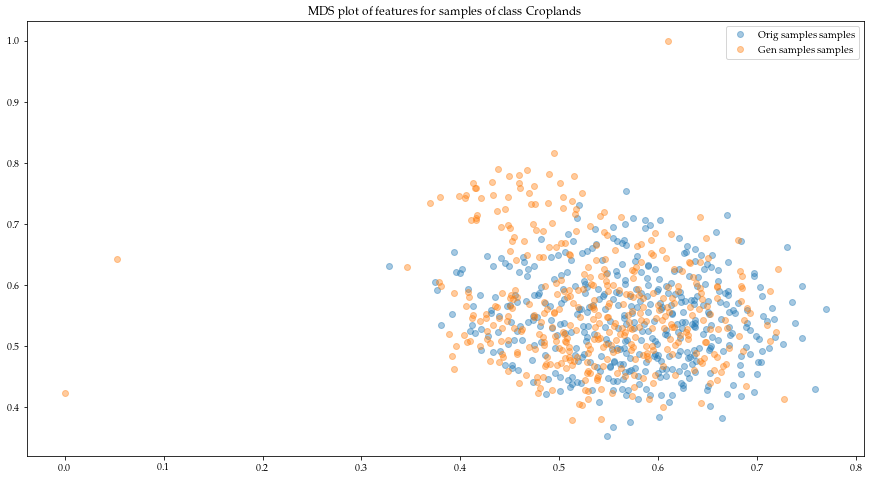

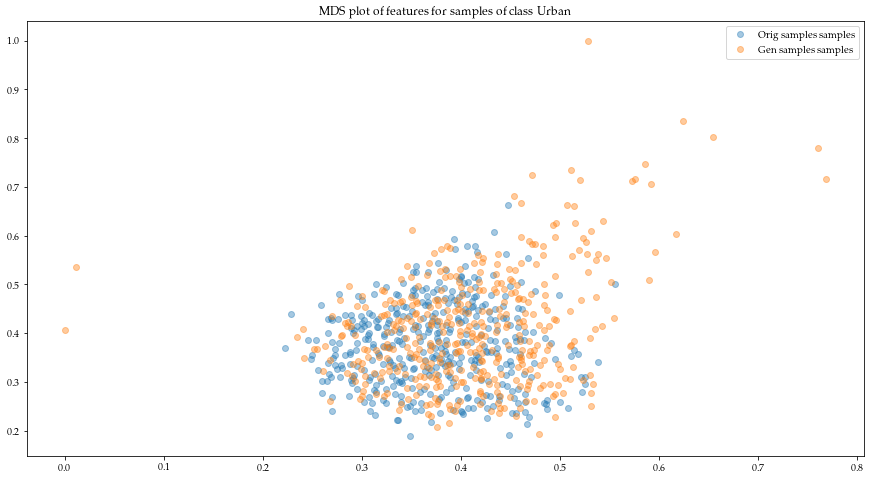

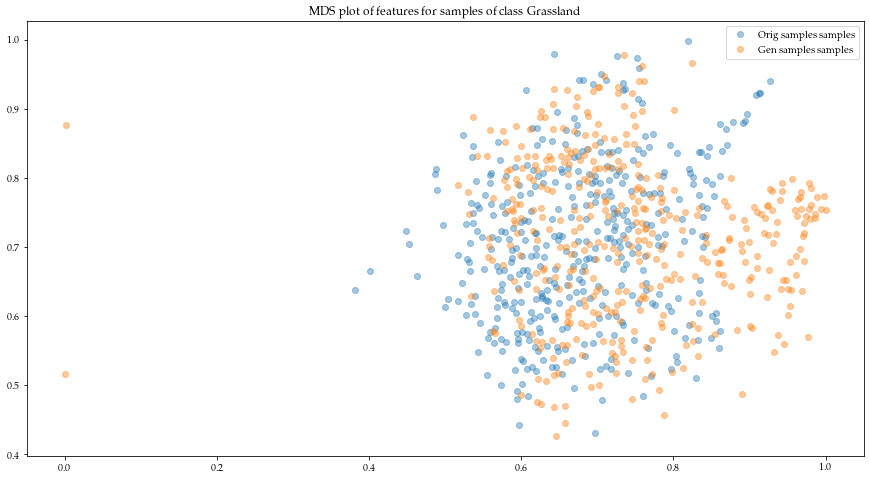

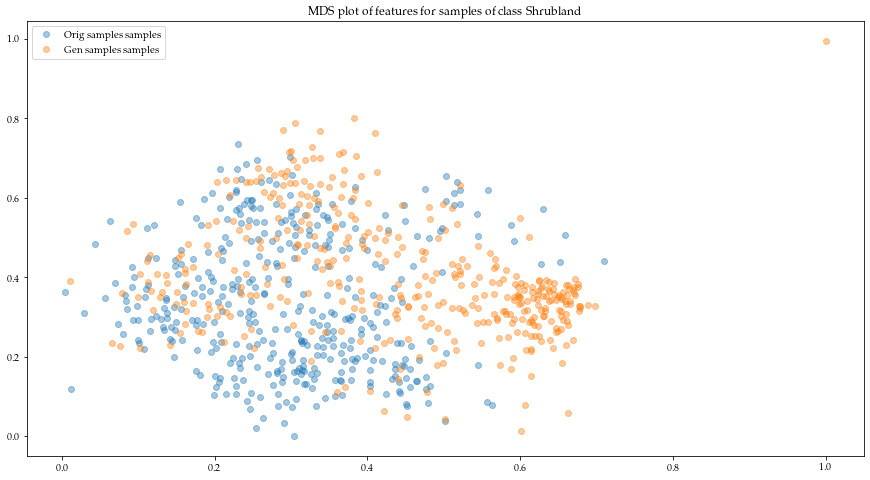

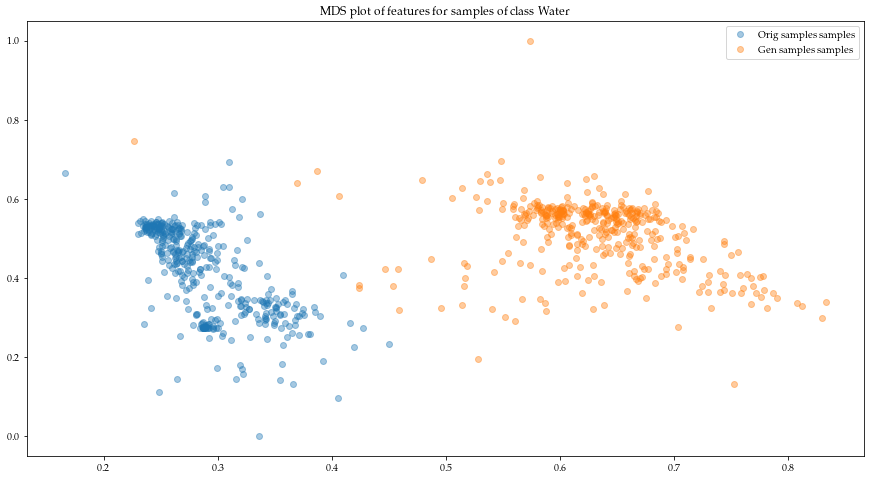

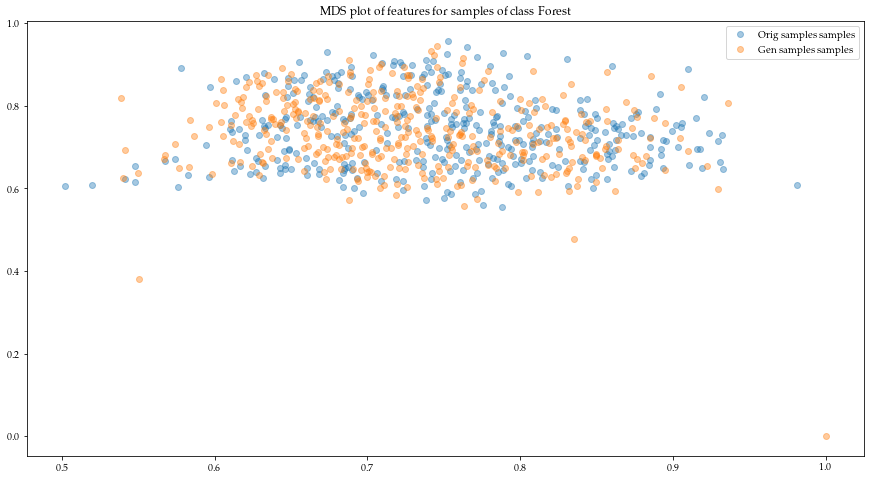

In [25]:
model = 'ResNet50'
features_dict_or = features_or[model]
features_dict_gen = features_gen[model]
n_components = 2
for i, lc_class in enumerate(features_dict_or.keys()):
    # Concatenate all the features together for each class
    feats_or = features_dict_or[lc_class]['feats'].reshape((features_dict_or[lc_class]['feats'].shape[0], -1))
    feats_gen = features_dict_gen[lc_class]['feats'].reshape((features_dict_gen[lc_class]['feats'].shape[0], -1))
    X = min_max_scaling(np.concatenate([feats_or, feats_gen]))  # normalize the data
    embeds = manifold.MDS(n_components, max_iter=300, n_init=4, n_jobs=1).fit_transform(X)  # fit the manifold learner
    embeds = min_max_scaling(embeds)  # normalize the embeddings

    # Create the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    num_samples = features_dict_or[lc_class]['feats'].shape[0]
    label_or_gen = ['Orig samples', 'Gen samples']
    for j in range(2):
        ax.scatter(embeds[num_samples*j:(j+1)*num_samples-1, 0], embeds[num_samples*j:(j+1)*num_samples-1, 1], alpha=0.4, label=f'{label_or_gen[j]} samples')

    ax.legend()
    ax.set_title(f'MDS plot of features for samples of class {lc_class}')

### All original samples together

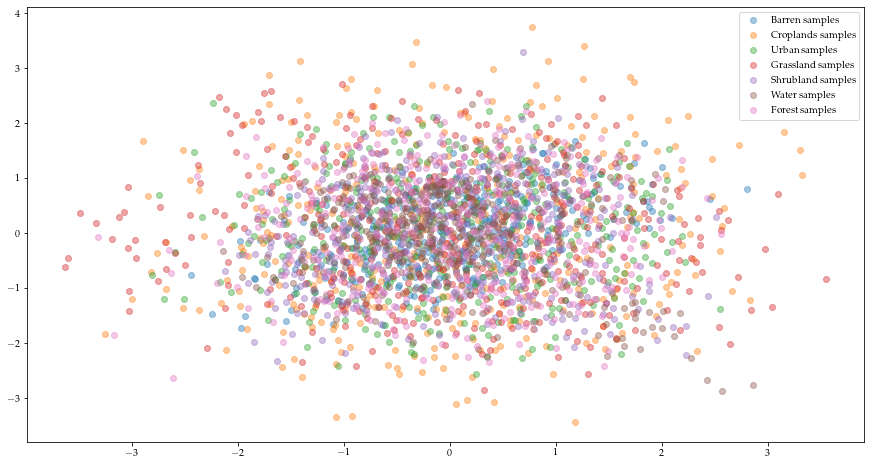

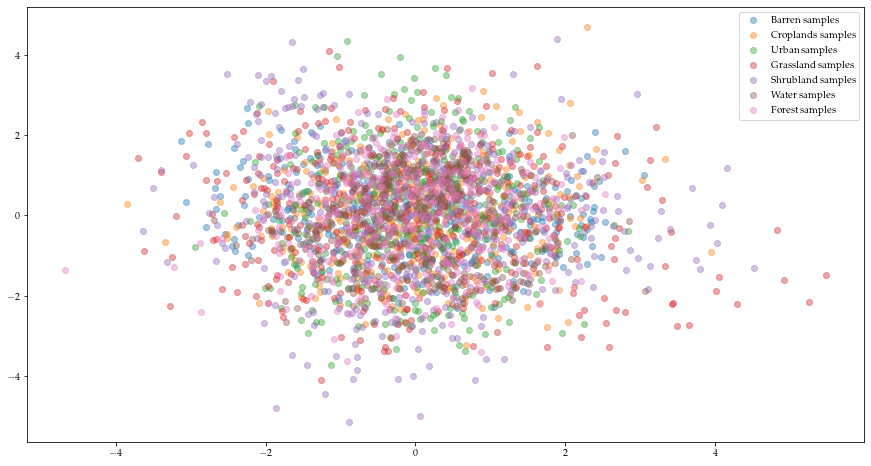

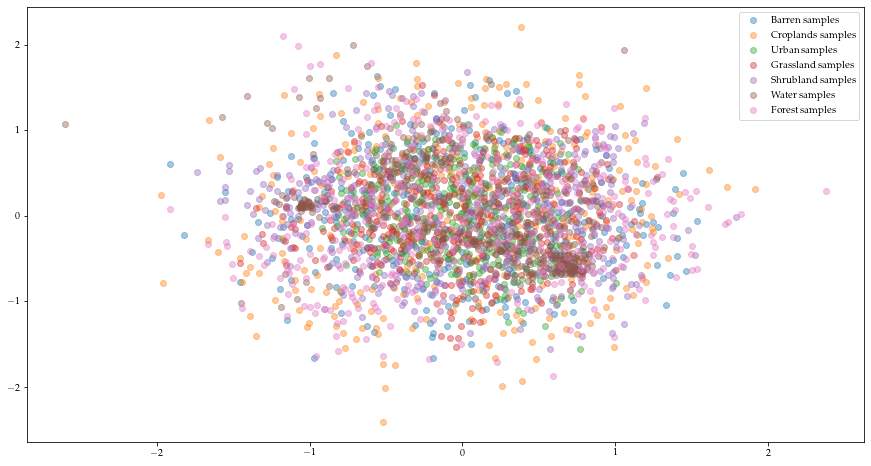

In [26]:
for model in ['EfficientNetB0', 'InceptionV3', 'ResNet50']:
    # Create the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    features_dict = features_or[model]
    for i, lc_class in enumerate(features_dict.keys()):
        # Concatenate all the features together for each class
        feats = features_dict[lc_class]['feats'].reshape((features_dict[lc_class]['feats'].shape[0], -1))

        # Compute the embeddings
        X = min_max_scaling(feats)  # normalize the data
        embeds = manifold.MDS(n_components, max_iter=300, n_init=4, n_jobs=1).fit_transform(X)  # fit the manifold learner
        #embeds = min_max_scaling(embeds)  # normalize the embeddings

        # Scatter plot the embeddings
        ax.scatter(embeds[:, 0], embeds[:, 1], alpha=0.4, label=f'{lc_class} samples')

    ax.legend()


### All DIP samples together

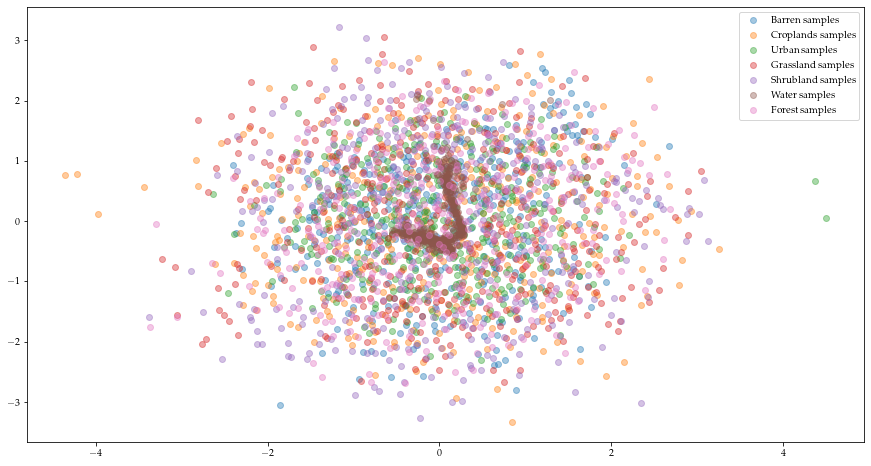

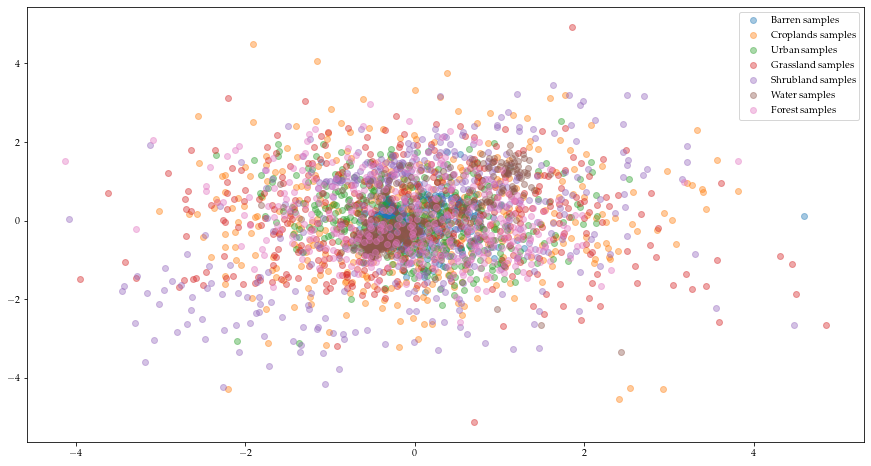

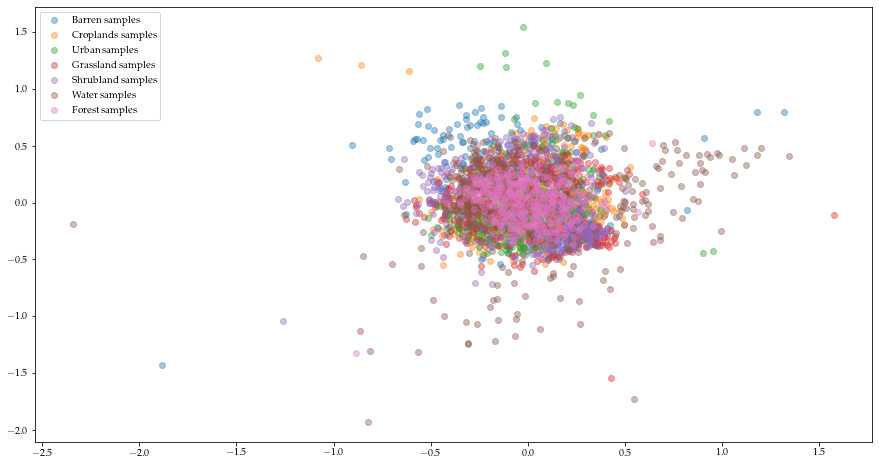

In [27]:
for model in ['EfficientNetB0', 'InceptionV3', 'ResNet50']:
    # Create the figure
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    features_dict = features_gen[model]
    for i, lc_class in enumerate(features_dict.keys()):
        # Concatenate all the features together for each class
        feats = features_dict[lc_class]['feats'].reshape((features_dict[lc_class]['feats'].shape[0], -1))

        # Compute the embeddings
        X = min_max_scaling(feats)  # normalize the data
        embeds = manifold.MDS(n_components, max_iter=300, n_init=4, n_jobs=1).fit_transform(X)  # fit the manifold learner
        #embeds = min_max_scaling(embeds)  # normalize the embeddings

        # Scatter plot the embeddings
        ax.scatter(embeds[:, 0], embeds[:, 1], alpha=0.4, label=f'{lc_class} samples')

    ax.legend()
